<a href="https://colab.research.google.com/github/BDR2939/NLP/blob/main/final_project_final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# links to finetunning works

* https://huggingface.co/docs/transformers/model_doc/xlnet
* https://mccormickml.com/2019/09/19/XLNet-fine-tuning/
* https://towardsdatascience.com/how-to-use-xlnet-from-the-hugging-face-transformer-library-ddd0b7c8d0b9
* https://huggingface.co/docs/transformers/model_doc/xlnet
* https://github.com/zihangdai/xlnet/
  * original git of the auther 
* https://arxiv.org/abs/2009.14119
  * https://github.com/Alibaba-MIIL/ASL
   


# install *pakages*

In [ ]:
!pip install pytorch-transformers
!pip install transformers
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 15.5 MB/s 
     |████████████████████████████████| 132 kB 29.4 MB/s 
     |████████████████████████████████| 1.3 MB 29.1 MB/s 
     |████████████████████████████████| 880 kB 61.8 MB/s 
     |████████████████████████████████| 9.0 MB 9.4 MB/s 
     |████████████████████████████████| 79 kB 5.7 MB/s 
     |████████████████████████████████| 139 kB 65.7 MB/s 
     |████████████████████████████████| 127 kB 23.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=b17148fb1adca23d42721d4512bef7effa51b141e64d7f6a15640167262752b6
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled

# imports 

In [ ]:
import tensorflow as tf
import pytorch_transformers

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pytorch_transformers

from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification, XLNetLMHeadModel
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt


import glob
import os 
from pathlib import Path
import random
import time

import torch.nn as nn
from random import shuffle
from sklearn.metrics import classification_report
from google.colab import drive
from tqdm.notebook import tqdm_notebook
from IPython.display import display
import warnings
from transformers import XLNetTokenizer, XLNetLMHeadModel
from transformers import XLNetForSequenceClassification, XLNetLMHeadModel
import sklearn 
from sklearn.metrics import f1_score
from copy import deepcopy
from torch.cuda.amp import GradScaler, autocast
from skmultilearn.model_selection import iterative_stratification


import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)


% matplotlib inline

# set device for training 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type != 'cpu':
  n_gpu = torch.cuda.device_count()
  torch.cuda.get_device_name(0)

# helper functions

In [ ]:
def reorder_list(a_list, indices):
  selected_elements = []
  for index in indices:
      selected_elements.append(a_list[index])
  return selected_elements


def merge_between_2_df(df1, df2):
    """
    Parameters
    ----------
    df1 : dataframe
    df2 : dataframe

    Returns
    -------
    merge_df : df
        merge of 2 dataframes base unique columns
    """
    columns1 = df1.columns.tolist()
    columns2 = df2.columns.tolist()
    
    diff_columns  = list(set(columns1)-set(columns2))
    uniuqe_columns   = list(set(columns1)-set(diff_columns))
    
    merge_df = pd.merge(df1, df2, how = 'inner', on = uniuqe_columns )
    return merge_df


def get_annotation(merge_train_feature_df):
    """
    Parameters
    ----------
    merge_train_feature_df : dataframe

    Returns
    -------
    merge_train_feature_df : dataframe
        get from pn note the anotation.

    """
    location_list = merge_train_feature_df['location'].tolist()
    pn_history_list = merge_train_feature_df['pn_history'].tolist()
    
    all_localization_text = []
    for i_localization_idx, i_localization in enumerate(location_list):
        print(i_localization_idx)
        if i_localization.__len__()== 0:
            all_localization_text.append([])
        else:
            i_pn_history= pn_history_list[i_localization_idx]
            text = []
            for j_localization_idx, j_localization in enumerate(i_localization):
                if isinstance(j_localization[0], list):
                    text2 = []
                    for l_localization_idx, l_localization in enumerate(j_localization):
                        i_text = i_pn_history[l_localization[0]:l_localization[1]]
                        text2.append(i_text)
                    text.append(text2)
                else:
                    text.append(i_pn_history[j_localization[0]:j_localization[1]])
    
            all_localization_text.append(text)
    
        
        
    merge_train_feature_df['text_base_location'] = all_localization_text
    return merge_train_feature_df


def generate_train_batch_data(tokenizer, merge_train_feature_df, batch_size = 8, max_len = 128, amount_of_features = 131):
    """
    Parameters
    ----------
    merge_train_feature_df : dataframe
        merge of 3  data sets - feaure\train\pn note.
    batch_size : int, optional
        batch size for the training. The default is 8.

    Returns
    -------
    input_list : list
        all input in list.
    tag_list : list
        all tags in list.
    input_tag_list : list
        all input and tags togther.
    """

    pn_num_list = merge_train_feature_df['pn_num'].tolist()
    pn_num_unique = np.unique(pn_num_list)
    input_list  = []
    tag_list = []
    input_tag_list  = []

    batch_input_list = []
    batch_tag_list = []
    sentences = merge_train_feature_df.pn_history.values
    sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
    
    np.random.shuffle(pn_num_unique)
    for pn_num_idx, pn_num in enumerate(pn_num_unique):        
        pn_tag = np.zeros((amount_of_features))
        i_pn_df  = merge_train_feature_df.loc[merge_train_feature_df['pn_num'] == pn_num]
        i_pn_feature_num = i_pn_df['feature_unique_index'].to_numpy()
        np.put(pn_tag, i_pn_feature_num, i_pn_feature_num.__len__()*[1])
        i_pn_input  = i_pn_df.iloc[0]['pn_history']
        # tokenize data
        i_pn_input = tokenizer.tokenize(i_pn_input)
        # convert 2 idx
        i_pn_input = tokenizer.convert_tokens_to_ids(i_pn_input)

        batch_input_list.append(i_pn_input)
        batch_tag_list.append(pn_tag)
        
    batch_input_list = pad_sequences(batch_input_list, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    input_list.append(batch_input_list)
    tag_list.append(batch_tag_list)
    input_tag_list.append((batch_input_list, batch_tag_list))
    return input_list, tag_list, input_tag_list
    

def merge_between_patient_note_train_and_feature(patient_notes_df, features_df, train_df):
    """
    Parameters
    ----------
    patient_notes_df : dataframe
        patient doctors notes.
    features_df : dataframe
        feature options in dataframe.
    train_df : dataframe
        data to train.

    Returns
    -------
    merge_train_feature_df : dataframe
        merge of 3  data sets - feaure\train\pn note.
    """
    
    # !todo - or\roni to sellect spicial caracter to remove 
    spicial_charchther_to_remove = [ ]
    for i_spicial_char in spicial_charchther_to_remove:
        patient_notes_df['pn_history_splited'] = patient_notes_df['pn_history'].apply(lambda x: x.replace('', i_spicial_char))
    patient_notes_df['pn_history_splited'] = patient_notes_df['pn_history'].apply(lambda x: x.lower().split(' '))
    features_df['feature_text'] = features_df['feature_text'].apply(lambda x: x.lower())
    unique_features = features_df.feature_text.unique()
    unique_feature_text_df = pd.DataFrame(unique_features, columns = ['feature_text'])
    unique_feature_text_df['feature_unique_index'] =  np.arange(0, unique_feature_text_df.shape[0])
    features_df  = pd.merge(unique_feature_text_df, features_df, how = 'inner', on = ['feature_text'] )
    train_df['annotation'] = train_df['annotation'].apply(lambda x: x.lower())
    merge_train_feature_df = merge_between_2_df(train_df, features_df)
    merge_train_feature_df = merge_between_2_df(merge_train_feature_df, patient_notes_df)
    merge_train_feature_df.location.replace('[]', np.nan, inplace = True)
    merge_train_feature_df.dropna(inplace = True, axis = 0)
    return merge_train_feature_df.reset_index(drop = True)


# set path's

In [ ]:
# general folder path
drive_path = '/content/gdrive'
drive_saving_path = '/content/gdrive/My Drive'
drive.mount(drive_path)
main_path = os.path.join(drive_saving_path, 'NLP_project')
save_path = os.path.join(main_path, 'parameters grid search')
csv_folder_path = os.path.join(main_path, 'nbme-score-clinical-patient-notes')

Mounted at /content/gdrive


# get train csv path's

In [ ]:

"""
there are 5 csv files:
 1. features
 2. patient_notes
 3. sample_submission
 4. test
 5. train
"""

# read  all csv from folder
csv_path_list = glob.glob(os.path.join(csv_folder_path, '*.csv'))
csv_dict = {}
for i_path in csv_path_list:
    file_name = Path(i_path).stem
    csv_df = pd.read_csv(i_path)
    csv_dict[file_name] = csv_df


# get csv's
patient_notes_df  =  csv_dict['patient_notes']
features_df  =  csv_dict['features']
train_df  =  csv_dict['train']


# merge between training csv's

In [ ]:

# can be remove not realy needed to order the localicalization
order_localization = False
if order_localization:
    train_df = convert_location_to_list_of_ranges(train_df)

# merge between 3 data frames 
merge_train_feature_df = merge_between_patient_note_train_and_feature(patient_notes_df, features_df, train_df)


# display train dataframa

In [ ]:
merge_train_feature_df.head(10)

id  case_num  pn_num  feature_num  \
0  00016_000         0      16            0   
1  00016_001         0      16            1   
2  00016_002         0      16            2   
3  00016_003         0      16            3   
4  00016_004         0      16            4   
5  00016_006         0      16            6   
6  00016_009         0      16            9   
7  00016_010         0      16           10   
8  00016_011         0      16           11   
9  00016_012         0      16           12   

                                   annotation  \
0            ['dad with recent heart attcak']   
1               ['mom with "thyroid disease']   
2                          ['chest pressure']   
3        ['intermittent episodes', 'episode']   
4    ['felt as if he were going to pass out']   
5      ['adderall', 'adderrall', 'adderrall']   
6  ['palpitations', 'heart beating/pounding']   
7                           ['3-4 months of']   
8                                    ['17yo']   
9                                       ['m']   

                            location  \
0                        ['696 724']   
1                        ['668 693']   
2                        ['203 217']   
3               ['70 91', '176 183']   
4                        ['222 258']   
5  ['321 329', '404 413', '652 661']   
6                ['26 38', '96 118']   
7                          ['56 69']   
8                            ['5 9']   
9                          ['10 11']   

                                        feature_text  feature_unique_index  \
0  family-history-of-mi-or-family-history-of-myoc...                     0   
1                 family-history-of-thyroid-disorder                     1   
2                                     chest-pressure                     2   
3                              intermittent-symptoms                     3   
4                                        lightheaded                     4   
5                                       adderall-use                     6   
6                     heart-pounding-or-heart-racing                     9   
7                                few-months-duration                    10   
8                                            17-year                    11   
9                                               male                    12   

                                          pn_history  \
0  HPI: 17yo M presents with palpitations. Patien...   
1  HPI: 17yo M presents with palpitations. Patien...   
2  HPI: 17yo M presents with palpitations. Patien...   
3  HPI: 17yo M presents with palpitations. Patien...   
4  HPI: 17yo M presents with palpitations. Patien...   
5  HPI: 17yo M presents with palpitations. Patien...   
6  HPI: 17yo M presents with palpitations. Patien...   
7  HPI: 17yo M presents with palpitations. Patien...   
8  HPI: 17yo M presents with palpitations. Patien...   
9  HPI: 17yo M presents with palpitations. Patien...   

                                  pn_history_splited  
0  [hpi:, 17yo, m, presents, with, palpitations.,...  
1  [hpi:, 17yo, m, presents, with, palpitations.,...  
2  [hpi:, 17yo, m, presents, with, palpitations.,...  
3  [hpi:, 17yo, m, presents, with, palpitations.,...  
4  [hpi:, 17yo, m, presents, with, palpitations.,...  
5  [hpi:, 17yo, m, presents, with, palpitations.,...  
6  [hpi:, 17yo, m, presents, with, palpitations.,...  
7  [hpi:, 17yo, m, presents, with, palpitations.,...  
8  [hpi:, 17yo, m, presents, with, palpitations.,...  
9  [hpi:, 17yo, m, presents, with, palpitations.,...

# display some statistics

### Number of unique patients

In [ ]:
len(merge_train_feature_df.pn_num.unique())

1000

### Number of patients for each case number

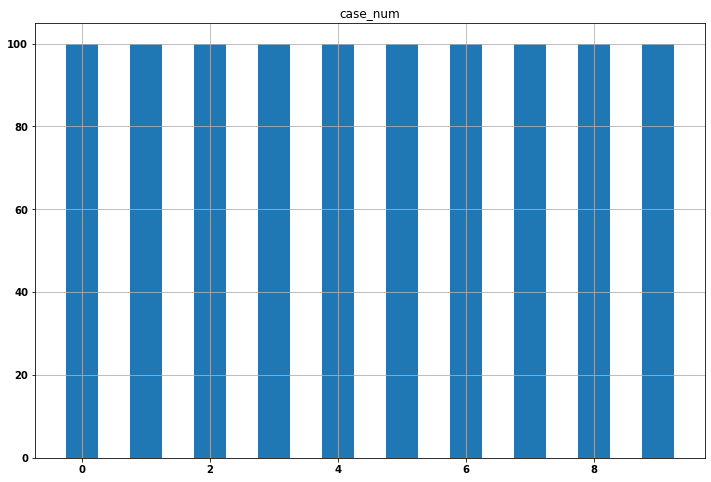

In [ ]:
merge_train_feature_df.groupby(['pn_num', 'case_num']).mean().reset_index().hist(column = 'case_num', bins = np.arange(-0.25, 9.5, 0.5), figsize = (12, 8));

### Number of lines for case number

In [ ]:
merge_train_feature_df.case_num.value_counts()

3    1198
8    1190
5    1174
0     998
2     998
9     992
6     971
1     942
4     746
7     692
Name: case_num, dtype: int64

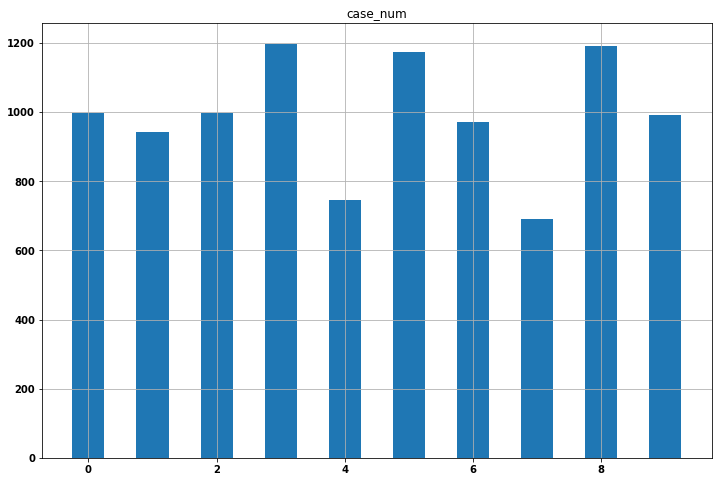

In [ ]:
merge_train_feature_df.hist(column = 'case_num', bins = np.arange(-0.25, 9.5, 0.5), figsize = (12, 8));

### Number of lines for feature

In [ ]:
merge_train_feature_df.feature_unique_index.value_counts()

25     680
12     286
56     198
17     197
11     195
      ... 
123     11
108      7
126      2
106      1
34       1
Name: feature_unique_index, Length: 131, dtype: int64

In [ ]:
merge_train_feature_df.loc[merge_train_feature_df['feature_unique_index'] == 25, 'feature_text'].unique()

array(['female'], dtype=object)

In [ ]:
merge_train_feature_df.loc[merge_train_feature_df['feature_unique_index'] == 12, 'feature_text'].unique()

array(['male'], dtype=object)

Text(0, 0.5, 'count of features')

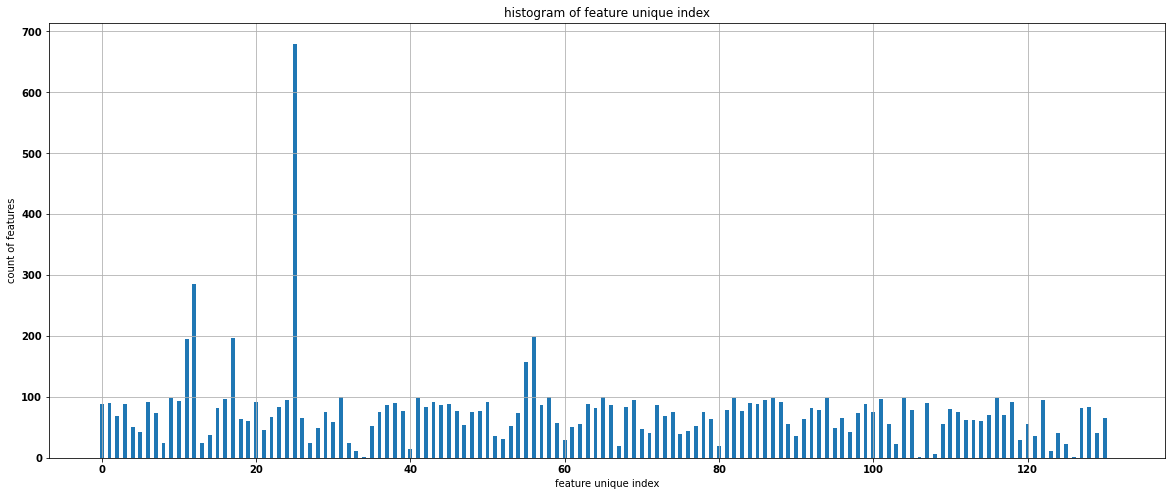

In [ ]:
merge_train_feature_df.hist(column = 'feature_unique_index', bins = np.arange(-0.25, 131.5, 0.5), figsize = (20, 8));
plt.title('histogram of feature unique index')
plt.xlabel('feature unique index')
plt.ylabel('count of features')

<Figure size 432x288 with 0 Axes>

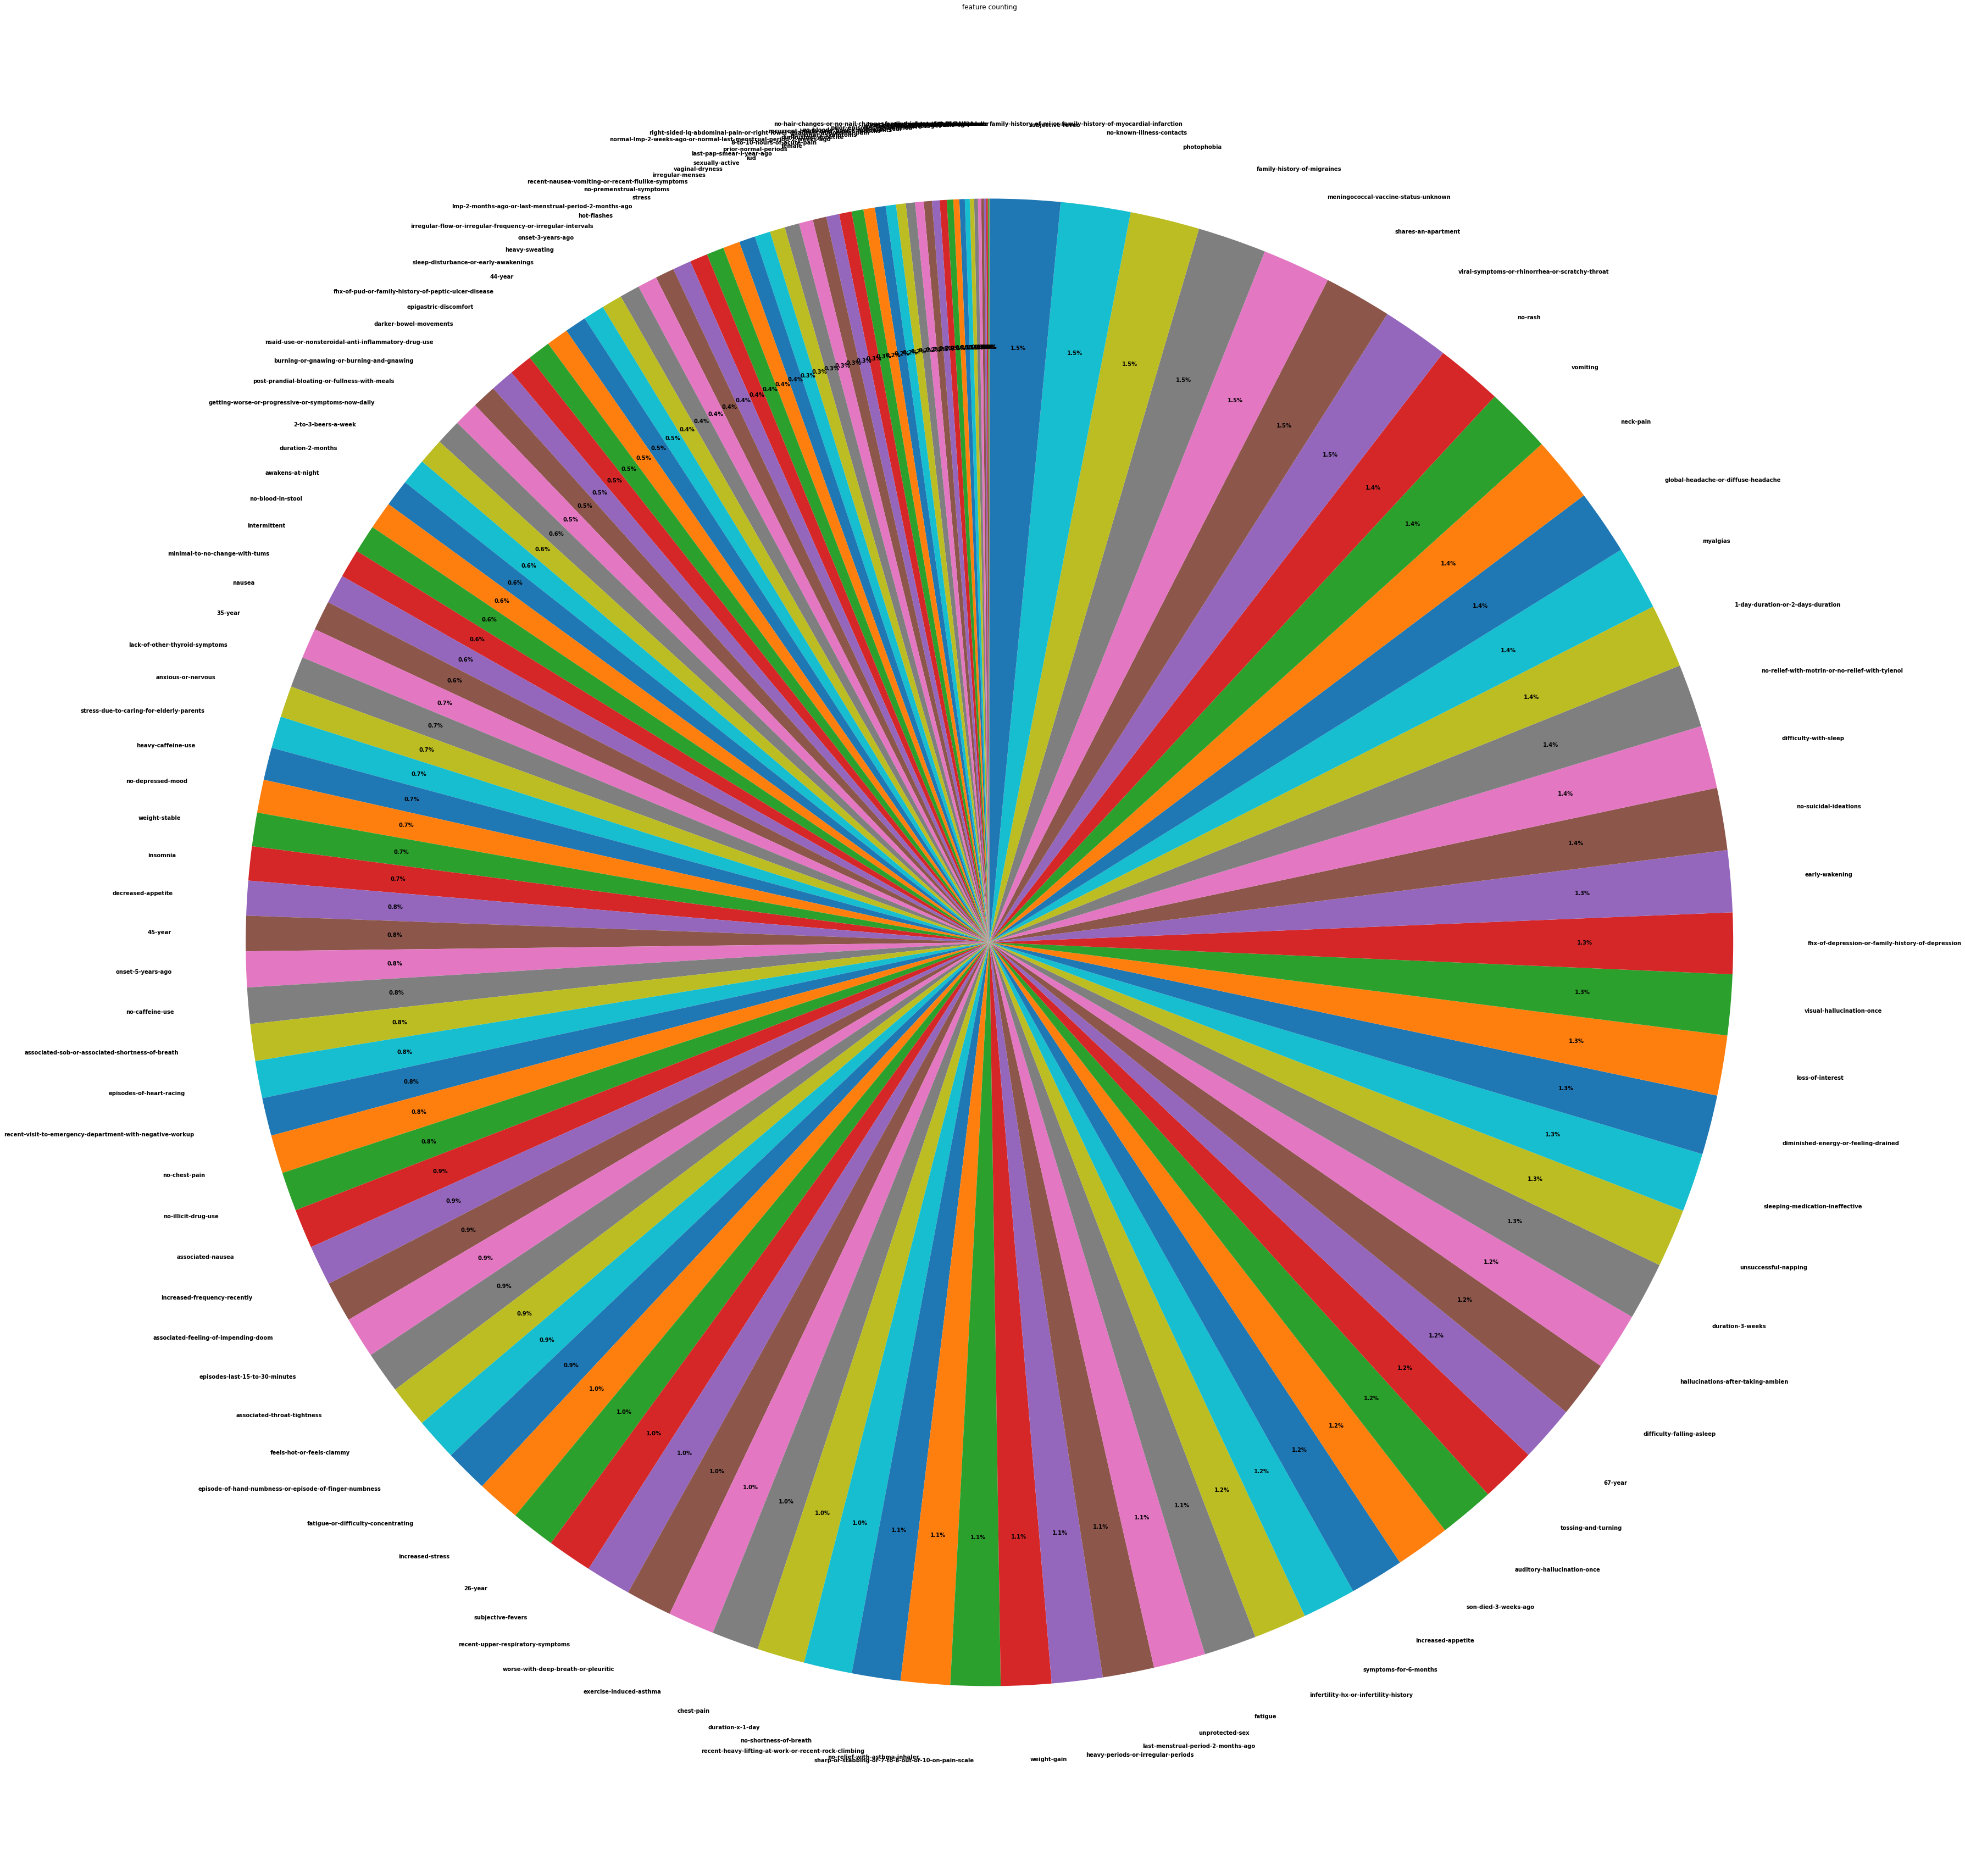

In [ ]:
merge_train_feature_df.columns
feature_count, indices = np.unique(merge_train_feature_df.feature_unique_index.values,return_index= True)
feature_text_list = reorder_list(merge_train_feature_df.feature_text.values,indices )
amount_of_features = feature_count.size

plt.figure()


plt.figure(figsize=(50,50))
plt.title("feature counting",  fontsize=12)
circle0 = plt.Circle( (0,0), 0.6, color = 'white')
plt.pie(feature_count, labels=feature_text_list, autopct='%2.1f%%', pctdistance=0.8, startangle=90)
plt.tight_layout()






In [ ]:
amount_of_features

131

# set tokenizer and apply on sentences 

In [ ]:
MAX_LEN = 256

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

# tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


In [ ]:
input_ids, labels, input_tag_list = generate_train_batch_data(tokenizer, merge_train_feature_df, max_len = MAX_LEN, amount_of_features = amount_of_features)


In [ ]:
input_ids = np.concatenate(input_ids)
labels = np.concatenate(labels)


In [ ]:
print('input shape: '  +  str(input_ids.shape))
print('label shape: '  +  str(labels.shape))

input shape: (1000, 256)
label shape: (1000, 131)


# Create the attention masks



In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq.tolist()]
  attention_masks.append(seq_mask)

# split data into train & test & validation

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
print('train size ' + str(train_inputs.shape[0]))
print('validation size ' + str(validation_inputs.shape[0]))

train size 900
validation size 100


# convert input into tensors

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# accuracy functions

In [ ]:
from sklearn.metrics import average_precision_score

def average_precision(output, target):
    epsilon = 1e-8

    # sort examples
    indices = output.argsort()[::-1]
    # Computes prec@i
    total_count_ = np.cumsum(np.ones((len(output), 1)))

    target_ = target[indices]
    ind = target_ == 1
    pos_count_ = np.cumsum(ind)
    total = pos_count_[-1]
    pos_count_[np.logical_not(ind)] = 0
    pp = pos_count_ / total_count_
    precision_at_i_ = np.sum(pp)
    precision_at_i = precision_at_i_ / (total + epsilon)

    return precision_at_i


def mAP(targs, preds):
    """Returns the model's average precision for each class
    Return:
        ap (FloatTensor): 1xK tensor, with avg precision for each class k
    """

    if np.size(preds) == 0:
        return 0
    ap = np.zeros((preds.shape[1]))
    # compute average precision for each class
    for k in range(preds.shape[1]):
        # sort scores
        scores = preds[:, k]
        targets = targs[:, k]
        # compute average precision
        ap[k] = average_precision(scores, targets)
        # ap[k] = average_precision_score(targets, scores)
    return 100 * ap.mean()

def validate_multi(val_loader, model, ema_model):
    print("starting validation")
    Sig = torch.nn.Sigmoid()
    preds_regular = []
    preds_ema = []
    targets = []
    for i, (input, target) in enumerate(val_loader):
        target = target
        target = target.max(dim=1)[0]
        # compute output
        with torch.no_grad():
            with autocast():
                output_regular = Sig(model(input.cuda())).cpu()
                output_ema = Sig(ema_model.module(input.cuda())).cpu()

        # for mAP calculation
        preds_regular.append(output_regular.cpu().detach())
        preds_ema.append(output_ema.cpu().detach())
        targets.append(target.cpu().detach())

    mAP_score_regular = mAP(torch.cat(targets).numpy(), torch.cat(preds_regular).numpy())
    mAP_score_ema = mAP(torch.cat(targets).numpy(), torch.cat(preds_ema).numpy())
    print("mAP score regular {:.2f}, mAP score EMA {:.2f}".format(mAP_score_regular, mAP_score_ema))
    return max(mAP_score_regular, mAP_score_ema)




In [ ]:
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()

class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()

class ModelEma(torch.nn.Module):
    def __init__(self, model, decay=0.9997, device=None):
        super(ModelEma, self).__init__()
        # make a copy of the model for accumulating moving average of weights
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device  # perform ema on different device from model if set
        if self.device is not None:
            self.module.to(device=device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)

    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)
        

# Training loop

In [ ]:
def train_loop(epochs, use_defult_loss, learning_rate, batch_size, train_inputs, train_masks, train_labels,
               validation_inputs, validation_masks, validation_labels):


  # Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
  # with an iterator the entire dataset does not need to be loaded into memory
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


  # Load XLnet model
  model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels= amount_of_features )
  model.to(device)

  # Set parameters for training
  param_optimizer = list(model.named_parameters())
  no_decay = ['bias', 'gamma', 'beta']
  optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
  ]

  # Set optimizer
  optimizer = AdamW(optimizer_grouped_parameters,
                     lr=learning_rate)
  
  # Store our loss and accuracy for plotting
  train_loss_set = []
  # val_loss_set = []
  train_mAP_acc_set = []
  mAP_acc_set = []
  train_f1_acc_set = []
  f1_acc_set = []

  # Best validation accuracy for model saving
  best_validation_acc_mAP = 0
  best_validation_acc_f1 = 0

  # Set loss if not using default one
  if not use_defult_loss:
    criterion = AsymmetricLoss(gamma_neg=4, gamma_pos=0, clip=0.05, disable_torch_grad_focal_loss=True)
    scaler = GradScaler()
    ema = ModelEma(model, 0.9997)  # 0.9997^641=0.82

  # trange is a tqdm wrapper around the normal python range
  for _ in trange(epochs, desc="Epoch"):

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Tracking variables 
    train_accuracy_mAP = 0
    train_accuracy_f1 = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      
      # Forward pass
      # print('input shape: ' + str(b_input_ids.shape)+ ', attention mask shape: ' + str(b_input_mask.shape) + ', label shape: ' + str(b_labels.shape))
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      logits = outputs[1]

      if use_defult_loss:
        loss = outputs[0]
        train_loss_set.append(loss.item())    
        
        # Backward pass
        loss.backward()
        
        # Update parameters and take a step using the computed gradient
        optimizer.step()

      else:
        loss = criterion(outputs[1], b_labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        ema.update(model)

      # Update tracking variables
      tr_loss += loss.item()
      nb_tr_examples += b_input_ids.size(0)
      nb_tr_steps += 1

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      mAP_logits = 1/(1 + np.exp(-logits))
      tmp_train_accuracy_f1 = f1_score(label_ids, (mAP_logits > 0.5).astype(np.int_), average='weighted', zero_division=1)

      tmp_train_accuracy_mAP = mAP(label_ids, mAP_logits)
      train_accuracy_mAP += tmp_train_accuracy_mAP
      train_accuracy_f1 += tmp_train_accuracy_f1

      # tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    train_loss_set.append(tr_loss/nb_tr_steps)    
    train_mAP_acc_set.append(train_accuracy_mAP/nb_tr_steps)
    train_f1_acc_set.append(train_accuracy_f1/nb_tr_steps)

    print("\nTrain loss: {}".format(tr_loss/nb_tr_steps))
    print("Train Acc mAP: {}".format(train_accuracy_mAP/nb_tr_steps))
    print("Train Acc f1: {}".format(train_accuracy_f1/nb_tr_steps))

      
    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy_mAP, eval_accuracy_f1 = 0, 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      
      # Telling the model not to compute or store gradients, saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate logit predictions
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = output[0]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      mAP_logits = 1/(1 + np.exp(-logits))

      tmp_eval_accuracy_mAP = mAP(label_ids, mAP_logits)
      tmp_eval_accuracy_f1 = f1_score(label_ids, (mAP_logits > 0.5).astype(np.int_), average='weighted', zero_division=1)
      # tmp_eval_accuracy = flat_accuracy(logits, label_ids)
      eval_accuracy_mAP += tmp_eval_accuracy_mAP
      eval_accuracy_f1 += tmp_eval_accuracy_f1
      nb_eval_steps += 1

    print("Validation Acc mAP: {}".format(eval_accuracy_mAP/nb_eval_steps))
    print("Validation Acc f1: {}".format(eval_accuracy_f1/nb_eval_steps))

    if use_default_loss:
      file_name = f'best_acc_(mAP)_model_original_loss_lr_{learning_rate}_batch_size_{batch_size}.h5'
    else:
      file_name = f'best_acc_(mAP)_model_ASL_lr_{learning_rate}_batch_size_{batch_size}.h5'

    if eval_accuracy_mAP/nb_eval_steps > best_validation_acc_mAP:
        model_path = os.path.join(save_path, file_name)
        torch.save(model.state_dict(), model_path)
        best_validation_acc_mAP = eval_accuracy_mAP/nb_eval_steps

    if use_default_loss:
      file_name = f'best_acc_(f1)_model_original_loss_lr_{learning_rate}_batch_size_{batch_size}.h5'
    else:
      file_name = f'best_acc_(f1)_model_ASL_lr_{learning_rate}_batch_size_{batch_size}.h5'

    if eval_accuracy_f1/nb_eval_steps > best_validation_acc_f1:
        model_path = os.path.join(save_path, file_name)
        torch.save(model.state_dict(), model_path)
        best_validation_acc_f1 = eval_accuracy_f1/nb_eval_steps

    mAP_acc_set.append(eval_accuracy_mAP/nb_eval_steps)
    f1_acc_set.append(eval_accuracy_f1/nb_eval_steps)

  return train_loss_set, train_mAP_acc_set, mAP_acc_set, train_f1_acc_set, f1_acc_set


In [ ]:
  def train_and_plot_results(epochs, use_default_loss, learning_rate, batch_size, train_inputs, train_masks, train_labels,
                validation_inputs, validation_masks, validation_labels):
    train_loss_set, train_mAP_acc_set, mAP_acc_set, train_f1_acc_set, f1_acc_set = train_loop(epochs, use_default_loss, learning_rate, batch_size, train_inputs, train_masks, train_labels,
                  validation_inputs, validation_masks, validation_labels)

    result_arrays = [train_loss_set,
                      train_mAP_acc_set,
                      mAP_acc_set,
                      train_f1_acc_set,
                      f1_acc_set]

    if use_default_loss:
      file_names = [f'loss_set_original_loss_lr_{learning_rate}_batch_size_{batch_size}_{epochs}_epochs.txt',
                    f'train_mAP_acc_set_original_loss_lr_{learning_rate}_batch_size_{batch_size}_{epochs}_epochs.txt',
                    f'validation_mAP_acc_set_original_loss_lr_{learning_rate}_batch_size_{batch_size}_{epochs}_epochs.txt',
                    f'train_f1_acc_set_original_loss_lr_{learning_rate}_batch_size_{batch_size}_{epochs}_epochs.txt',
                    f'validation_f1_acc_set_original_loss_lr_{learning_rate}_batch_size_{batch_size}_{epochs}_epochs.txt']

      for filename, arr  in zip(file_names, result_arrays):
        output_path = os.path.join(save_path, filename)
        with open(output_path, 'w+') as f:
          np.savetxt(f, arr)

    else:
      file_names = [f'loss_set_ASL_lr_{learning_rate}_batch_size_{batch_size}_{epochs}_epochs.txt',
                    f'train_mAP_acc_set_ASL_lr_{learning_rate}_batch_size_{batch_size}_{epochs}_epochs.txt',
                    f'validation_mAP_acc_set_ASL_lr_{learning_rate}_batch_size_{batch_size}_{epochs}_epochs.txt',
                    f'train_f1_acc_set_ASL_lr_{learning_rate}_batch_size_{batch_size}_{epochs}_epochs.txt',
                    f'validation_f1_acc_set_ASL_lr_{learning_rate}_batch_size_{batch_size}_{epochs}_epochs.txt']

      for filename, arr  in zip(file_names, result_arrays):
        output_path = os.path.join(save_path, filename)
        with open(output_path, 'w+') as f:
          np.savetxt(f, arr)

    return train_loss_set, train_mAP_acc_set, mAP_acc_set, train_f1_acc_set, f1_acc_set

In [ ]:
def plot_results(results, labels, title):
  fig1, ax1 = plt.subplots(1, figsize=(15,8))
  fig1.suptitle(f'Training loss - {title}')
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  
  fig2, ax2 = plt.subplots(1, figsize=(15,8))
  fig2.suptitle(f'Training mAP accuracy - {title}')
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("mAP accuracy")

  fig3, ax3 = plt.subplots(1, figsize=(15,8))
  fig3.suptitle(f'Validation mAP accuracy - {title}')
  ax3.set_xlabel("Epoch")
  ax3.set_ylabel("mAP accuracy")

  fig4, ax4 = plt.subplots(1, figsize=(15,8))
  fig4.suptitle(f'Training f1 accuracy - {title}')
  ax4.set_xlabel("Epoch")
  ax4.set_ylabel("f1 accuracy")

  fig5, ax5 = plt.subplots(1, figsize=(15,8))
  fig5.suptitle(f'Validation f1 accuracy - {title}')
  ax5.set_xlabel("Epoch") 
  ax5.set_ylabel("f1 accuracy")
  
  for i, result in enumerate(results):
    train_loss_set, train_mAP_acc_set, mAP_acc_set, train_f1_acc_set, f1_acc_set = result
    ax1.plot(train_loss_set, label = labels[i])
    ax2.plot(train_mAP_acc_set, label = labels[i])
    ax3.plot(mAP_acc_set, label = labels[i])
    ax4.plot(train_f1_acc_set, label = labels[i])
    ax5.plot(f1_acc_set, label = labels[i])

  ax1.legend(loc=2, prop={'size': 6})
  ax1.grid()
  ax2.legend(loc=2, prop={'size': 6})
  ax2.grid()
  ax3.legend(loc=2, prop={'size': 6})
  ax3.grid()
  ax4.legend(loc=2, prop={'size': 6})
  ax4.grid()
  ax5.legend(loc=2, prop={'size': 6})
  ax5.grid()
  
  plt.show(fig1)
  plt.show(fig2)
  plt.show(fig3)
  plt.show(fig4)
  plt.show(fig5)


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a


Train loss: 0.27961686160810245
Train Acc mAP: 16.486633927901156
Train Acc f1: 0.061961310476977983
Validation Acc mAP: 16.0084466821333
Validation Acc f1: 0.06780772891573872


Epoch:   2%|▏         | 1/50 [00:41<33:54, 41.51s/it]


Train loss: 0.25309522569664006
Train Acc mAP: 16.419683443642153
Train Acc f1: 0.056066139081496366
Validation Acc mAP: 16.034821040031577
Validation Acc f1: 0.06780772891573872


Epoch:   4%|▍         | 2/50 [01:19<31:22, 39.21s/it]


Train loss: 0.2538587191651109
Train Acc mAP: 16.4644624317056
Train Acc f1: 0.05636031176427326
Validation Acc mAP: 16.83708474630471
Validation Acc f1: 0.06780772891573872


Epoch:   6%|▌         | 3/50 [01:56<29:57, 38.24s/it]


Train loss: 0.25325958622974043
Train Acc mAP: 16.13908181019251
Train Acc f1: 0.05620613608532358
Validation Acc mAP: 17.161984580014774
Validation Acc f1: 0.06780772891573872


Epoch:   8%|▊         | 4/50 [02:34<29:15, 38.17s/it]


Train loss: 0.2525194356028487
Train Acc mAP: 16.52425940753912
Train Acc f1: 0.05677823655670614
Validation Acc mAP: 17.98597232296851
Validation Acc f1: 0.06780772891573872


Epoch:  10%|█         | 5/50 [03:11<28:19, 37.77s/it]


Train loss: 0.24595207706631525
Train Acc mAP: 18.852855791047276
Train Acc f1: 0.05942525900514544


Epoch:  12%|█▏        | 6/50 [03:46<27:09, 37.03s/it]

Validation Acc mAP: 15.40963346946015
Validation Acc f1: 0.06780772891573872

Train loss: 0.25660806618291726
Train Acc mAP: 16.023027164800038
Train Acc f1: 0.056025256345972954


Epoch:  14%|█▍        | 7/50 [04:22<26:11, 36.54s/it]

Validation Acc mAP: 16.23658450149436
Validation Acc f1: 0.06780772891573872

Train loss: 0.2529481671112152
Train Acc mAP: 16.373144415905983
Train Acc f1: 0.056219046916676355


Epoch:  16%|█▌        | 8/50 [04:57<25:20, 36.20s/it]

Validation Acc mAP: 15.875219404327769
Validation Acc f1: 0.06780772891573872

Train loss: 0.2533546702398633
Train Acc mAP: 16.414098491860578
Train Acc f1: 0.056663432766300724


Epoch:  18%|█▊        | 9/50 [05:33<24:35, 35.98s/it]

Validation Acc mAP: 15.918180471200474
Validation Acc f1: 0.06780772891573872

Train loss: 0.25369352479436164
Train Acc mAP: 16.147304579586798
Train Acc f1: 0.056167970622123614


Epoch:  20%|██        | 10/50 [06:08<23:52, 35.81s/it]

Validation Acc mAP: 16.123723442492057
Validation Acc f1: 0.06780772891573872

Train loss: 0.25368840348820204
Train Acc mAP: 16.11151102158512
Train Acc f1: 0.05718708091082761


Epoch:  22%|██▏       | 11/50 [06:44<23:12, 35.70s/it]

Validation Acc mAP: 16.57692460503137
Validation Acc f1: 0.06780772891573872

Train loss: 0.2536048540343754
Train Acc mAP: 16.086623700140578
Train Acc f1: 0.056586770237522094


Epoch:  24%|██▍       | 12/50 [07:19<22:34, 35.65s/it]

Validation Acc mAP: 16.69233252079624
Validation Acc f1: 0.06780772891573872

Train loss: 0.2534581254385536
Train Acc mAP: 16.342666896263818
Train Acc f1: 0.05657026707783382


Epoch:  26%|██▌       | 13/50 [07:55<21:56, 35.59s/it]

Validation Acc mAP: 16.67656203092161
Validation Acc f1: 0.06780772891573872

Train loss: 0.2531821560085898
Train Acc mAP: 16.010106223570798
Train Acc f1: 0.05585768117174248


Epoch:  28%|██▊       | 14/50 [08:30<21:20, 35.57s/it]

Validation Acc mAP: 16.43690559156129
Validation Acc f1: 0.06780772891573872

Train loss: 0.25370339710455014
Train Acc mAP: 16.111848484190748
Train Acc f1: 0.05662478531911322


Epoch:  30%|███       | 15/50 [09:06<20:43, 35.54s/it]

Validation Acc mAP: 16.46915493675643
Validation Acc f1: 0.06780772891573872

Train loss: 0.25227281946797486
Train Acc mAP: 16.165921301498695
Train Acc f1: 0.05682150865745514


Epoch:  32%|███▏      | 16/50 [09:41<20:07, 35.51s/it]

Validation Acc mAP: 16.66647246064759
Validation Acc f1: 0.06780772891573872

Train loss: 0.2538924621749025
Train Acc mAP: 16.14659369453846
Train Acc f1: 0.05621159455317659


Epoch:  34%|███▍      | 17/50 [10:17<19:31, 35.51s/it]

Validation Acc mAP: 16.35220445822962
Validation Acc f1: 0.06780772891573872

Train loss: 0.2527445808278554
Train Acc mAP: 16.151138683235825
Train Acc f1: 0.056301252088065745


Epoch:  36%|███▌      | 18/50 [10:52<18:55, 35.49s/it]

Validation Acc mAP: 16.55513765510949
Validation Acc f1: 0.06780772891573872

Train loss: 0.2528434453161854
Train Acc mAP: 16.23282315041392
Train Acc f1: 0.056386607428522785


Epoch:  38%|███▊      | 19/50 [11:28<18:20, 35.50s/it]

Validation Acc mAP: 16.53672943114841
Validation Acc f1: 0.06780772891573872

Train loss: 0.25310487145645916
Train Acc mAP: 16.10816813995318
Train Acc f1: 0.055869958752108324


Epoch:  40%|████      | 20/50 [12:03<17:44, 35.48s/it]

Validation Acc mAP: 16.553098769663645
Validation Acc f1: 0.06780772891573872

Train loss: 0.2532988457365192
Train Acc mAP: 15.933150988917513
Train Acc f1: 0.05641276178759264


Epoch:  42%|████▏     | 21/50 [12:39<17:08, 35.47s/it]

Validation Acc mAP: 16.264089647624356
Validation Acc f1: 0.06780772891573872

Train loss: 0.2531999295309629
Train Acc mAP: 16.123140666778003
Train Acc f1: 0.05609693402770214


Epoch:  44%|████▍     | 22/50 [13:14<16:33, 35.48s/it]

Validation Acc mAP: 16.711094928199635
Validation Acc f1: 0.06780772891573872

Train loss: 0.25362465824297276
Train Acc mAP: 16.19830560913131
Train Acc f1: 0.057015224211299044


Epoch:  46%|████▌     | 23/50 [13:50<15:57, 35.46s/it]

Validation Acc mAP: 15.745059277326662
Validation Acc f1: 0.06780772891573872

Train loss: 0.2529484706390859
Train Acc mAP: 16.045675100700972
Train Acc f1: 0.05658677484703984


Epoch:  48%|████▊     | 24/50 [14:25<15:22, 35.47s/it]

Validation Acc mAP: 16.425021801379042
Validation Acc f1: 0.06780772891573872

Train loss: 0.253442444852921
Train Acc mAP: 16.075620575225674
Train Acc f1: 0.05620430344585057


Epoch:  50%|█████     | 25/50 [15:00<14:46, 35.46s/it]

Validation Acc mAP: 16.485652433991003
Validation Acc f1: 0.06780772891573872

Train loss: 0.2539886611918196
Train Acc mAP: 16.062855459674022
Train Acc f1: 0.05608708444391639


Epoch:  52%|█████▏    | 26/50 [15:36<14:10, 35.46s/it]

Validation Acc mAP: 16.454008929132904
Validation Acc f1: 0.06780772891573872

Train loss: 0.252504578195943
Train Acc mAP: 16.383283778966902
Train Acc f1: 0.056337470769974134


Epoch:  54%|█████▍    | 27/50 [16:11<13:35, 35.47s/it]

Validation Acc mAP: 16.7281516629165
Validation Acc f1: 0.06780772891573872

Train loss: 0.2537776442089299
Train Acc mAP: 15.981639274806566
Train Acc f1: 0.056430482906900246


Epoch:  56%|█████▌    | 28/50 [16:47<13:00, 35.47s/it]

Validation Acc mAP: 16.39237632998921
Validation Acc f1: 0.06780772891573872

Train loss: 0.253217367006697
Train Acc mAP: 16.07746425229496
Train Acc f1: 0.056653124384237266


Epoch:  58%|█████▊    | 29/50 [17:22<12:25, 35.48s/it]

Validation Acc mAP: 16.05074298825373
Validation Acc f1: 0.06780772891573872

Train loss: 0.2525835125748529
Train Acc mAP: 16.40075932108014
Train Acc f1: 0.05621339182220447


Epoch:  60%|██████    | 30/50 [17:58<11:49, 35.45s/it]

Validation Acc mAP: 16.535503769701172
Validation Acc f1: 0.06780772891573872

Train loss: 0.25360283989403387
Train Acc mAP: 15.991149817585168
Train Acc f1: 0.05577487422084185


Epoch:  62%|██████▏   | 31/50 [18:33<11:13, 35.47s/it]

Validation Acc mAP: 16.299577908266375
Validation Acc f1: 0.06780772891573872

Train loss: 0.2534255170428379
Train Acc mAP: 16.4105285930964
Train Acc f1: 0.05598626181239393


Epoch:  64%|██████▍   | 32/50 [19:09<10:38, 35.45s/it]

Validation Acc mAP: 16.580594598565824
Validation Acc f1: 0.06780772891573872

Train loss: 0.25364285710001494
Train Acc mAP: 16.102311326895165
Train Acc f1: 0.056456604768020516


Epoch:  66%|██████▌   | 33/50 [19:44<10:02, 35.46s/it]

Validation Acc mAP: 16.573009944110126
Validation Acc f1: 0.06780772891573872

Train loss: 0.25269625206633367
Train Acc mAP: 16.465350934698716
Train Acc f1: 0.05596365109068325


Epoch:  68%|██████▊   | 34/50 [20:20<09:27, 35.48s/it]

Validation Acc mAP: 16.65025458163366
Validation Acc f1: 0.06780772891573872

Train loss: 0.2527989898911885
Train Acc mAP: 16.540651789272
Train Acc f1: 0.05645992357043653


Epoch:  70%|███████   | 35/50 [20:55<08:52, 35.48s/it]

Validation Acc mAP: 16.34887233649829
Validation Acc f1: 0.06780772891573872

Train loss: 0.2529012540708116
Train Acc mAP: 16.170752092107143
Train Acc f1: 0.05733316824828122


Epoch:  72%|███████▏  | 36/50 [21:31<08:16, 35.49s/it]

Validation Acc mAP: 16.530438012815562
Validation Acc f1: 0.06780772891573872

Train loss: 0.25350363146190164
Train Acc mAP: 15.851350907279192
Train Acc f1: 0.05629027750340797


Epoch:  74%|███████▍  | 37/50 [22:06<07:41, 35.48s/it]

Validation Acc mAP: 15.69251428219461
Validation Acc f1: 0.06780772891573872

Train loss: 0.25371271483263
Train Acc mAP: 16.200175251075756
Train Acc f1: 0.0565117608664503


Epoch:  76%|███████▌  | 38/50 [22:42<07:05, 35.47s/it]

Validation Acc mAP: 16.433433661327484
Validation Acc f1: 0.06780772891573872

Train loss: 0.25275289992168853
Train Acc mAP: 16.49684187826069
Train Acc f1: 0.05601039926844319


Epoch:  78%|███████▊  | 39/50 [23:17<06:30, 35.48s/it]

Validation Acc mAP: 16.643310719699908
Validation Acc f1: 0.06780772891573872

Train loss: 0.2533560025690703
Train Acc mAP: 16.216429845930932
Train Acc f1: 0.05641843629767253


Epoch:  80%|████████  | 40/50 [23:53<05:54, 35.48s/it]

Validation Acc mAP: 16.646293318207697
Validation Acc f1: 0.06780772891573872

Train loss: 0.25354974274467396
Train Acc mAP: 16.05002700176184
Train Acc f1: 0.056454023058572785


Epoch:  82%|████████▏ | 41/50 [24:28<05:19, 35.48s/it]

Validation Acc mAP: 16.487400049735626
Validation Acc f1: 0.06780772891573872

Train loss: 0.25379767418684773
Train Acc mAP: 16.51345442458182
Train Acc f1: 0.05636116806719333


Epoch:  84%|████████▍ | 42/50 [25:04<04:43, 35.48s/it]

Validation Acc mAP: 16.727630373921716
Validation Acc f1: 0.06780772891573872

Train loss: 0.2524074516075738
Train Acc mAP: 16.186763012199194
Train Acc f1: 0.056799415701438066


Epoch:  86%|████████▌ | 43/50 [25:39<04:08, 35.47s/it]

Validation Acc mAP: 16.51692311386864
Validation Acc f1: 0.06780772891573872

Train loss: 0.2532530895772693
Train Acc mAP: 16.35966358801371
Train Acc f1: 0.056079339010694625


Epoch:  88%|████████▊ | 44/50 [26:14<03:32, 35.48s/it]

Validation Acc mAP: 16.676282412643054
Validation Acc f1: 0.06780772891573872

Train loss: 0.25358229542098387
Train Acc mAP: 16.26432761074515
Train Acc f1: 0.05653130858403113


Epoch:  90%|█████████ | 45/50 [26:50<02:57, 35.48s/it]

Validation Acc mAP: 16.476658035717477
Validation Acc f1: 0.06780772891573872

Train loss: 0.2524975870355418
Train Acc mAP: 16.47347157016202
Train Acc f1: 0.056184803888875534


Epoch:  92%|█████████▏| 46/50 [27:25<02:21, 35.48s/it]

Validation Acc mAP: 16.394403564907343
Validation Acc f1: 0.06780772891573872

Train loss: 0.2527758482515867
Train Acc mAP: 16.296667306685805
Train Acc f1: 0.056448811012843866


Epoch:  94%|█████████▍| 47/50 [28:01<01:46, 35.48s/it]

Validation Acc mAP: 16.602696118556448
Validation Acc f1: 0.06780772891573872

Train loss: 0.254053043603574
Train Acc mAP: 16.24873974562452
Train Acc f1: 0.056660342462920094


Epoch:  96%|█████████▌| 48/50 [28:36<01:10, 35.48s/it]

Validation Acc mAP: 16.61835475995351
Validation Acc f1: 0.06780772891573872

Train loss: 0.2529047880822725
Train Acc mAP: 16.218760453934184
Train Acc f1: 0.05654739589156978


Epoch:  98%|█████████▊| 49/50 [29:12<00:35, 35.50s/it]

Validation Acc mAP: 16.53626339990002
Validation Acc f1: 0.06780772891573872

Train loss: 0.25323603645977105
Train Acc mAP: 16.373812334790916
Train Acc f1: 0.05701673070691346


Epoch: 100%|██████████| 50/50 [29:47<00:00, 35.76s/it]

Validation Acc mAP: 16.38736649728745
Validation Acc f1: 0.06780772891573872



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions 


Train loss: 0.3026744357076412
Train Acc mAP: 16.876018921549274
Train Acc f1: 0.06123201665606448
Validation Acc mAP: 16.215781522117524
Validation Acc f1: 0.0701737564465745


Epoch:   2%|▏         | 1/50 [00:37<30:37, 37.50s/it]


Train loss: 0.25216336657115224
Train Acc mAP: 16.376885659349643
Train Acc f1: 0.055492114064112204
Validation Acc mAP: 16.490283927150145
Validation Acc f1: 0.0701737564465745


Epoch:   4%|▍         | 2/50 [01:14<29:32, 36.94s/it]


Train loss: 0.2512669443306826
Train Acc mAP: 16.60302109688695
Train Acc f1: 0.05655280948742756
Validation Acc mAP: 16.689860010628777
Validation Acc f1: 0.0701737564465745


Epoch:   6%|▌         | 3/50 [01:49<28:33, 36.45s/it]


Train loss: 0.25203190026753863
Train Acc mAP: 16.493223226553102
Train Acc f1: 0.05594811014871821


Epoch:   8%|▊         | 4/50 [02:24<27:15, 35.56s/it]

Validation Acc mAP: 15.919981158014991
Validation Acc f1: 0.0701737564465745

Train loss: 0.25191048164972796
Train Acc mAP: 16.705704348595745
Train Acc f1: 0.0548635355061226
Validation Acc mAP: 16.871633108073272
Validation Acc f1: 0.0701737564465745


Epoch:  10%|█         | 5/50 [02:59<26:41, 35.58s/it]


Train loss: 0.2522702996233488
Train Acc mAP: 16.7657445843519
Train Acc f1: 0.05549502975547049


Epoch:  12%|█▏        | 6/50 [03:33<25:45, 35.13s/it]

Validation Acc mAP: 16.482397936201732
Validation Acc f1: 0.0701737564465745

Train loss: 0.25251970116064837
Train Acc mAP: 16.618167391329926
Train Acc f1: 0.05558508183030966
Validation Acc mAP: 17.431353815826952
Validation Acc f1: 0.0701737564465745


Epoch:  14%|█▍        | 7/50 [04:10<25:24, 35.46s/it]


Train loss: 0.25230218831674994
Train Acc mAP: 16.746877610520766
Train Acc f1: 0.05585078624870653


Epoch:  16%|█▌        | 8/50 [04:44<24:32, 35.07s/it]

Validation Acc mAP: 17.327020480838094
Validation Acc f1: 0.0701737564465745

Train loss: 0.25278496226935926
Train Acc mAP: 16.465905042178836
Train Acc f1: 0.05553305440443383


Epoch:  18%|█▊        | 9/50 [05:18<23:45, 34.77s/it]

Validation Acc mAP: 16.99373506133221
Validation Acc f1: 0.0701737564465745

Train loss: 0.2522895067348437
Train Acc mAP: 16.60437515160523
Train Acc f1: 0.05502690922893144


Epoch:  20%|██        | 10/50 [05:52<23:02, 34.56s/it]

Validation Acc mAP: 16.14844831858277
Validation Acc f1: 0.0701737564465745

Train loss: 0.2538150902867371
Train Acc mAP: 16.1383299076025
Train Acc f1: 0.05535494930814687


Epoch:  22%|██▏       | 11/50 [06:26<22:23, 34.44s/it]

Validation Acc mAP: 16.751469996902316
Validation Acc f1: 0.0701737564465745

Train loss: 0.25208074464276453
Train Acc mAP: 16.714179414346276
Train Acc f1: 0.056181649085921916


Epoch:  24%|██▍       | 12/50 [07:00<21:45, 34.35s/it]

Validation Acc mAP: 16.53385311917953
Validation Acc f1: 0.0701737564465745

Train loss: 0.25262691403060406
Train Acc mAP: 16.485767022958797
Train Acc f1: 0.05588065049179903


Epoch:  26%|██▌       | 13/50 [07:35<21:08, 34.29s/it]

Validation Acc mAP: 16.391419471862935
Validation Acc f1: 0.0701737564465745

Train loss: 0.2623930161895116
Train Acc mAP: 16.549422795338035
Train Acc f1: 0.05768200977559171


Epoch:  28%|██▊       | 14/50 [08:09<20:32, 34.23s/it]

Validation Acc mAP: 15.956752994668546
Validation Acc f1: 0.0701737564465745

Train loss: 0.2534235336343891
Train Acc mAP: 16.524090240060815
Train Acc f1: 0.05591973857493837


Epoch:  30%|███       | 15/50 [08:43<19:56, 34.20s/it]

Validation Acc mAP: 16.165794449635357
Validation Acc f1: 0.0701737564465745

Train loss: 0.2531012083177354
Train Acc mAP: 16.62538208846445
Train Acc f1: 0.05563753970875597


Epoch:  32%|███▏      | 16/50 [09:17<19:22, 34.18s/it]

Validation Acc mAP: 15.491100803378899
Validation Acc f1: 0.0701737564465745

Train loss: 0.25259773036592725
Train Acc mAP: 16.08295902056783
Train Acc f1: 0.055264660254708546


Epoch:  34%|███▍      | 17/50 [09:51<18:47, 34.16s/it]

Validation Acc mAP: 16.01799842649523
Validation Acc f1: 0.0701737564465745

Train loss: 0.25192523449384635
Train Acc mAP: 16.63475151205901
Train Acc f1: 0.05529407176918622


Epoch:  36%|███▌      | 18/50 [10:25<18:12, 34.15s/it]

Validation Acc mAP: 15.788666076636563
Validation Acc f1: 0.0701737564465745

Train loss: 0.25256766622786997
Train Acc mAP: 16.677019111874518
Train Acc f1: 0.05647537322582981


Epoch:  38%|███▊      | 19/50 [10:59<17:38, 34.14s/it]

Validation Acc mAP: 16.22753504990048
Validation Acc f1: 0.0701737564465745

Train loss: 0.25183696212444767
Train Acc mAP: 15.991693832763987
Train Acc f1: 0.05655311969806099


Epoch:  40%|████      | 20/50 [11:33<17:03, 34.13s/it]

Validation Acc mAP: 16.10736720586716
Validation Acc f1: 0.0701737564465745

Train loss: 0.2532949765885832
Train Acc mAP: 16.672526112102826
Train Acc f1: 0.05517528099604563


Epoch:  42%|████▏     | 21/50 [12:08<16:29, 34.14s/it]

Validation Acc mAP: 16.234574229068055
Validation Acc f1: 0.0701737564465745

Train loss: 0.25206273354823144
Train Acc mAP: 16.783460522158563
Train Acc f1: 0.05570058815998063


Epoch:  44%|████▍     | 22/50 [12:42<15:55, 34.13s/it]

Validation Acc mAP: 16.473160675009186
Validation Acc f1: 0.0701737564465745

Train loss: 0.25241740008340746
Train Acc mAP: 16.883181637305576
Train Acc f1: 0.05502229340977151


Epoch:  46%|████▌     | 23/50 [13:16<15:21, 34.12s/it]

Validation Acc mAP: 16.390658212825365
Validation Acc f1: 0.0701737564465745

Train loss: 0.25254758568088
Train Acc mAP: 16.457995640943782
Train Acc f1: 0.05595899109133056


Epoch:  48%|████▊     | 24/50 [13:50<14:47, 34.13s/it]

Validation Acc mAP: 16.242056583716757
Validation Acc f1: 0.0701737564465745

Train loss: 0.25259208448835596
Train Acc mAP: 16.956766005761263
Train Acc f1: 0.05547614624612211


Epoch:  50%|█████     | 25/50 [14:24<14:13, 34.12s/it]

Validation Acc mAP: 16.23575023142195
Validation Acc f1: 0.0701737564465745

Train loss: 0.2523467970538307
Train Acc mAP: 16.58846190284814
Train Acc f1: 0.05554802881434958


Epoch:  52%|█████▏    | 26/50 [14:58<13:39, 34.13s/it]

Validation Acc mAP: 16.381819476179462
Validation Acc f1: 0.0701737564465745

Train loss: 0.25244036575134404
Train Acc mAP: 16.609644550975453
Train Acc f1: 0.0559209964859195


Epoch:  54%|█████▍    | 27/50 [15:32<13:04, 34.11s/it]

Validation Acc mAP: 16.15615156106687
Validation Acc f1: 0.0701737564465745

Train loss: 0.25299805898038047
Train Acc mAP: 16.321704668732693
Train Acc f1: 0.05519165653825477


Epoch:  56%|█████▌    | 28/50 [16:06<12:30, 34.11s/it]

Validation Acc mAP: 16.22217498033419
Validation Acc f1: 0.0701737564465745

Train loss: 0.2529442188761875
Train Acc mAP: 16.791158703151655
Train Acc f1: 0.055307668613731445


Epoch:  58%|█████▊    | 29/50 [16:40<11:56, 34.11s/it]

Validation Acc mAP: 16.169307822392845
Validation Acc f1: 0.0701737564465745

Train loss: 0.25127193336514664
Train Acc mAP: 16.671319752740782
Train Acc f1: 0.05553897292632604


Epoch:  60%|██████    | 30/50 [17:14<11:22, 34.10s/it]

Validation Acc mAP: 16.414884577144623
Validation Acc f1: 0.0701737564465745

Train loss: 0.25361492142686776
Train Acc mAP: 16.164058478790775
Train Acc f1: 0.054773954145217615


Epoch:  62%|██████▏   | 31/50 [17:49<10:48, 34.11s/it]

Validation Acc mAP: 16.02853263479487
Validation Acc f1: 0.0701737564465745

Train loss: 0.25088538730342036
Train Acc mAP: 16.5384142901333
Train Acc f1: 0.056421115425161796


Epoch:  64%|██████▍   | 32/50 [18:23<10:13, 34.11s/it]

Validation Acc mAP: 16.12116686803686
Validation Acc f1: 0.0701737564465745

Train loss: 0.2527909104799317
Train Acc mAP: 16.32267477323752
Train Acc f1: 0.055292280701979744


Epoch:  66%|██████▌   | 33/50 [18:57<09:39, 34.11s/it]

Validation Acc mAP: 16.626163609441154
Validation Acc f1: 0.0701737564465745

Train loss: 0.25154559627245326
Train Acc mAP: 16.288142168456968
Train Acc f1: 0.055914585229150555


Epoch:  68%|██████▊   | 34/50 [19:31<09:05, 34.12s/it]

Validation Acc mAP: 16.28413630780028
Validation Acc f1: 0.0701737564465745

Train loss: 0.25200078715836516
Train Acc mAP: 16.50321469229934
Train Acc f1: 0.05562785135906322


Epoch:  70%|███████   | 35/50 [20:05<08:31, 34.12s/it]

Validation Acc mAP: 16.602905357114405
Validation Acc f1: 0.0701737564465745

Train loss: 0.2522189262952803
Train Acc mAP: 16.58882022286065
Train Acc f1: 0.054886324899508024


Epoch:  72%|███████▏  | 36/50 [20:39<07:57, 34.13s/it]

Validation Acc mAP: 16.777789132746186
Validation Acc f1: 0.0701737564465745

Train loss: 0.2519549977436561
Train Acc mAP: 16.384192755963987
Train Acc f1: 0.055600668815162096


Epoch:  74%|███████▍  | 37/50 [21:13<07:23, 34.12s/it]

Validation Acc mAP: 16.23000141593748
Validation Acc f1: 0.0701737564465745

Train loss: 0.25257344927449177
Train Acc mAP: 16.705445918175748
Train Acc f1: 0.05513658669776303


Epoch:  76%|███████▌  | 38/50 [21:47<06:49, 34.11s/it]

Validation Acc mAP: 15.92659694903567
Validation Acc f1: 0.0701737564465745

Train loss: 0.2527220697536748
Train Acc mAP: 16.64662189277496
Train Acc f1: 0.05555258881500447


Epoch:  78%|███████▊  | 39/50 [22:22<06:15, 34.12s/it]

Validation Acc mAP: 16.22738095531242
Validation Acc f1: 0.0701737564465745

Train loss: 0.25187382832389016
Train Acc mAP: 16.520735076586732
Train Acc f1: 0.05576307947136005


Epoch:  80%|████████  | 40/50 [22:56<05:41, 34.11s/it]

Validation Acc mAP: 16.90431954515687
Validation Acc f1: 0.0701737564465745

Train loss: 0.25290447722885523
Train Acc mAP: 16.517234721366712
Train Acc f1: 0.05585527888963241


Epoch:  82%|████████▏ | 41/50 [23:30<05:07, 34.11s/it]

Validation Acc mAP: 16.371899507034097
Validation Acc f1: 0.0701737564465745

Train loss: 0.2532938778647905
Train Acc mAP: 16.387129467670448
Train Acc f1: 0.055141605787008774


Epoch:  84%|████████▍ | 42/50 [24:04<04:32, 34.12s/it]

Validation Acc mAP: 15.781328838378048
Validation Acc f1: 0.0701737564465745

Train loss: 0.25151408156791955
Train Acc mAP: 16.979560783120366
Train Acc f1: 0.05607635481134287


Epoch:  86%|████████▌ | 43/50 [24:38<03:58, 34.11s/it]

Validation Acc mAP: 16.256236902649455
Validation Acc f1: 0.0701737564465745

Train loss: 0.252593715464167
Train Acc mAP: 15.98318525702662
Train Acc f1: 0.0562732501109592


Epoch:  88%|████████▊ | 44/50 [25:12<03:24, 34.12s/it]

Validation Acc mAP: 16.506214737600025
Validation Acc f1: 0.0701737564465745

Train loss: 0.2533624203412286
Train Acc mAP: 16.520633166848466
Train Acc f1: 0.055422003595114636


Epoch:  90%|█████████ | 45/50 [25:46<02:50, 34.11s/it]

Validation Acc mAP: 16.08158053487445
Validation Acc f1: 0.0701737564465745

Train loss: 0.2523261529614512
Train Acc mAP: 16.928265737301388
Train Acc f1: 0.05556652800050968


Epoch:  92%|█████████▏| 46/50 [26:20<02:16, 34.10s/it]

Validation Acc mAP: 16.253174044282673
Validation Acc f1: 0.0701737564465745

Train loss: 0.25171934486644537
Train Acc mAP: 16.691306532246422
Train Acc f1: 0.055205144915274194


Epoch:  94%|█████████▍| 47/50 [26:54<01:42, 34.12s/it]

Validation Acc mAP: 15.460267847955482
Validation Acc f1: 0.0701737564465745

Train loss: 0.25257597052624225
Train Acc mAP: 16.240996150947556
Train Acc f1: 0.055865171790173536


Epoch:  96%|█████████▌| 48/50 [27:29<01:08, 34.11s/it]

Validation Acc mAP: 16.330764019724885
Validation Acc f1: 0.0701737564465745

Train loss: 0.251713061927017
Train Acc mAP: 16.74546738860738
Train Acc f1: 0.05553218525139984


Epoch:  98%|█████████▊| 49/50 [28:03<00:34, 34.12s/it]

Validation Acc mAP: 16.04719574781891
Validation Acc f1: 0.0701737564465745

Train loss: 0.2528530131781333
Train Acc mAP: 16.750183578844975
Train Acc f1: 0.05451632312097714


Epoch: 100%|██████████| 50/50 [28:37<00:00, 34.35s/it]

Validation Acc mAP: 16.21753852037423
Validation Acc f1: 0.0701737564465745



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions 


Train loss: 0.3400862635171529
Train Acc mAP: 15.612310882902854
Train Acc f1: 0.06500272082008253
Validation Acc mAP: 15.0331830493814
Validation Acc f1: 0.07470872822440135


Epoch:   2%|▏         | 1/50 [00:36<30:00, 36.75s/it]


Train loss: 0.25231516832854994
Train Acc mAP: 14.917112018397638
Train Acc f1: 0.055404079167782984
Validation Acc mAP: 16.202280010495315
Validation Acc f1: 0.07470872822440135


Epoch:   4%|▍         | 2/50 [01:12<28:42, 35.89s/it]


Train loss: 0.25101752279806244
Train Acc mAP: 14.883340025124463
Train Acc f1: 0.05456537213520313


Epoch:   6%|▌         | 3/50 [01:45<27:15, 34.79s/it]

Validation Acc mAP: 14.843236100308573
Validation Acc f1: 0.07470872822440135

Train loss: 0.2521689247381229
Train Acc mAP: 15.227989979299466
Train Acc f1: 0.0542547616592411


Epoch:   8%|▊         | 4/50 [02:18<26:16, 34.27s/it]

Validation Acc mAP: 14.773296443067148
Validation Acc f1: 0.07470872822440135

Train loss: 0.25094443634059027
Train Acc mAP: 14.940395584634675
Train Acc f1: 0.05643237810175114


Epoch:  10%|█         | 5/50 [02:52<25:28, 33.97s/it]

Validation Acc mAP: 14.422501185265276
Validation Acc f1: 0.07470872822440135

Train loss: 0.2513503536876835
Train Acc mAP: 15.368258316823258
Train Acc f1: 0.0537446188879442


Epoch:  12%|█▏        | 6/50 [03:25<24:46, 33.78s/it]

Validation Acc mAP: 15.716409042132533
Validation Acc f1: 0.07470872822440135

Train loss: 0.2521067627991681
Train Acc mAP: 15.092130293699467
Train Acc f1: 0.05505789741860825


Epoch:  14%|█▍        | 7/50 [03:59<24:08, 33.68s/it]

Validation Acc mAP: 13.507785524325307
Validation Acc f1: 0.07470872822440135

Train loss: 0.2506880222225246
Train Acc mAP: 15.084958576221167
Train Acc f1: 0.05479113723025039


Epoch:  16%|█▌        | 8/50 [04:32<23:31, 33.60s/it]

Validation Acc mAP: 15.199272325581195
Validation Acc f1: 0.07470872822440135

Train loss: 0.25131293231019236
Train Acc mAP: 15.112858205283235
Train Acc f1: 0.055322213813896265


Epoch:  18%|█▊        | 9/50 [05:06<22:55, 33.56s/it]

Validation Acc mAP: 15.843122948906192
Validation Acc f1: 0.07470872822440135

Train loss: 0.24998701002339785
Train Acc mAP: 14.950220872871878
Train Acc f1: 0.054436894329176644


Epoch:  20%|██        | 10/50 [05:39<22:20, 33.52s/it]

Validation Acc mAP: 15.041413280430092
Validation Acc f1: 0.07470872822440135

Train loss: 0.2510647364545596
Train Acc mAP: 15.00157357874229
Train Acc f1: 0.053555861808539974


Epoch:  22%|██▏       | 11/50 [06:13<21:45, 33.48s/it]

Validation Acc mAP: 14.969094102004089
Validation Acc f1: 0.07470872822440135

Train loss: 0.2506342176695039
Train Acc mAP: 14.788355495164828
Train Acc f1: 0.05441383213403424


Epoch:  24%|██▍       | 12/50 [06:46<21:12, 33.47s/it]

Validation Acc mAP: 13.674684331664226
Validation Acc f1: 0.07470872822440135

Train loss: 0.25295699978222586
Train Acc mAP: 15.25166697101904
Train Acc f1: 0.054919727701092075


Epoch:  26%|██▌       | 13/50 [07:19<20:38, 33.46s/it]

Validation Acc mAP: 14.226954914110587
Validation Acc f1: 0.07470872822440135

Train loss: 0.2514740655623484
Train Acc mAP: 14.894510536891197
Train Acc f1: 0.05512082383180686


Epoch:  28%|██▊       | 14/50 [07:53<20:04, 33.45s/it]

Validation Acc mAP: 14.559926324376091
Validation Acc f1: 0.07470872822440135

Train loss: 0.25173618340048304
Train Acc mAP: 14.809000813212723
Train Acc f1: 0.055350262298261795


Epoch:  30%|███       | 15/50 [08:26<19:31, 33.46s/it]

Validation Acc mAP: 14.5648585473972
Validation Acc f1: 0.07470872822440135

Train loss: 0.2534226495189498
Train Acc mAP: 15.400772093554822
Train Acc f1: 0.05593076491051521


Epoch:  32%|███▏      | 16/50 [09:00<18:57, 33.44s/it]

Validation Acc mAP: 14.589236128703636
Validation Acc f1: 0.07470872822440135

Train loss: 0.2500008540809559
Train Acc mAP: 15.269026125429408
Train Acc f1: 0.05450340105074764


Epoch:  34%|███▍      | 17/50 [09:33<18:23, 33.45s/it]

Validation Acc mAP: 14.500273301705821
Validation Acc f1: 0.07470872822440135

Train loss: 0.2523486525894239
Train Acc mAP: 14.900324309169166
Train Acc f1: 0.0541580091338272


Epoch:  36%|███▌      | 18/50 [10:07<17:50, 33.44s/it]

Validation Acc mAP: 15.532365820561083
Validation Acc f1: 0.07470872822440135

Train loss: 0.2515834458208759
Train Acc mAP: 15.372798677531682
Train Acc f1: 0.05517971954061752


Epoch:  38%|███▊      | 19/50 [10:40<17:16, 33.44s/it]

Validation Acc mAP: 15.065979726687434
Validation Acc f1: 0.07470872822440135

Train loss: 0.251417746486462
Train Acc mAP: 15.105874910168046
Train Acc f1: 0.05542651154151824


Epoch:  40%|████      | 20/50 [11:14<16:43, 33.45s/it]

Validation Acc mAP: 15.551247374542841
Validation Acc f1: 0.07470872822440135

Train loss: 0.2508017359725842
Train Acc mAP: 14.923116883819345
Train Acc f1: 0.055658442700166934


Epoch:  42%|████▏     | 21/50 [11:47<16:09, 33.45s/it]

Validation Acc mAP: 14.679033722807446
Validation Acc f1: 0.07470872822440135

Train loss: 0.2511414187733938
Train Acc mAP: 14.621143754016005
Train Acc f1: 0.05434973838259097


Epoch:  44%|████▍     | 22/50 [12:21<15:37, 33.47s/it]

Validation Acc mAP: 15.724945341830097
Validation Acc f1: 0.07470872822440135

Train loss: 0.251589929162656
Train Acc mAP: 14.985736030976096
Train Acc f1: 0.054124263910109105


Epoch:  46%|████▌     | 23/50 [12:54<15:03, 33.46s/it]

Validation Acc mAP: 14.676861199915214
Validation Acc f1: 0.07470872822440135

Train loss: 0.25274584479540113
Train Acc mAP: 14.789460427975936
Train Acc f1: 0.053720087495687456


Epoch:  48%|████▊     | 24/50 [13:27<14:29, 33.46s/it]

Validation Acc mAP: 15.592778416315683
Validation Acc f1: 0.07470872822440135

Train loss: 0.25028534831695376
Train Acc mAP: 14.869094710011382
Train Acc f1: 0.05560551702015097


Epoch:  50%|█████     | 25/50 [14:01<13:56, 33.47s/it]

Validation Acc mAP: 14.479494110220237
Validation Acc f1: 0.07470872822440135

Train loss: 0.2529298554847243
Train Acc mAP: 15.092010915772493
Train Acc f1: 0.05525117015624998


Epoch:  52%|█████▏    | 26/50 [14:34<13:22, 33.46s/it]

Validation Acc mAP: 15.160583023909705
Validation Acc f1: 0.07470872822440135

Train loss: 0.2520562250762603
Train Acc mAP: 14.885423529285339
Train Acc f1: 0.05549575381547536


Epoch:  54%|█████▍    | 27/50 [15:08<12:49, 33.45s/it]

Validation Acc mAP: 16.022522755881464
Validation Acc f1: 0.07470872822440135

Train loss: 0.2504371636391036
Train Acc mAP: 14.445605889579666
Train Acc f1: 0.05581526732986774


Epoch:  56%|█████▌    | 28/50 [15:41<12:15, 33.45s/it]

Validation Acc mAP: 14.023560190914369
Validation Acc f1: 0.07470872822440135

Train loss: 0.2518636776561905
Train Acc mAP: 15.22828623001167
Train Acc f1: 0.05390852585009824
Validation Acc mAP: 16.59424337913122
Validation Acc f1: 0.07470872822440135


Epoch:  58%|█████▊    | 29/50 [16:16<11:51, 33.89s/it]


Train loss: 0.2516841349689454
Train Acc mAP: 15.099513592036065
Train Acc f1: 0.05377267106580033


Epoch:  60%|██████    | 30/50 [16:50<11:15, 33.78s/it]

Validation Acc mAP: 15.60634255564008
Validation Acc f1: 0.07470872822440135

Train loss: 0.25097742471187834
Train Acc mAP: 14.787698188987346
Train Acc f1: 0.05560976435215549


Epoch:  62%|██████▏   | 31/50 [17:23<10:40, 33.69s/it]

Validation Acc mAP: 15.073947962429207
Validation Acc f1: 0.07470872822440135

Train loss: 0.250509900601361
Train Acc mAP: 15.020643237001917
Train Acc f1: 0.055469462782175745


Epoch:  64%|██████▍   | 32/50 [17:57<10:04, 33.61s/it]

Validation Acc mAP: 15.04388156558941
Validation Acc f1: 0.07470872822440135

Train loss: 0.25108934955562995
Train Acc mAP: 15.121603424656705
Train Acc f1: 0.05426484804964266


Epoch:  66%|██████▌   | 33/50 [18:30<09:30, 33.56s/it]

Validation Acc mAP: 15.771199200835534
Validation Acc f1: 0.07470872822440135

Train loss: 0.2518324738377372
Train Acc mAP: 15.176659903036416
Train Acc f1: 0.055244110314220475


Epoch:  68%|██████▊   | 34/50 [19:03<08:56, 33.52s/it]

Validation Acc mAP: 14.985071608718552
Validation Acc f1: 0.07470872822440135

Train loss: 0.25263848221215895
Train Acc mAP: 14.924674842068415
Train Acc f1: 0.05537996352537116


Epoch:  70%|███████   | 35/50 [19:37<08:22, 33.50s/it]

Validation Acc mAP: 14.477895524441063
Validation Acc f1: 0.07470872822440135

Train loss: 0.25213136073776554
Train Acc mAP: 15.628536353803591
Train Acc f1: 0.05508988008543819


Epoch:  72%|███████▏  | 36/50 [20:10<07:48, 33.48s/it]

Validation Acc mAP: 15.324624018264968
Validation Acc f1: 0.07470872822440135

Train loss: 0.2518151834956394
Train Acc mAP: 15.224168449631426
Train Acc f1: 0.05618562748869138


Epoch:  74%|███████▍  | 37/50 [20:44<07:15, 33.46s/it]

Validation Acc mAP: 15.386811373450643
Validation Acc f1: 0.07470872822440135

Train loss: 0.25179523880364557
Train Acc mAP: 15.27429822847188
Train Acc f1: 0.05535162368555064


Epoch:  76%|███████▌  | 38/50 [21:17<06:41, 33.46s/it]

Validation Acc mAP: 15.375140693642113
Validation Acc f1: 0.07470872822440135

Train loss: 0.25221767054131655
Train Acc mAP: 15.062292052021364
Train Acc f1: 0.055419759556352234


Epoch:  78%|███████▊  | 39/50 [21:51<06:08, 33.46s/it]

Validation Acc mAP: 15.290695631399803
Validation Acc f1: 0.07470872822440135

Train loss: 0.251153771330614
Train Acc mAP: 14.809482670157745
Train Acc f1: 0.055535584631735


Epoch:  80%|████████  | 40/50 [22:24<05:34, 33.45s/it]

Validation Acc mAP: 15.188728665822184
Validation Acc f1: 0.07470872822440135

Train loss: 0.25247499226374126
Train Acc mAP: 15.040406314284322
Train Acc f1: 0.05510666971260361


Epoch:  82%|████████▏ | 41/50 [22:58<05:01, 33.45s/it]

Validation Acc mAP: 14.39261644492204
Validation Acc f1: 0.07470872822440135

Train loss: 0.2505186596329093
Train Acc mAP: 15.365961385725006
Train Acc f1: 0.05449629905604003


Epoch:  84%|████████▍ | 42/50 [23:31<04:27, 33.45s/it]

Validation Acc mAP: 16.163888237058146
Validation Acc f1: 0.07470872822440135

Train loss: 0.25169683380012325
Train Acc mAP: 15.446568275436075
Train Acc f1: 0.054348312773858785


Epoch:  86%|████████▌ | 43/50 [24:04<03:54, 33.46s/it]

Validation Acc mAP: 14.792513151583384
Validation Acc f1: 0.07470872822440135

Train loss: 0.2501473321438674
Train Acc mAP: 15.095091986129432
Train Acc f1: 0.05562030872260389


Epoch:  88%|████████▊ | 44/50 [24:38<03:20, 33.45s/it]

Validation Acc mAP: 15.34322656024346
Validation Acc f1: 0.07470872822440135

Train loss: 0.25196960669844387
Train Acc mAP: 14.656440177191161
Train Acc f1: 0.05641776369877742


Epoch:  90%|█████████ | 45/50 [25:11<02:47, 33.45s/it]

Validation Acc mAP: 14.86469643918851
Validation Acc f1: 0.07470872822440135

Train loss: 0.25139000474713086
Train Acc mAP: 14.675721537333688
Train Acc f1: 0.05381676999994625


Epoch:  92%|█████████▏| 46/50 [25:45<02:13, 33.47s/it]

Validation Acc mAP: 14.094524936764591
Validation Acc f1: 0.07470872822440135

Train loss: 0.25297963883715535
Train Acc mAP: 15.447988977538365
Train Acc f1: 0.05617510854647644


Epoch:  94%|█████████▍| 47/50 [26:18<01:40, 33.45s/it]

Validation Acc mAP: 16.054007194554234
Validation Acc f1: 0.07470872822440135

Train loss: 0.25218247163441476
Train Acc mAP: 15.005283775412556
Train Acc f1: 0.05450091380606994


Epoch:  96%|█████████▌| 48/50 [26:52<01:06, 33.45s/it]

Validation Acc mAP: 14.57854432102445
Validation Acc f1: 0.07470872822440135

Train loss: 0.25221851742391566
Train Acc mAP: 15.15703335000374
Train Acc f1: 0.054330445624593375


Epoch:  98%|█████████▊| 49/50 [27:25<00:33, 33.45s/it]

Validation Acc mAP: 14.979003319662255
Validation Acc f1: 0.07470872822440135

Train loss: 0.25169922984998894
Train Acc mAP: 15.4228715176685
Train Acc f1: 0.054467371313123826


Epoch: 100%|██████████| 50/50 [27:59<00:00, 33.58s/it]

Validation Acc mAP: 13.960856413860682
Validation Acc f1: 0.07470872822440135


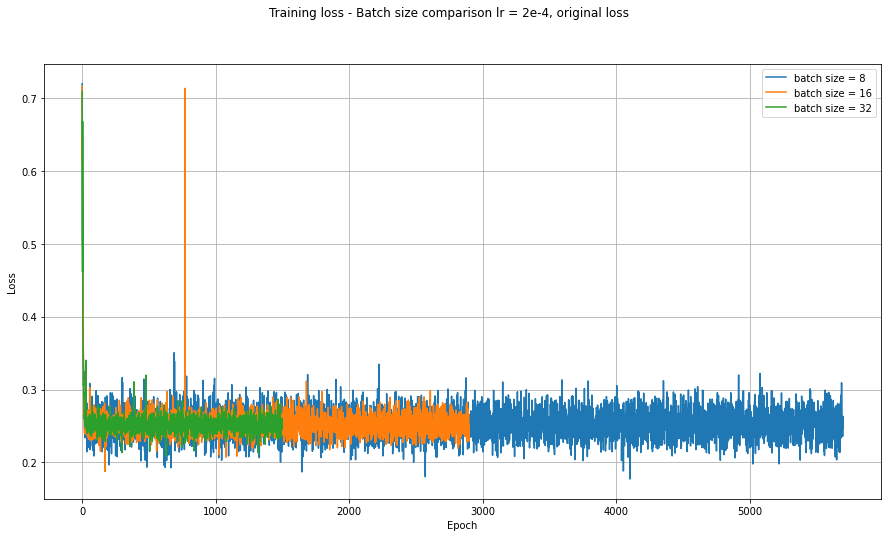

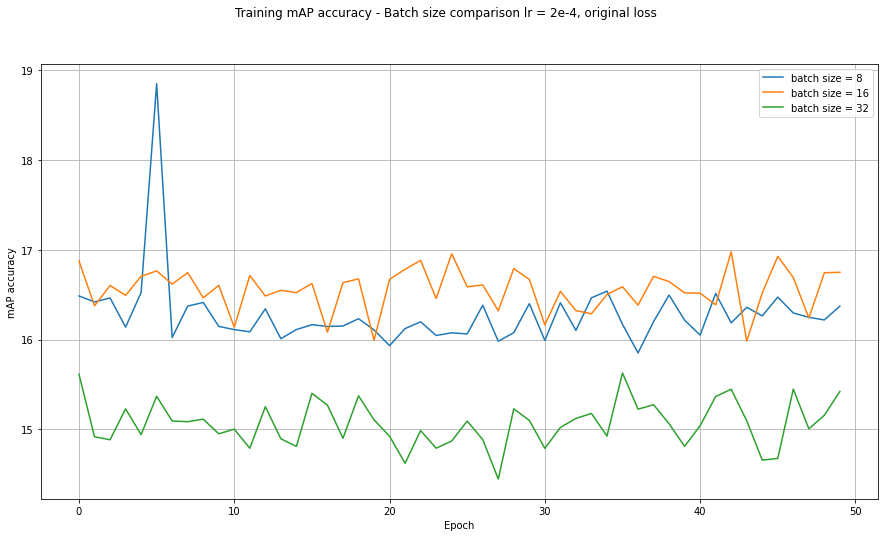

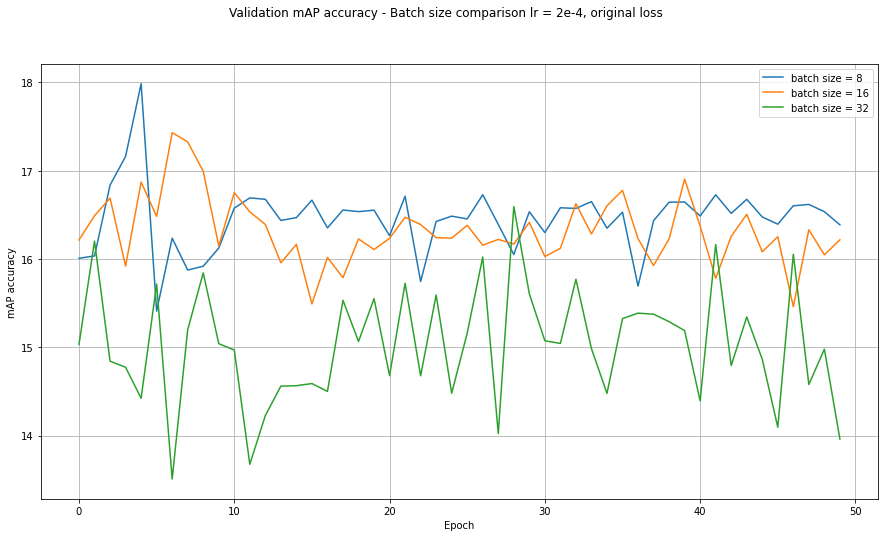

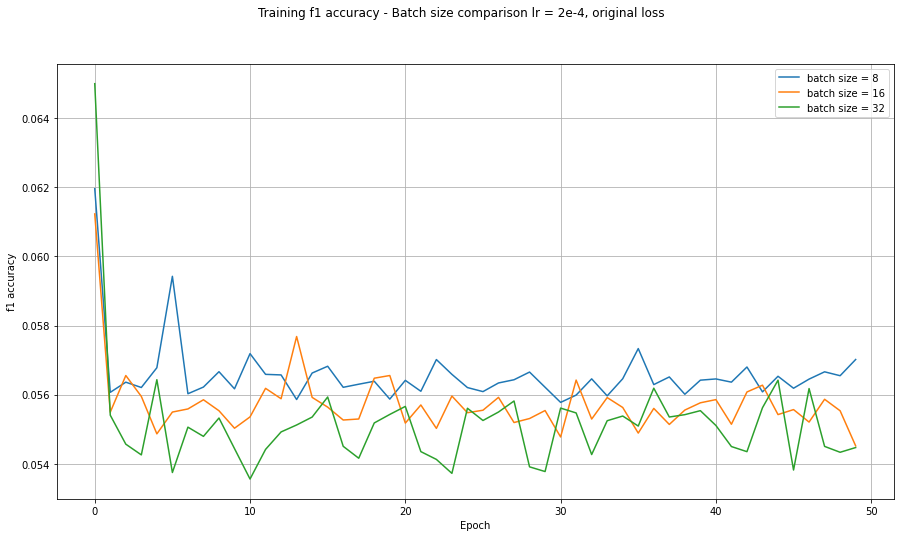

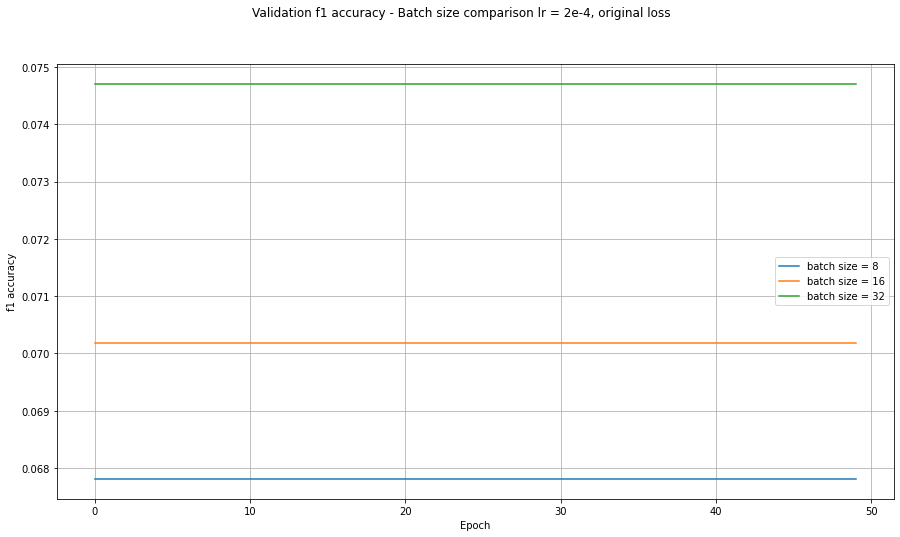

In [ ]:
## Add all combination of options as you'd like
combinations = [{'use_default_loss': 1, 'learning_rate': 2e-4, 'epochs': 50, 'batch_size': 8},
                {'use_default_loss': 1, 'learning_rate': 2e-4, 'epochs': 50, 'batch_size': 16},
                {'use_default_loss': 1, 'learning_rate': 2e-4, 'epochs': 50, 'batch_size': 32}]

labels = ['batch size = 8', 'batch size = 16', 'batch size = 32']
title = 'Batch size comparison lr = 2e-4, original loss'

combinations_results = []

for combination in combinations:

  use_default_loss = bool(combination['use_default_loss'])
  learning_rate = combination['learning_rate']
  epochs = combination['epochs']
  batch_size = combination['batch_size']

  results = train_and_plot_results(epochs, use_default_loss, learning_rate, batch_size, train_inputs, train_masks, train_labels,
                validation_inputs, validation_masks, validation_labels)
  combinations_results.append(results)

plot_results(combinations_results, labels, title)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a


Train loss: 0.37756752102264324
Train Acc mAP: 16.350223396259175
Train Acc f1: 0.07465299080049202
Validation Acc mAP: 18.49990597625146
Validation Acc f1: 0.06780772891573872


Epoch:   2%|▏         | 1/50 [00:38<31:42, 38.83s/it]


Train loss: 0.26376418185092787
Train Acc mAP: 16.56078177399336
Train Acc f1: 0.05680049350595744
Validation Acc mAP: 22.825778783081287
Validation Acc f1: 0.06780772891573872


Epoch:   4%|▍         | 2/50 [01:16<30:21, 37.96s/it]


Train loss: 0.24484151719608316
Train Acc mAP: 23.05297323253741
Train Acc f1: 0.05900314230669039
Validation Acc mAP: 33.271537343020256
Validation Acc f1: 0.07437572868951282


Epoch:   6%|▌         | 3/50 [01:55<30:03, 38.36s/it]


Train loss: 0.20424191296317407
Train Acc mAP: 35.85020005779349
Train Acc f1: 0.10609549255042246
Validation Acc mAP: 38.6300782451527
Validation Acc f1: 0.14492813917246095


Epoch:   8%|▊         | 4/50 [02:34<29:42, 38.75s/it]


Train loss: 0.16581753900743568
Train Acc mAP: 40.10693181629409
Train Acc f1: 0.24149574729731516
Validation Acc mAP: 39.168530458087076
Validation Acc f1: 0.3476871135778634


Epoch:  10%|█         | 5/50 [03:13<29:14, 38.99s/it]


Train loss: 0.14021861886213444
Train Acc mAP: 40.97801293580562
Train Acc f1: 0.41766055275541086
Validation Acc mAP: 40.31846194020469
Validation Acc f1: 0.5289130423987127


Epoch:  12%|█▏        | 6/50 [03:52<28:38, 39.07s/it]


Train loss: 0.12114561636777928
Train Acc mAP: 40.857016714304876
Train Acc f1: 0.5757666873602293
Validation Acc mAP: 40.246693166955964
Validation Acc f1: 0.6582163096223089


Epoch:  14%|█▍        | 7/50 [04:30<27:35, 38.50s/it]


Train loss: 0.1071067990352362
Train Acc mAP: 40.63237668742481
Train Acc f1: 0.6730893274133579
Validation Acc mAP: 40.274422011019276
Validation Acc f1: 0.7360273358206564


Epoch:  16%|█▌        | 8/50 [05:07<26:43, 38.19s/it]


Train loss: 0.09655422111447046
Train Acc mAP: 41.579386903121915
Train Acc f1: 0.7331754005773006
Validation Acc mAP: 40.259742034743745
Validation Acc f1: 0.74711674025629


Epoch:  18%|█▊        | 9/50 [05:45<26:02, 38.11s/it]


Train loss: 0.08866376547176787
Train Acc mAP: 40.924897901892585
Train Acc f1: 0.7572422983374094
Validation Acc mAP: 40.32335526583104
Validation Acc f1: 0.8002168684511847


Epoch:  20%|██        | 10/50 [06:25<25:38, 38.46s/it]


Train loss: 0.08252109078203346
Train Acc mAP: 40.32268889970132
Train Acc f1: 0.7859203506616492
Validation Acc mAP: 40.18144882751141
Validation Acc f1: 0.8131188830647331


Epoch:  22%|██▏       | 11/50 [07:02<24:48, 38.18s/it]


Train loss: 0.07706986470717125
Train Acc mAP: 39.873978725217974
Train Acc f1: 0.7911070172944545
Validation Acc mAP: 40.24506205845191
Validation Acc f1: 0.8378735148880738


Epoch:  24%|██▍       | 12/50 [07:39<24:01, 37.93s/it]


Train loss: 0.07363452613685131
Train Acc mAP: 42.13526689455665
Train Acc f1: 0.8068073079332979


Epoch:  26%|██▌       | 13/50 [08:15<22:59, 37.27s/it]

Validation Acc mAP: 40.142302223919714
Validation Acc f1: 0.8377235601670312

Train loss: 0.06985438739422009
Train Acc mAP: 41.5900374380582
Train Acc f1: 0.8206282896363115
Validation Acc mAP: 40.20591545490914
Validation Acc f1: 0.856554109208141


Epoch:  28%|██▊       | 14/50 [08:52<22:21, 37.25s/it]


Train loss: 0.0673917954903794
Train Acc mAP: 41.99113025098699
Train Acc f1: 0.8304054859964753
Validation Acc mAP: 40.17329328520317
Validation Acc f1: 0.8599451902908517


Epoch:  30%|███       | 15/50 [09:30<21:45, 37.29s/it]


Train loss: 0.06692828621014792
Train Acc mAP: 41.659202685475876
Train Acc f1: 0.8271487837295286


Epoch:  32%|███▏      | 16/50 [10:06<20:52, 36.83s/it]

Validation Acc mAP: 40.191235478503124
Validation Acc f1: 0.8570415165895273

Train loss: 0.06434466273623915
Train Acc mAP: 41.3479475254561
Train Acc f1: 0.8341601844927308


Epoch:  34%|███▍      | 17/50 [10:41<20:04, 36.49s/it]

Validation Acc mAP: 40.11783559650567
Validation Acc f1: 0.8591121668652028

Train loss: 0.06165780560262486
Train Acc mAP: 41.13669637471667
Train Acc f1: 0.8431340485185768
Validation Acc mAP: 40.196128803982674
Validation Acc f1: 0.8600903986126652


Epoch:  36%|███▌      | 18/50 [11:18<19:34, 36.71s/it]


Train loss: 0.059929372917635934
Train Acc mAP: 40.70538300753153
Train Acc f1: 0.8454084055351877
Validation Acc mAP: 40.16676885126851
Validation Acc f1: 0.8770739354615602


Epoch:  38%|███▊      | 19/50 [11:56<19:06, 36.98s/it]


Train loss: 0.058437427731502824
Train Acc mAP: 41.87383547106387
Train Acc f1: 0.8559124987895299
Validation Acc mAP: 40.000395785746875
Validation Acc f1: 0.8898292063622455


Epoch:  40%|████      | 20/50 [12:33<18:32, 37.10s/it]


Train loss: 0.05720694765050543
Train Acc mAP: 40.805378557012794
Train Acc f1: 0.8549794726868104
Validation Acc mAP: 40.17166217663387
Validation Acc f1: 0.8933370098288346


Epoch:  42%|████▏     | 21/50 [13:11<17:57, 37.14s/it]


Train loss: 0.05624928413681
Train Acc mAP: 41.21807152468971
Train Acc f1: 0.8588938864610429


Epoch:  44%|████▍     | 22/50 [13:47<17:08, 36.74s/it]

Validation Acc mAP: 40.0640090165732
Validation Acc f1: 0.876990318649738

Train loss: 0.05524335775549003
Train Acc mAP: 41.85093532256246
Train Acc f1: 0.860051401420891


Epoch:  46%|████▌     | 23/50 [14:22<16:23, 36.41s/it]

Validation Acc mAP: 40.13251557309111
Validation Acc f1: 0.8856504443887835

Train loss: 0.054510602691288525
Train Acc mAP: 41.68279553018181
Train Acc f1: 0.8614957856329452
Validation Acc mAP: 40.11946670527886
Validation Acc f1: 0.8975213332373241


Epoch:  48%|████▊     | 24/50 [14:59<15:53, 36.67s/it]


Train loss: 0.0534136616300472
Train Acc mAP: 41.77638533592491
Train Acc f1: 0.862450765228424


Epoch:  50%|█████     | 25/50 [15:35<15:09, 36.39s/it]

Validation Acc mAP: 40.293995313035325
Validation Acc f1: 0.8887353768839671

Train loss: 0.05280455321641235
Train Acc mAP: 41.56264641103122
Train Acc f1: 0.8643446969960894


Epoch:  52%|█████▏    | 26/50 [16:11<14:27, 36.16s/it]

Validation Acc mAP: 40.15290442912811
Validation Acc f1: 0.8816200304428948

Train loss: 0.05198940522595476
Train Acc mAP: 40.73616907969474
Train Acc f1: 0.8698206482429419
Validation Acc mAP: 40.12762224762787
Validation Acc f1: 0.9103464137091135


Epoch:  54%|█████▍    | 27/50 [16:49<14:03, 36.69s/it]


Train loss: 0.0512424146299942
Train Acc mAP: 41.662512824319556
Train Acc f1: 0.8701028204126888


Epoch:  56%|█████▌    | 28/50 [17:24<13:20, 36.40s/it]

Validation Acc mAP: 40.29562642158831
Validation Acc f1: 0.9091609070291964

Train loss: 0.05047119329216581
Train Acc mAP: 41.43679461754249
Train Acc f1: 0.8756241957413027


Epoch:  58%|█████▊    | 29/50 [18:00<12:40, 36.19s/it]

Validation Acc mAP: 40.18634215299095
Validation Acc f1: 0.9005368477323233

Train loss: 0.05006552278514104
Train Acc mAP: 40.99074711393109
Train Acc f1: 0.8747326103543126
Validation Acc mAP: 40.08684453535813
Validation Acc f1: 0.9122638186659511


Epoch:  60%|██████    | 30/50 [18:37<12:10, 36.54s/it]


Train loss: 0.04953060888622028
Train Acc mAP: 41.69680250529032
Train Acc f1: 0.8815846225256312


Epoch:  62%|██████▏   | 31/50 [19:13<11:30, 36.33s/it]

Validation Acc mAP: 40.16676885105645
Validation Acc f1: 0.9029015817082547

Train loss: 0.04874218438994329
Train Acc mAP: 40.92003946279031
Train Acc f1: 0.8772905244737433


Epoch:  64%|██████▍   | 32/50 [19:49<10:50, 36.13s/it]

Validation Acc mAP: 40.236090961905234
Validation Acc f1: 0.8831913274327531

Train loss: 0.048351546507458425
Train Acc mAP: 41.400213736209274
Train Acc f1: 0.8780128142643341


Epoch:  66%|██████▌   | 33/50 [20:25<10:11, 35.98s/it]

Validation Acc mAP: 40.042804606189016
Validation Acc f1: 0.907255223844295

Train loss: 0.047893069144828736
Train Acc mAP: 42.05207387999653
Train Acc f1: 0.883282596826799


Epoch:  68%|██████▊   | 34/50 [21:00<09:34, 35.89s/it]

Validation Acc mAP: 40.29888863827019
Validation Acc f1: 0.9085466259525968

Train loss: 0.04718934927395002
Train Acc mAP: 41.706288273250735
Train Acc f1: 0.8835257462747219


Epoch:  70%|███████   | 35/50 [21:36<08:57, 35.81s/it]

Validation Acc mAP: 40.3184619402047
Validation Acc f1: 0.908340373483186

Train loss: 0.04701388008101758
Train Acc mAP: 41.569267495073035
Train Acc f1: 0.8855789152148348


Epoch:  72%|███████▏  | 36/50 [22:12<08:20, 35.77s/it]

Validation Acc mAP: 40.22499942401676
Validation Acc f1: 0.8923974086694165

Train loss: 0.046381078053721166
Train Acc mAP: 42.013006715849954
Train Acc f1: 0.8869732199073215


Epoch:  74%|███████▍  | 37/50 [22:47<07:44, 35.73s/it]

Validation Acc mAP: 40.18911503725918
Validation Acc f1: 0.911963795905257

Train loss: 0.045975897761911945
Train Acc mAP: 41.91585352362315
Train Acc f1: 0.8873700868062431


Epoch:  76%|███████▌  | 38/50 [23:23<07:08, 35.69s/it]

Validation Acc mAP: 40.272301570264666
Validation Acc f1: 0.9024354710035921

Train loss: 0.045100377278453285
Train Acc mAP: 41.63276741096315
Train Acc f1: 0.8930576891347858


Epoch:  78%|███████▊  | 39/50 [23:59<06:32, 35.69s/it]

Validation Acc mAP: 40.26903935318587
Validation Acc f1: 0.8932453882904036

Train loss: 0.044252158160267265
Train Acc mAP: 41.094452229311585
Train Acc f1: 0.8916497913317625
Validation Acc mAP: 40.195639471286285
Validation Acc f1: 0.9200755674924659


Epoch:  80%|████████  | 40/50 [24:36<06:01, 36.13s/it]


Train loss: 0.04381364649026686
Train Acc mAP: 42.20519239334499
Train Acc f1: 0.9010661830218608


Epoch:  82%|████████▏ | 41/50 [25:11<05:24, 36.02s/it]

Validation Acc mAP: 40.30329263149376
Validation Acc f1: 0.9195353618532138

Train loss: 0.04277237074452475
Train Acc mAP: 42.40994845074682
Train Acc f1: 0.8998971608453694


Epoch:  84%|████████▍ | 42/50 [25:47<04:47, 35.90s/it]

Validation Acc mAP: 40.13202624049258
Validation Acc f1: 0.9026627539551147

Train loss: 0.04236085806529065
Train Acc mAP: 41.68677592780324
Train Acc f1: 0.8991997305749492
Validation Acc mAP: 40.30818595687544
Validation Acc f1: 0.9208507206326941


Epoch:  86%|████████▌ | 43/50 [26:24<04:14, 36.29s/it]


Train loss: 0.041626870167114416
Train Acc mAP: 41.31602143006308
Train Acc f1: 0.9027615603087054


Epoch:  88%|████████▊ | 44/50 [27:00<03:36, 36.14s/it]

Validation Acc mAP: 40.23478607512265
Validation Acc f1: 0.8998070169688203

Train loss: 0.040998804773867956
Train Acc mAP: 41.93134989902966
Train Acc f1: 0.9076017908164593


Epoch:  90%|█████████ | 45/50 [27:36<02:59, 35.99s/it]

Validation Acc mAP: 40.244572726081735
Validation Acc f1: 0.9128324601134759

Train loss: 0.04030648787882758
Train Acc mAP: 42.47207790836718
Train Acc f1: 0.908756868522892
Validation Acc mAP: 40.33265258427317
Validation Acc f1: 0.9183895604001194


Epoch:  92%|█████████▏| 46/50 [28:13<02:25, 36.37s/it]


Train loss: 0.03980425304058352
Train Acc mAP: 41.935733395195264
Train Acc f1: 0.9113609069392121


Epoch:  94%|█████████▍| 47/50 [28:49<01:48, 36.18s/it]

Validation Acc mAP: 40.20053279691263
Validation Acc f1: 0.9050489299430748

Train loss: 0.03883214957480718
Train Acc mAP: 41.705633107662166
Train Acc f1: 0.913279044012887
Validation Acc mAP: 40.33405067727198
Validation Acc f1: 0.9000754575564518


Epoch:  96%|█████████▌| 48/50 [29:26<01:13, 36.56s/it]


Train loss: 0.039023302033731506
Train Acc mAP: 42.41350253539082
Train Acc f1: 0.9144211577875877


Epoch:  98%|█████████▊| 49/50 [30:02<00:36, 36.33s/it]

Validation Acc mAP: 40.213581664803705
Validation Acc f1: 0.9096306561854135

Train loss: 0.03740985806013805
Train Acc mAP: 42.75838382444029
Train Acc f1: 0.9224372927064934


Epoch: 100%|██████████| 50/50 [30:38<00:00, 36.76s/it]

Validation Acc mAP: 40.23364429910838
Validation Acc f1: 0.9143670322996879



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions 


Train loss: 0.43416829252778494
Train Acc mAP: 17.33352869910801
Train Acc f1: 0.08409930925197427
Validation Acc mAP: 16.594855417740952
Validation Acc f1: 0.0701737564465745


Epoch:   2%|▏         | 1/50 [00:37<30:44, 37.65s/it]


Train loss: 0.29581435898316266
Train Acc mAP: 16.787585442532826
Train Acc f1: 0.054981940879619405
Validation Acc mAP: 19.075537886758248
Validation Acc f1: 0.0701737564465745


Epoch:   4%|▍         | 2/50 [01:13<29:19, 36.66s/it]


Train loss: 0.26516116153025265
Train Acc mAP: 16.900662226930944
Train Acc f1: 0.05624677757434838
Validation Acc mAP: 21.569386151601133
Validation Acc f1: 0.0701737564465745


Epoch:   6%|▌         | 3/50 [01:50<28:39, 36.58s/it]


Train loss: 0.25542937187868087
Train Acc mAP: 17.313819640999963
Train Acc f1: 0.054766254991205236
Validation Acc mAP: 24.69612718649385
Validation Acc f1: 0.0701737564465745


Epoch:   8%|▊         | 4/50 [02:26<27:59, 36.50s/it]


Train loss: 0.25043156649945425
Train Acc mAP: 20.57274889022508
Train Acc f1: 0.05492561871107014
Validation Acc mAP: 32.01191897750813
Validation Acc f1: 0.0701737564465745


Epoch:  10%|█         | 5/50 [03:02<27:14, 36.32s/it]


Train loss: 0.23322379984215494
Train Acc mAP: 34.29616398427091
Train Acc f1: 0.06068165003358394
Validation Acc mAP: 46.12186049195693
Validation Acc f1: 0.07872330337755876


Epoch:  12%|█▏        | 6/50 [03:40<27:02, 36.88s/it]


Train loss: 0.20538112308511758
Train Acc mAP: 48.37058858288566
Train Acc f1: 0.09088508173591574
Validation Acc mAP: 50.44648469830456
Validation Acc f1: 0.1121534135812805


Epoch:  14%|█▍        | 7/50 [04:18<26:43, 37.30s/it]


Train loss: 0.17837362801646756
Train Acc mAP: 54.88446166292917
Train Acc f1: 0.16677999104089966
Validation Acc mAP: 52.509402376391854
Validation Acc f1: 0.30862557989249934


Epoch:  16%|█▌        | 8/50 [04:57<26:22, 37.67s/it]


Train loss: 0.15822916250281613
Train Acc mAP: 56.58000411069681
Train Acc f1: 0.29489054516889607
Validation Acc mAP: 54.35522190648523
Validation Acc f1: 0.3816916623157361


Epoch:  18%|█▊        | 9/50 [05:35<25:53, 37.89s/it]


Train loss: 0.14168845973725203
Train Acc mAP: 58.323837110234734
Train Acc f1: 0.418017005717442
Validation Acc mAP: 54.71405245882032
Validation Acc f1: 0.47665594528712224


Epoch:  20%|██        | 10/50 [06:13<25:23, 38.08s/it]


Train loss: 0.12844950365470914
Train Acc mAP: 60.619058865501
Train Acc f1: 0.5361466227364976
Validation Acc mAP: 55.15507665568281
Validation Acc f1: 0.6366226314521605


Epoch:  22%|██▏       | 11/50 [06:52<24:45, 38.10s/it]


Train loss: 0.1183030508969543
Train Acc mAP: 59.148664453715185
Train Acc f1: 0.6199078862605506
Validation Acc mAP: 55.16421933621721
Validation Acc f1: 0.7014617031744139


Epoch:  24%|██▍       | 12/50 [07:30<24:09, 38.15s/it]


Train loss: 0.10980325466451087
Train Acc mAP: 59.10054777680668
Train Acc f1: 0.6724243757068264
Validation Acc mAP: 55.350416875744585
Validation Acc f1: 0.7127643378516088


Epoch:  26%|██▌       | 13/50 [08:08<23:33, 38.20s/it]


Train loss: 0.10310088685483104
Train Acc mAP: 58.27795716135369
Train Acc f1: 0.7058373054802548
Validation Acc mAP: 55.598811396317906
Validation Acc f1: 0.7260438944476182


Epoch:  28%|██▊       | 14/50 [08:47<22:59, 38.32s/it]


Train loss: 0.09727855421571713
Train Acc mAP: 59.02340744190222
Train Acc f1: 0.731171900075123
Validation Acc mAP: 55.33224166665395
Validation Acc f1: 0.7372207424478895


Epoch:  30%|███       | 15/50 [09:23<22:02, 37.78s/it]


Train loss: 0.09222255580208964
Train Acc mAP: 60.24891850748229
Train Acc f1: 0.7471709165912627
Validation Acc mAP: 55.501876949742915
Validation Acc f1: 0.770055987594067


Epoch:  32%|███▏      | 16/50 [10:00<21:08, 37.30s/it]


Train loss: 0.0876743586264047
Train Acc mAP: 59.80591107308319
Train Acc f1: 0.7633344773638625
Validation Acc mAP: 55.692716642733345
Validation Acc f1: 0.7774990409915945


Epoch:  34%|███▍      | 17/50 [10:38<20:42, 37.66s/it]


Train loss: 0.08378620246203752
Train Acc mAP: 60.75260665640788
Train Acc f1: 0.7761232428617858
Validation Acc mAP: 55.54731497140171
Validation Acc f1: 0.8049377981998999


Epoch:  36%|███▌      | 18/50 [11:15<19:55, 37.37s/it]


Train loss: 0.08050086522178918
Train Acc mAP: 59.357783382960974
Train Acc f1: 0.7863371986558291
Validation Acc mAP: 55.61859955678852
Validation Acc f1: 0.8406011903061418


Epoch:  38%|███▊      | 19/50 [11:51<19:07, 37.03s/it]


Train loss: 0.07780880450438482
Train Acc mAP: 58.96529692918988
Train Acc f1: 0.7999775912882555
Validation Acc mAP: 55.592752993696635
Validation Acc f1: 0.843062704229294


Epoch:  40%|████      | 20/50 [12:27<18:22, 36.74s/it]


Train loss: 0.07524826723330205
Train Acc mAP: 60.45798772570715
Train Acc f1: 0.8104735706938221


Epoch:  42%|████▏     | 21/50 [13:01<17:25, 36.06s/it]

Validation Acc mAP: 55.31103725685852
Validation Acc f1: 0.8114374914755355

Train loss: 0.07288314694706152
Train Acc mAP: 59.80104097775055
Train Acc f1: 0.8079303107007864


Epoch:  44%|████▍     | 22/50 [13:36<16:34, 35.53s/it]

Validation Acc mAP: 55.50490615126561
Validation Acc f1: 0.8424889886250234

Train loss: 0.0704983479994759
Train Acc mAP: 60.85765085761381
Train Acc f1: 0.8191103928797053
Validation Acc mAP: 55.444322121720795
Validation Acc f1: 0.8458292290952297


Epoch:  46%|████▌     | 23/50 [14:12<16:03, 35.69s/it]


Train loss: 0.0685854739694346
Train Acc mAP: 61.493844770134515
Train Acc f1: 0.824278776285167
Validation Acc mAP: 55.60865630159793
Validation Acc f1: 0.8496320885868969


Epoch:  48%|████▊     | 24/50 [14:48<15:31, 35.83s/it]


Train loss: 0.06709107043525428
Train Acc mAP: 59.88890699282796
Train Acc f1: 0.8264161757363047
Validation Acc mAP: 55.33527086816148
Validation Acc f1: 0.8513234613962821


Epoch:  50%|█████     | 25/50 [15:24<14:58, 35.93s/it]


Train loss: 0.06537760643598271
Train Acc mAP: 60.07957836187248
Train Acc f1: 0.8302718096556546


Epoch:  52%|█████▏    | 26/50 [15:59<14:11, 35.48s/it]

Validation Acc mAP: 55.513993756121415
Validation Acc f1: 0.8414026413116963

Train loss: 0.06413830753022715
Train Acc mAP: 59.39882245433006
Train Acc f1: 0.8315678842444499
Validation Acc mAP: 55.64727862083222
Validation Acc f1: 0.8639196962604127


Epoch:  54%|█████▍    | 27/50 [16:35<13:39, 35.65s/it]


Train loss: 0.0626185365741033
Train Acc mAP: 60.39280277734426
Train Acc f1: 0.8372271752302762
Validation Acc mAP: 55.4178166097283
Validation Acc f1: 0.8659298215150925


Epoch:  56%|█████▌    | 28/50 [17:11<13:08, 35.83s/it]


Train loss: 0.06136431077081531
Train Acc mAP: 60.4326308537024
Train Acc f1: 0.844260336041885


Epoch:  58%|█████▊    | 29/50 [17:45<12:23, 35.40s/it]

Validation Acc mAP: 55.58224914006127
Validation Acc f1: 0.8630843326974312

Train loss: 0.06077361212890382
Train Acc mAP: 60.234994502534825
Train Acc f1: 0.8470031083783116


Epoch:  60%|██████    | 30/50 [18:20<11:41, 35.06s/it]

Validation Acc mAP: 55.380049941146865
Validation Acc f1: 0.855148665424608

Train loss: 0.05939971836944219
Train Acc mAP: 60.381023399431164
Train Acc f1: 0.8479685464627297


Epoch:  62%|██████▏   | 31/50 [18:54<11:01, 34.82s/it]

Validation Acc mAP: 55.6480359206809
Validation Acc f1: 0.8642205293845315

Train loss: 0.05865728275565564
Train Acc mAP: 61.65415490228151
Train Acc f1: 0.8511107055839624
Validation Acc mAP: 55.73887262510534
Validation Acc f1: 0.8753923419543181


Epoch:  64%|██████▍   | 32/50 [19:32<10:45, 35.88s/it]


Train loss: 0.057565548880626656
Train Acc mAP: 59.79223335059102
Train Acc f1: 0.8537194275953413
Validation Acc mAP: 55.844894676490696
Validation Acc f1: 0.8878533855790677


Epoch:  66%|██████▌   | 33/50 [20:11<10:24, 36.73s/it]


Train loss: 0.056779940671504894
Train Acc mAP: 59.76289951454243
Train Acc f1: 0.8566317730597918


Epoch:  68%|██████▊   | 34/50 [20:45<09:35, 36.00s/it]

Validation Acc mAP: 55.64661967129549
Validation Acc f1: 0.8655703842159028

Train loss: 0.055867215690885826
Train Acc mAP: 61.43037294779894
Train Acc f1: 0.858899097715136


Epoch:  70%|███████   | 35/50 [21:19<08:51, 35.43s/it]

Validation Acc mAP: 55.60562710081741
Validation Acc f1: 0.8716362490658661

Train loss: 0.055417229230902094
Train Acc mAP: 59.76206953826715
Train Acc f1: 0.8574117984720816


Epoch:  72%|███████▏  | 36/50 [21:53<08:10, 35.05s/it]

Validation Acc mAP: 55.35113483645778
Validation Acc f1: 0.8766198766867619

Train loss: 0.05485822848571538
Train Acc mAP: 61.96444105093722
Train Acc f1: 0.8648142950098926
Validation Acc mAP: 55.68131779712865
Validation Acc f1: 0.8891453753504959


Epoch:  74%|███████▍  | 37/50 [22:29<07:39, 35.34s/it]


Train loss: 0.0536662124386195
Train Acc mAP: 60.29738106619763
Train Acc f1: 0.8652226289977122


Epoch:  76%|███████▌  | 38/50 [23:04<07:01, 35.09s/it]

Validation Acc mAP: 55.5792199386749
Validation Acc f1: 0.884784907896945

Train loss: 0.053012909777243794
Train Acc mAP: 61.61416350796863
Train Acc f1: 0.8676109088329315


Epoch:  78%|███████▊  | 39/50 [23:38<06:23, 34.85s/it]

Validation Acc mAP: 55.271657638502575
Validation Acc f1: 0.8831918345178222

Train loss: 0.052752921434028106
Train Acc mAP: 61.593320119126005
Train Acc f1: 0.8668343137776733


Epoch:  80%|████████  | 40/50 [24:13<05:46, 34.68s/it]

Validation Acc mAP: 55.81767120410308
Validation Acc f1: 0.8804198702707046

Train loss: 0.051947258675937864
Train Acc mAP: 61.70195723691204
Train Acc f1: 0.8721736120011544


Epoch:  82%|████████▏ | 41/50 [24:47<05:11, 34.58s/it]

Validation Acc mAP: 55.66545382987742
Validation Acc f1: 0.8878422791783197

Train loss: 0.05141265060484641
Train Acc mAP: 61.6079138477833
Train Acc f1: 0.8721991367948937


Epoch:  84%|████████▍ | 42/50 [25:21<04:36, 34.51s/it]

Validation Acc mAP: 55.83205991098934
Validation Acc f1: 0.8883490771880796

Train loss: 0.05079441366807318
Train Acc mAP: 61.21734345200933
Train Acc f1: 0.8736327805877001
Validation Acc mAP: 55.45340972700068
Validation Acc f1: 0.8959100634122142


Epoch:  86%|████████▌ | 43/50 [25:57<04:05, 35.02s/it]


Train loss: 0.05028789138702954
Train Acc mAP: 60.91812310389921
Train Acc f1: 0.8756946387588583


Epoch:  88%|████████▊ | 44/50 [26:32<03:29, 34.84s/it]

Validation Acc mAP: 55.635161815089866
Validation Acc f1: 0.8855638801625855

Train loss: 0.04977049578942258
Train Acc mAP: 60.34606917817504
Train Acc f1: 0.8790682882889507


Epoch:  90%|█████████ | 45/50 [27:06<02:53, 34.68s/it]

Validation Acc mAP: 55.64122021811251
Validation Acc f1: 0.8902075163909584

Train loss: 0.048938823287427005
Train Acc mAP: 61.21105074025807
Train Acc f1: 0.8821200822656197


Epoch:  92%|█████████▏| 46/50 [27:40<02:18, 34.58s/it]

Validation Acc mAP: 55.47764333903066
Validation Acc f1: 0.8829117855993152

Train loss: 0.0485834070867834
Train Acc mAP: 62.051727221122185
Train Acc f1: 0.8812488544706485
Validation Acc mAP: 55.86699407901276
Validation Acc f1: 0.8951725821173515


Epoch:  94%|█████████▍| 47/50 [28:17<01:45, 35.13s/it]


Train loss: 0.04795244175417708
Train Acc mAP: 60.093233622807354
Train Acc f1: 0.880603547123898


Epoch:  96%|█████████▌| 48/50 [28:51<01:09, 34.91s/it]

Validation Acc mAP: 55.72765081112028
Validation Acc f1: 0.8796721681689256

Train loss: 0.04720612632907185
Train Acc mAP: 62.10155644702956
Train Acc f1: 0.8837004661443401


Epoch:  98%|█████████▊| 49/50 [29:26<00:34, 34.70s/it]

Validation Acc mAP: 55.83887561445891
Validation Acc f1: 0.8883242203528086

Train loss: 0.04683928391542415
Train Acc mAP: 59.437247384876635
Train Acc f1: 0.8868703286783799
Validation Acc mAP: 55.8895753993459
Validation Acc f1: 0.885200606645341


Epoch: 100%|██████████| 50/50 [30:02<00:00, 36.05s/it]
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a 


Train loss: 0.5065967712829698
Train Acc mAP: 15.78714291560013
Train Acc f1: 0.11027639599508715
Validation Acc mAP: 18.30252675980087
Validation Acc f1: 0.07470872822440135


Epoch:   2%|▏         | 1/50 [00:37<30:18, 37.12s/it]


Train loss: 0.3551958694343952
Train Acc mAP: 16.19643677012646
Train Acc f1: 0.05802390372793618
Validation Acc mAP: 19.521794179458194
Validation Acc f1: 0.07470872822440135


Epoch:   4%|▍         | 2/50 [01:12<29:01, 36.28s/it]


Train loss: 0.3041076797146233
Train Acc mAP: 15.676430804396713
Train Acc f1: 0.0566664053172509
Validation Acc mAP: 21.209100631455303
Validation Acc f1: 0.07470872822440135


Epoch:   6%|▌         | 3/50 [01:48<28:06, 35.89s/it]


Train loss: 0.2790098089214439
Train Acc mAP: 15.810393756073529
Train Acc f1: 0.055487954066114814
Validation Acc mAP: 23.309321051656845
Validation Acc f1: 0.07470872822440135


Epoch:   8%|▊         | 4/50 [02:23<27:18, 35.62s/it]


Train loss: 0.26527954824939914
Train Acc mAP: 16.426463538908035
Train Acc f1: 0.05426067537364482
Validation Acc mAP: 26.408844855724897
Validation Acc f1: 0.07470872822440135


Epoch:  10%|█         | 5/50 [02:58<26:37, 35.50s/it]


Train loss: 0.2578017668756676
Train Acc mAP: 18.26891634809089
Train Acc f1: 0.05668604143112988
Validation Acc mAP: 30.183209493964597
Validation Acc f1: 0.07470872822440135


Epoch:  12%|█▏        | 6/50 [03:33<25:57, 35.40s/it]


Train loss: 0.24888645146471516
Train Acc mAP: 25.280965513821535
Train Acc f1: 0.05863356732833543
Validation Acc mAP: 39.1003942942486
Validation Acc f1: 0.07939884748780492


Epoch:  14%|█▍        | 7/50 [04:11<25:45, 35.95s/it]


Train loss: 0.23557207239534841
Train Acc mAP: 36.039288924962676
Train Acc f1: 0.07677413746795804
Validation Acc mAP: 45.112277613598046
Validation Acc f1: 0.09982662349279034


Epoch:  16%|█▌        | 8/50 [04:48<25:25, 36.31s/it]


Train loss: 0.2198527384210598
Train Acc mAP: 46.077424676124494
Train Acc f1: 0.09541866493216322
Validation Acc mAP: 50.060343676100246
Validation Acc f1: 0.10607488488519873


Epoch:  18%|█▊        | 9/50 [05:25<24:58, 36.55s/it]


Train loss: 0.20431325283973825
Train Acc mAP: 54.69377272457041
Train Acc f1: 0.11941086329371126
Validation Acc mAP: 53.87311548213815
Validation Acc f1: 0.1414177188990291


Epoch:  20%|██        | 10/50 [06:02<24:29, 36.73s/it]


Train loss: 0.19052796972670136
Train Acc mAP: 58.57919665923889
Train Acc f1: 0.15453379423773908
Validation Acc mAP: 57.29876284617505
Validation Acc f1: 0.17744799179690435


Epoch:  22%|██▏       | 11/50 [06:39<23:58, 36.89s/it]


Train loss: 0.17763940570002565
Train Acc mAP: 64.63992249312346
Train Acc f1: 0.19474743315525622
Validation Acc mAP: 58.33889109608
Validation Acc f1: 0.19462046173284508


Epoch:  24%|██▍       | 12/50 [07:17<23:31, 37.14s/it]


Train loss: 0.1665887166347267
Train Acc mAP: 65.1919069602102
Train Acc f1: 0.2378601464906481
Validation Acc mAP: 59.186552640104935
Validation Acc f1: 0.23217071455475957


Epoch:  26%|██▌       | 13/50 [07:54<23:00, 37.30s/it]


Train loss: 0.1562341160590639
Train Acc mAP: 68.40567853235433
Train Acc f1: 0.3081481348149945
Validation Acc mAP: 60.54517948118136
Validation Acc f1: 0.3630520279778236


Epoch:  28%|██▊       | 14/50 [08:33<22:32, 37.56s/it]


Train loss: 0.14772973474039386
Train Acc mAP: 67.60653135207255
Train Acc f1: 0.3753990015688811
Validation Acc mAP: 62.468163029434095
Validation Acc f1: 0.39195847812994594


Epoch:  30%|███       | 15/50 [09:10<21:55, 37.60s/it]


Train loss: 0.1404300447771621
Train Acc mAP: 70.18623041623474
Train Acc f1: 0.42579147032624826
Validation Acc mAP: 62.91047343702553
Validation Acc f1: 0.5054140994627745


Epoch:  32%|███▏      | 16/50 [09:48<21:18, 37.61s/it]


Train loss: 0.13310842193301003
Train Acc mAP: 70.20644717068592
Train Acc f1: 0.5044557756095639
Validation Acc mAP: 62.53625346003223
Validation Acc f1: 0.5408329092316029


Epoch:  34%|███▍      | 17/50 [10:23<20:20, 37.00s/it]


Train loss: 0.12669543427665
Train Acc mAP: 70.88734987864274
Train Acc f1: 0.5496355939119209
Validation Acc mAP: 63.290274718977486
Validation Acc f1: 0.5798199376841333


Epoch:  36%|███▌      | 18/50 [11:01<19:46, 37.08s/it]


Train loss: 0.12138175844179974
Train Acc mAP: 72.02476422040307
Train Acc f1: 0.5864085706632242
Validation Acc mAP: 63.20699439786314
Validation Acc f1: 0.6085924660343849


Epoch:  38%|███▊      | 19/50 [11:36<18:55, 36.64s/it]


Train loss: 0.11582275374288115
Train Acc mAP: 72.2566213024715
Train Acc f1: 0.6257265245576511
Validation Acc mAP: 63.55237637729607
Validation Acc f1: 0.6255312776255012


Epoch:  40%|████      | 20/50 [12:15<18:32, 37.10s/it]


Train loss: 0.11137631856713921
Train Acc mAP: 71.11403863575458
Train Acc f1: 0.6494395861039391
Validation Acc mAP: 63.327783806555956
Validation Acc f1: 0.6824280538374095


Epoch:  42%|████▏     | 21/50 [12:50<17:44, 36.72s/it]


Train loss: 0.10736800420650891
Train Acc mAP: 71.40850580607952
Train Acc f1: 0.6722276971884343
Validation Acc mAP: 63.44499118436639
Validation Acc f1: 0.7090321500840234


Epoch:  44%|████▍     | 22/50 [13:26<16:56, 36.30s/it]


Train loss: 0.10447117554408485
Train Acc mAP: 72.58745782371605
Train Acc f1: 0.6888439622444236
Validation Acc mAP: 63.57725369471808
Validation Acc f1: 0.714058424762056


Epoch:  46%|████▌     | 23/50 [14:03<16:31, 36.71s/it]


Train loss: 0.10056591746754355
Train Acc mAP: 72.6033448056986
Train Acc f1: 0.7064848758879542
Validation Acc mAP: 63.48077362826889
Validation Acc f1: 0.7176471547727197


Epoch:  48%|████▊     | 24/50 [14:39<15:45, 36.36s/it]


Train loss: 0.0968836640082848
Train Acc mAP: 72.43950880406854
Train Acc f1: 0.7275080704575841
Validation Acc mAP: 63.65606594416232
Validation Acc f1: 0.7214102958926567


Epoch:  50%|█████     | 25/50 [15:16<15:17, 36.70s/it]


Train loss: 0.09417921296156236
Train Acc mAP: 74.30455563382554
Train Acc f1: 0.7291318001020233
Validation Acc mAP: 63.710932357082655
Validation Acc f1: 0.7347519810187548


Epoch:  52%|█████▏    | 26/50 [15:54<14:45, 36.91s/it]


Train loss: 0.09189652582114988
Train Acc mAP: 72.98712020868928
Train Acc f1: 0.741616642364113
Validation Acc mAP: 63.7336513675844
Validation Acc f1: 0.7599100458001592


Epoch:  54%|█████▍    | 27/50 [16:31<14:10, 36.97s/it]


Train loss: 0.08968793894243784
Train Acc mAP: 73.4221654737023
Train Acc f1: 0.7466405903822989


Epoch:  56%|█████▌    | 28/50 [17:05<13:11, 35.96s/it]

Validation Acc mAP: 63.54917299683328
Validation Acc f1: 0.7444445644461485

Train loss: 0.08678641701674795
Train Acc mAP: 73.14527137199448
Train Acc f1: 0.7576337183481973
Validation Acc mAP: 63.622956773771605
Validation Acc f1: 0.7804466272452966


Epoch:  58%|█████▊    | 29/50 [17:40<12:30, 35.74s/it]


Train loss: 0.08546094031917585
Train Acc mAP: 73.68166388605948
Train Acc f1: 0.7668963861865705


Epoch:  60%|██████    | 30/50 [18:13<11:41, 35.09s/it]

Validation Acc mAP: 63.51532167128191
Validation Acc f1: 0.7783744188100279

Train loss: 0.08327466368173413
Train Acc mAP: 73.20357093829244
Train Acc f1: 0.7684625944522864
Validation Acc mAP: 63.74664664261962
Validation Acc f1: 0.8217818370736762


Epoch:  62%|██████▏   | 31/50 [18:51<11:20, 35.82s/it]


Train loss: 0.08125588712545745
Train Acc mAP: 73.8002815518101
Train Acc f1: 0.7807826259930742


Epoch:  64%|██████▍   | 32/50 [19:24<10:32, 35.15s/it]

Validation Acc mAP: 63.45271565062096
Validation Acc f1: 0.807066306420681

Train loss: 0.0784811515090054
Train Acc mAP: 72.04659577165386
Train Acc f1: 0.7819630376653572


Epoch:  66%|██████▌   | 33/50 [19:58<09:49, 34.65s/it]

Validation Acc mAP: 63.678633496526245
Validation Acc f1: 0.8108484567341951

Train loss: 0.07763167548077679
Train Acc mAP: 73.7392047111172
Train Acc f1: 0.7912736541517645
Validation Acc mAP: 63.6473191263111
Validation Acc f1: 0.829700123160311


Epoch:  68%|██████▊   | 34/50 [20:33<09:17, 34.83s/it]


Train loss: 0.07568155168806341
Train Acc mAP: 74.59885192260717
Train Acc f1: 0.7949496713718252


Epoch:  70%|███████   | 35/50 [21:07<08:36, 34.46s/it]

Validation Acc mAP: 63.58448591514846
Validation Acc f1: 0.8084402154046804

Train loss: 0.07523320844121707
Train Acc mAP: 73.62902372040115
Train Acc f1: 0.7941126946458251
Validation Acc mAP: 63.771501240916734
Validation Acc f1: 0.8295484790056649


Epoch:  72%|███████▏  | 36/50 [21:42<08:07, 34.83s/it]


Train loss: 0.07342912280415777
Train Acc mAP: 74.07459341681178
Train Acc f1: 0.8013043371689226
Validation Acc mAP: 63.692954046670025
Validation Acc f1: 0.843708071011236


Epoch:  74%|███████▍  | 37/50 [22:18<07:34, 34.98s/it]


Train loss: 0.07244071504962818
Train Acc mAP: 73.35880383292653
Train Acc f1: 0.8079072322080826
Validation Acc mAP: 63.86596688863307
Validation Acc f1: 0.8302653095284325


Epoch:  76%|███████▌  | 38/50 [22:53<07:01, 35.09s/it]


Train loss: 0.0702984830193712
Train Acc mAP: 73.4746346931957
Train Acc f1: 0.8143009645746467
Validation Acc mAP: 63.74035347691674
Validation Acc f1: 0.8439403177195186


Epoch:  78%|███████▊  | 39/50 [23:29<06:28, 35.30s/it]


Train loss: 0.06936960564061768
Train Acc mAP: 74.47390065130644
Train Acc f1: 0.8120653233084884
Validation Acc mAP: 63.97417753933024
Validation Acc f1: 0.8317288776550089


Epoch:  80%|████████  | 40/50 [24:05<05:54, 35.42s/it]


Train loss: 0.0687576938925155
Train Acc mAP: 74.21536255549731
Train Acc f1: 0.8124949164409628
Validation Acc mAP: 64.19229519164318
Validation Acc f1: 0.8438807431742456


Epoch:  82%|████████▏ | 41/50 [24:40<05:18, 35.41s/it]


Train loss: 0.06746885355950695
Train Acc mAP: 74.24730703235568
Train Acc f1: 0.8140568126287183
Validation Acc mAP: 63.82218735526078
Validation Acc f1: 0.8464880823592816


Epoch:  84%|████████▍ | 42/50 [25:16<04:44, 35.54s/it]


Train loss: 0.06661227821886609
Train Acc mAP: 74.03533983652606
Train Acc f1: 0.8234683636180189


Epoch:  86%|████████▌ | 43/50 [25:49<04:04, 34.94s/it]

Validation Acc mAP: 63.928542617912456
Validation Acc f1: 0.837406387147096

Train loss: 0.06564447489499471
Train Acc mAP: 74.66542348033191
Train Acc f1: 0.8270461272430059
Validation Acc mAP: 63.71547615842617
Validation Acc f1: 0.8484366930219026


Epoch:  88%|████████▊ | 44/50 [26:25<03:30, 35.05s/it]


Train loss: 0.06463756034051762
Train Acc mAP: 75.05741795966287
Train Acc f1: 0.826390207972131
Validation Acc mAP: 63.747381222923664
Validation Acc f1: 0.8603003049913809


Epoch:  90%|█████████ | 45/50 [27:00<02:55, 35.16s/it]


Train loss: 0.06374721116362915
Train Acc mAP: 74.79521644640309
Train Acc f1: 0.8329534943605504


Epoch:  92%|█████████▏| 46/50 [27:34<02:18, 34.68s/it]

Validation Acc mAP: 63.74312519628781
Validation Acc f1: 0.8540852552376205

Train loss: 0.0632646825905986
Train Acc mAP: 75.14902966477699
Train Acc f1: 0.8311278463362718


Epoch:  94%|█████████▍| 47/50 [28:07<01:42, 34.32s/it]

Validation Acc mAP: 63.77119832137703
Validation Acc f1: 0.852680925075172

Train loss: 0.06282210537058802
Train Acc mAP: 74.7241450319136
Train Acc f1: 0.8329170142897588


Epoch:  96%|█████████▌| 48/50 [28:41<01:08, 34.09s/it]

Validation Acc mAP: 63.774454712371906
Validation Acc f1: 0.8515852933064393

Train loss: 0.06181344301537671
Train Acc mAP: 74.42549817625765
Train Acc f1: 0.8308898841872295


Epoch:  98%|█████████▊| 49/50 [29:14<00:33, 33.91s/it]

Validation Acc mAP: 63.77996785881179
Validation Acc f1: 0.8602951096452224

Train loss: 0.06120480335865848
Train Acc mAP: 75.24194282904732
Train Acc f1: 0.8356225070228273


Epoch: 100%|██████████| 50/50 [29:48<00:00, 35.76s/it]

Validation Acc mAP: 63.52000178750494
Validation Acc f1: 0.8513309152806825


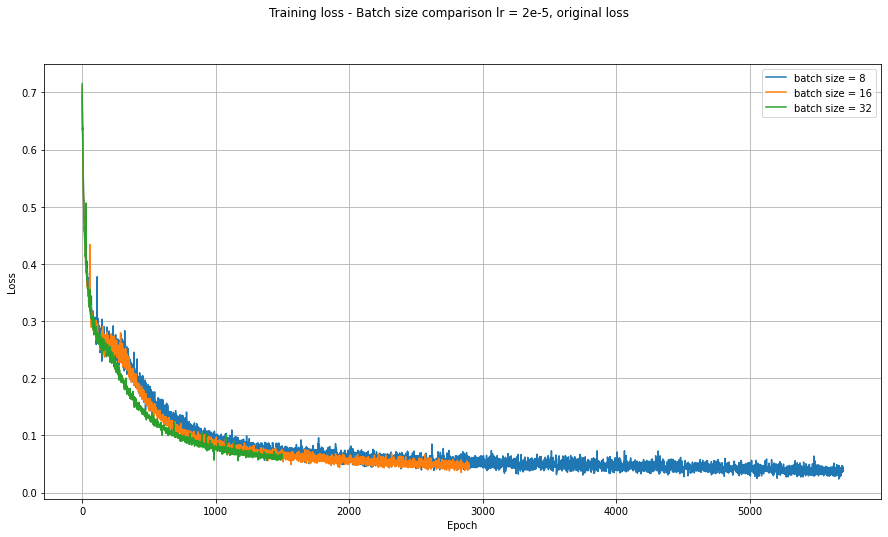

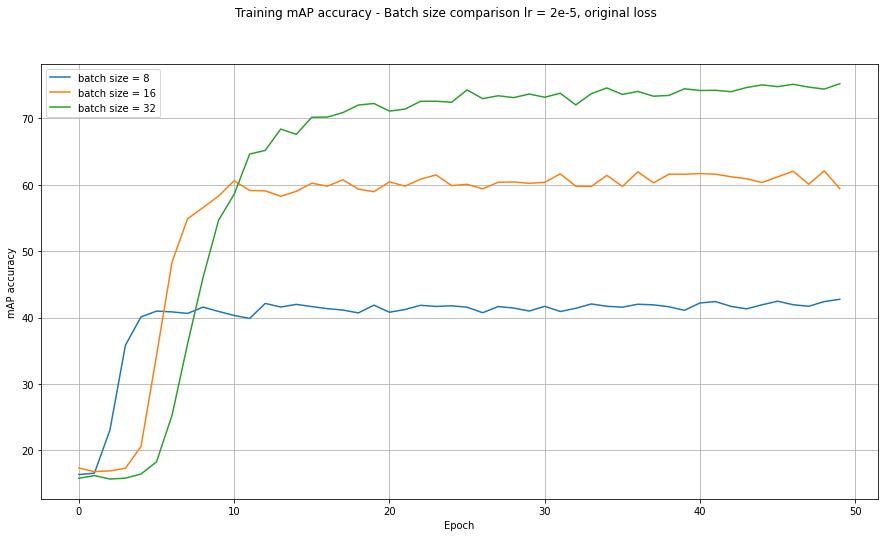

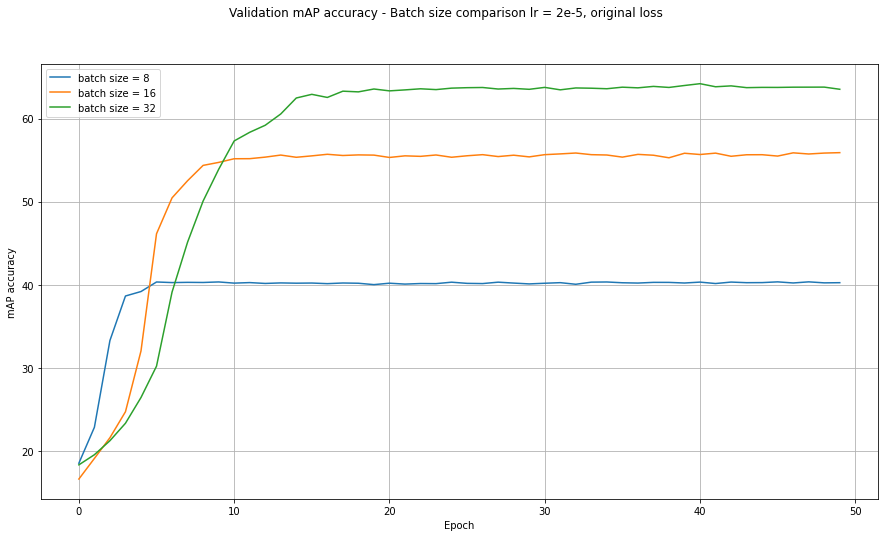

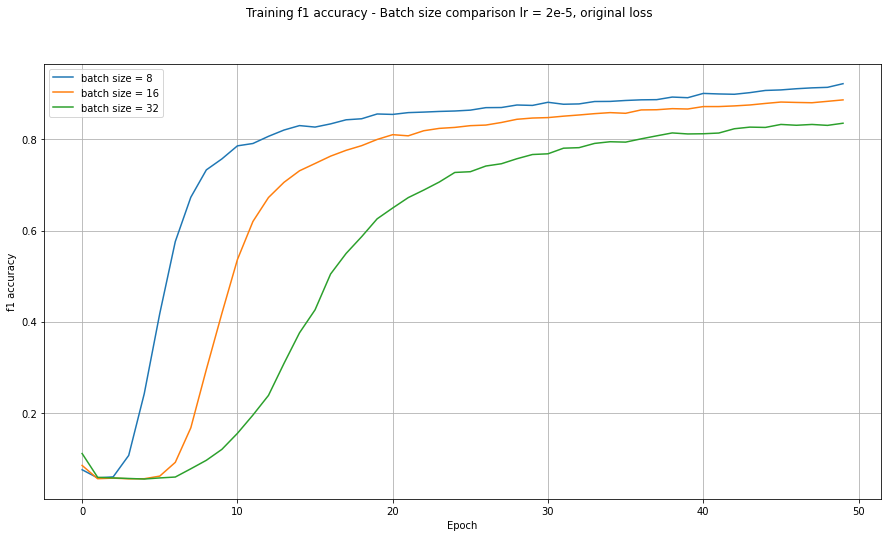

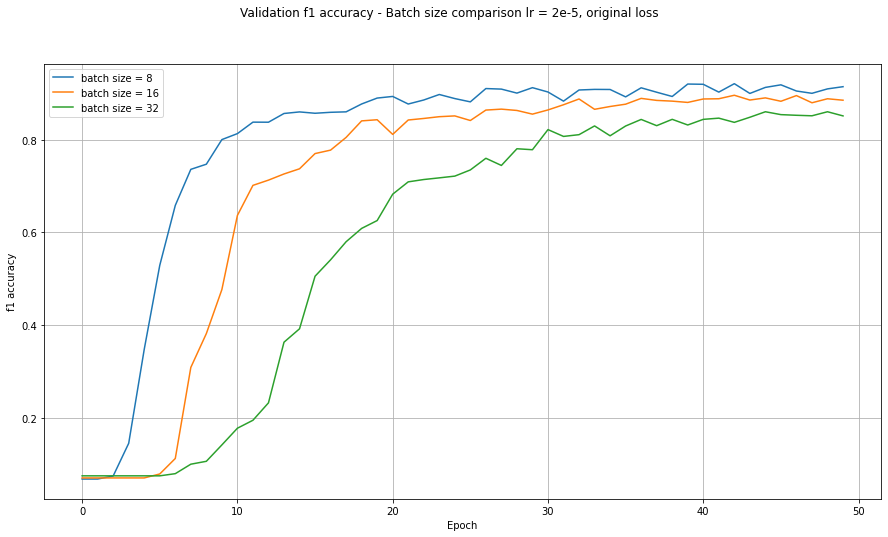

In [ ]:
## Add all combination of options as you'd like
combinations = [{'use_default_loss': 1, 'learning_rate': 2e-5, 'epochs': 50, 'batch_size': 8},
                {'use_default_loss': 1, 'learning_rate': 2e-5, 'epochs': 50, 'batch_size': 16},
                {'use_default_loss': 1, 'learning_rate': 2e-5, 'epochs': 50, 'batch_size': 32}]

labels = ['batch size = 8', 'batch size = 16', 'batch size = 32']
title = 'Batch size comparison lr = 2e-5, original loss'

combinations_results = []

for combination in combinations:

  use_default_loss = bool(combination['use_default_loss'])
  learning_rate = combination['learning_rate']
  epochs = combination['epochs']
  batch_size = combination['batch_size']

  results = train_and_plot_results(epochs, use_default_loss, learning_rate, batch_size, train_inputs, train_masks, train_labels,
                validation_inputs, validation_masks, validation_labels)
  combinations_results.append(results)

plot_results(combinations_results, labels, title)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a


Train loss: 0.5867896485986794
Train Acc mAP: 16.22171272189406
Train Acc f1: 0.18148649303919429
Validation Acc mAP: 17.02896302122481
Validation Acc f1: 0.0922091372185647


Epoch:   2%|▏         | 1/50 [00:39<31:53, 39.05s/it]


Train loss: 0.4468244651001172
Train Acc mAP: 16.548477203862376
Train Acc f1: 0.0816827266656457


Epoch:   4%|▍         | 2/50 [01:14<29:43, 37.15s/it]

Validation Acc mAP: 17.014236443237323
Validation Acc f1: 0.06780772891573872

Train loss: 0.39260027593202085
Train Acc mAP: 16.77869521364495
Train Acc f1: 0.05872371511465333
Validation Acc mAP: 17.224472346682912
Validation Acc f1: 0.06780772891573872


Epoch:   6%|▌         | 3/50 [01:52<29:09, 37.23s/it]


Train loss: 0.35970705339997894
Train Acc mAP: 16.74161813019828
Train Acc f1: 0.05650430735644638
Validation Acc mAP: 17.887086868480218
Validation Acc f1: 0.06780772891573872


Epoch:   8%|▊         | 4/50 [02:29<28:40, 37.41s/it]


Train loss: 0.33587092142734415
Train Acc mAP: 16.578201671999512
Train Acc f1: 0.05663955511056961
Validation Acc mAP: 18.29937750071233
Validation Acc f1: 0.06780772891573872


Epoch:  10%|█         | 5/50 [03:07<28:04, 37.43s/it]


Train loss: 0.317774811918513
Train Acc mAP: 16.586834705628227
Train Acc f1: 0.05640386770966223
Validation Acc mAP: 18.75466648266434
Validation Acc f1: 0.06780772891573872


Epoch:  12%|█▏        | 6/50 [03:44<27:25, 37.41s/it]


Train loss: 0.3040778799180556
Train Acc mAP: 16.438583365280987
Train Acc f1: 0.05651793441926433
Validation Acc mAP: 19.415405229282506
Validation Acc f1: 0.06780772891573872


Epoch:  14%|█▍        | 7/50 [04:22<26:49, 37.42s/it]


Train loss: 0.2933285410452711
Train Acc mAP: 16.3921853421738
Train Acc f1: 0.05639276575385721
Validation Acc mAP: 19.609059749546088
Validation Acc f1: 0.06780772891573872


Epoch:  16%|█▌        | 8/50 [04:59<26:10, 37.40s/it]


Train loss: 0.28477314007785914
Train Acc mAP: 16.573088757171863
Train Acc f1: 0.056597133937447905
Validation Acc mAP: 20.041676324094528
Validation Acc f1: 0.06780772891573872


Epoch:  18%|█▊        | 9/50 [05:37<25:41, 37.59s/it]


Train loss: 0.27804778405327213
Train Acc mAP: 16.652845831603464
Train Acc f1: 0.05598355518692219


Epoch:  20%|██        | 10/50 [06:13<24:40, 37.01s/it]

Validation Acc mAP: 19.96745156671763
Validation Acc f1: 0.06780772891573872

Train loss: 0.2728615423227132
Train Acc mAP: 16.998182227342102
Train Acc f1: 0.05629297790011681
Validation Acc mAP: 20.412397656844334
Validation Acc f1: 0.06780772891573872


Epoch:  22%|██▏       | 11/50 [06:50<24:11, 37.21s/it]


Train loss: 0.26859119018450883
Train Acc mAP: 16.90659840056961
Train Acc f1: 0.056392375027154135
Validation Acc mAP: 20.829236085560336
Validation Acc f1: 0.06780772891573872


Epoch:  24%|██▍       | 12/50 [07:28<23:41, 37.41s/it]


Train loss: 0.2650565817669482
Train Acc mAP: 16.879222728390616
Train Acc f1: 0.05643797046511331
Validation Acc mAP: 21.238320423762335
Validation Acc f1: 0.06780772891573872


Epoch:  26%|██▌       | 13/50 [08:06<23:04, 37.42s/it]


Train loss: 0.2623528480972829
Train Acc mAP: 17.06604947468665
Train Acc f1: 0.05619910401201629
Validation Acc mAP: 21.55813419527705
Validation Acc f1: 0.06780772891573872


Epoch:  28%|██▊       | 14/50 [08:43<22:27, 37.44s/it]


Train loss: 0.26010978168705434
Train Acc mAP: 16.82933974659791
Train Acc f1: 0.05632888664187659
Validation Acc mAP: 22.577319019111165
Validation Acc f1: 0.06780772891573872


Epoch:  30%|███       | 15/50 [09:21<21:51, 37.47s/it]


Train loss: 0.2578245348273058
Train Acc mAP: 16.568343482361378
Train Acc f1: 0.05623435250011054
Validation Acc mAP: 22.93285872647629
Validation Acc f1: 0.06780772891573872


Epoch:  32%|███▏      | 16/50 [09:58<21:13, 37.44s/it]


Train loss: 0.25611543720969665
Train Acc mAP: 17.558626550769176
Train Acc f1: 0.05707230277742525
Validation Acc mAP: 23.84890789459323
Validation Acc f1: 0.06780772891573872


Epoch:  34%|███▍      | 17/50 [10:35<20:34, 37.42s/it]


Train loss: 0.2541766856867787
Train Acc mAP: 18.173559315523423
Train Acc f1: 0.05684516138276398
Validation Acc mAP: 26.008001537900522
Validation Acc f1: 0.06780772891573872


Epoch:  36%|███▌      | 18/50 [11:13<19:58, 37.44s/it]


Train loss: 0.2510156939365958
Train Acc mAP: 20.859920439265572
Train Acc f1: 0.056176219555870266
Validation Acc mAP: 28.04651432211682
Validation Acc f1: 0.06780772891573872


Epoch:  38%|███▊      | 19/50 [11:50<19:20, 37.43s/it]


Train loss: 0.2461957385836695
Train Acc mAP: 24.16184969523561
Train Acc f1: 0.05694032893121745
Validation Acc mAP: 30.303362626946885
Validation Acc f1: 0.06780772891573872


Epoch:  40%|████      | 20/50 [12:28<18:42, 37.43s/it]


Train loss: 0.24039494706865772
Train Acc mAP: 27.253202268111526
Train Acc f1: 0.05885693280245311
Validation Acc mAP: 31.93346914668097
Validation Acc f1: 0.06855669752561354


Epoch:  42%|████▏     | 21/50 [13:05<18:06, 37.47s/it]


Train loss: 0.2339148895231185
Train Acc mAP: 29.79850937492878
Train Acc f1: 0.0627235830784969
Validation Acc mAP: 33.28123078710357
Validation Acc f1: 0.06991046703210596


Epoch:  44%|████▍     | 22/50 [13:43<17:29, 37.47s/it]


Train loss: 0.22771376016453376
Train Acc mAP: 32.24641999336024
Train Acc f1: 0.06666747198598803
Validation Acc mAP: 34.15590106221335
Validation Acc f1: 0.07926561973820495


Epoch:  46%|████▌     | 23/50 [14:20<16:51, 37.46s/it]


Train loss: 0.22099715708133516
Train Acc mAP: 32.742602622351775
Train Acc f1: 0.0758822540950459
Validation Acc mAP: 34.64013056920068
Validation Acc f1: 0.08455956264494721


Epoch:  48%|████▊     | 24/50 [14:58<16:13, 37.46s/it]


Train loss: 0.21429783718121834
Train Acc mAP: 34.88732521056103
Train Acc f1: 0.0837717903196852
Validation Acc mAP: 35.508858949152525
Validation Acc f1: 0.09500745240564103


Epoch:  50%|█████     | 25/50 [15:37<15:50, 38.03s/it]


Train loss: 0.20811991794477408
Train Acc mAP: 35.58377367342413
Train Acc f1: 0.0895671498610984
Validation Acc mAP: 36.517722849540505
Validation Acc f1: 0.10363937542446579


Epoch:  52%|█████▏    | 26/50 [16:16<15:22, 38.42s/it]


Train loss: 0.20218950049216508
Train Acc mAP: 37.16197431200351
Train Acc f1: 0.10454898802867166
Validation Acc mAP: 37.148402596788124
Validation Acc f1: 0.11692878634522368


Epoch:  54%|█████▍    | 27/50 [16:56<14:49, 38.66s/it]


Train loss: 0.19643028054056652
Train Acc mAP: 38.437643736468814
Train Acc f1: 0.11958207128917779
Validation Acc mAP: 37.77099670630265
Validation Acc f1: 0.14108810958426388


Epoch:  56%|█████▌    | 28/50 [17:35<14:15, 38.86s/it]


Train loss: 0.19096613831247897
Train Acc mAP: 38.08443318080939
Train Acc f1: 0.1388330512164788
Validation Acc mAP: 38.00538699582196
Validation Acc f1: 0.1523919525663355


Epoch:  58%|█████▊    | 29/50 [18:14<13:39, 39.01s/it]


Train loss: 0.18601000006010415
Train Acc mAP: 38.347648465037224
Train Acc f1: 0.15389283153865962
Validation Acc mAP: 38.224607976437866
Validation Acc f1: 0.16884037721317618


Epoch:  60%|██████    | 30/50 [18:54<13:01, 39.10s/it]


Train loss: 0.18104300291939782
Train Acc mAP: 40.06107384030399
Train Acc f1: 0.17382370565440564
Validation Acc mAP: 38.25494659424142
Validation Acc f1: 0.18596135296454597


Epoch:  62%|██████▏   | 31/50 [19:33<12:23, 39.13s/it]


Train loss: 0.17629307938704955
Train Acc mAP: 40.044333884985726
Train Acc f1: 0.1937957056812701
Validation Acc mAP: 38.51103062679563
Validation Acc f1: 0.21236192053496722


Epoch:  64%|██████▍   | 32/50 [20:12<11:45, 39.18s/it]


Train loss: 0.17209293815731447
Train Acc mAP: 40.6677678264661
Train Acc f1: 0.21412832764569695
Validation Acc mAP: 38.50450619281746
Validation Acc f1: 0.23712270283146933


Epoch:  66%|██████▌   | 33/50 [20:50<10:59, 38.82s/it]


Train loss: 0.1676516778098871
Train Acc mAP: 40.557639313182044
Train Acc f1: 0.2341961926005314
Validation Acc mAP: 38.445786287332034
Validation Acc f1: 0.25656722810346944


Epoch:  68%|██████▊   | 34/50 [21:28<10:14, 38.44s/it]


Train loss: 0.16359724819284796
Train Acc mAP: 40.255447937120614
Train Acc f1: 0.2572596921353987
Validation Acc mAP: 38.65946149887594
Validation Acc f1: 0.2685082439704361


Epoch:  70%|███████   | 35/50 [22:07<09:40, 38.70s/it]


Train loss: 0.15962612352775365
Train Acc mAP: 39.167419011949406
Train Acc f1: 0.2839816130408455
Validation Acc mAP: 39.00688760674929
Validation Acc f1: 0.2931487306765505


Epoch:  72%|███████▏  | 36/50 [22:47<09:06, 39.02s/it]


Train loss: 0.15594834635799287
Train Acc mAP: 39.98205771752413
Train Acc f1: 0.30939409033107035
Validation Acc mAP: 39.2874382665055
Validation Acc f1: 0.3577803094844256


Epoch:  74%|███████▍  | 37/50 [23:26<08:28, 39.10s/it]


Train loss: 0.15260304206706207
Train Acc mAP: 40.79998856678199
Train Acc f1: 0.32404387823073594
Validation Acc mAP: 39.35235638417965
Validation Acc f1: 0.37195080442436795


Epoch:  76%|███████▌  | 38/50 [24:06<07:52, 39.38s/it]


Train loss: 0.1492295795621326
Train Acc mAP: 40.32084813016105
Train Acc f1: 0.35761082131028377
Validation Acc mAP: 39.60680930808029
Validation Acc f1: 0.4231546844229571


Epoch:  78%|███████▊  | 39/50 [24:45<07:13, 39.38s/it]


Train loss: 0.14596620175562583
Train Acc mAP: 40.636824862280875
Train Acc f1: 0.3808308771620651


Epoch:  80%|████████  | 40/50 [25:21<06:23, 38.32s/it]

Validation Acc mAP: 39.56276937885408
Validation Acc f1: 0.4136381894963081

Train loss: 0.1432246372243259
Train Acc mAP: 40.9235983700475
Train Acc f1: 0.40957998019178826
Validation Acc mAP: 39.5676627043744
Validation Acc f1: 0.4533981076331932


Epoch:  82%|████████▏ | 41/50 [25:59<05:42, 38.10s/it]


Train loss: 0.14006050675947176
Train Acc mAP: 41.74916782217904
Train Acc f1: 0.4287659930306522
Validation Acc mAP: 39.71641979838008
Validation Acc f1: 0.48304687923117307


Epoch:  84%|████████▍ | 42/50 [26:38<05:07, 38.44s/it]


Train loss: 0.1372596531567765
Train Acc mAP: 40.25291547282815
Train Acc f1: 0.44819298030127186
Validation Acc mAP: 39.75850239729377
Validation Acc f1: 0.5082035515368635


Epoch:  86%|████████▌ | 43/50 [27:18<04:31, 38.75s/it]


Train loss: 0.13446153579427197
Train Acc mAP: 40.212294265068266
Train Acc f1: 0.4727484582928056
Validation Acc mAP: 39.79764900108119
Validation Acc f1: 0.5023709593542299


Epoch:  88%|████████▊ | 44/50 [27:55<03:50, 38.36s/it]


Train loss: 0.13178986257612527
Train Acc mAP: 41.026858754462594
Train Acc f1: 0.49640843836164966
Validation Acc mAP: 39.841688930103516
Validation Acc f1: 0.5430531086600351


Epoch:  90%|█████████ | 45/50 [28:34<03:13, 38.65s/it]


Train loss: 0.129213611113174
Train Acc mAP: 41.12786523788261
Train Acc f1: 0.5248401961973382
Validation Acc mAP: 39.80743565204029
Validation Acc f1: 0.5632158677183919


Epoch:  92%|█████████▏| 46/50 [29:12<02:33, 38.29s/it]


Train loss: 0.12705886350049372
Train Acc mAP: 41.613254178781894
Train Acc f1: 0.5401266649800656
Validation Acc mAP: 39.856368906591086
Validation Acc f1: 0.5894621795278463


Epoch:  94%|█████████▍| 47/50 [29:52<01:56, 38.74s/it]


Train loss: 0.12477183770358559
Train Acc mAP: 41.12182548494051
Train Acc f1: 0.5623936018969053
Validation Acc mAP: 39.856368906591086
Validation Acc f1: 0.5985712855361893


Epoch:  96%|█████████▌| 48/50 [30:30<01:17, 38.53s/it]


Train loss: 0.12262671985336397
Train Acc mAP: 40.57922829520743
Train Acc f1: 0.5760532433791344
Validation Acc mAP: 39.82700895386061
Validation Acc f1: 0.61549680565614


Epoch:  98%|█████████▊| 49/50 [31:07<00:38, 38.31s/it]


Train loss: 0.12037962991189179
Train Acc mAP: 41.262577004938635
Train Acc f1: 0.5932099203477204
Validation Acc mAP: 39.84658225568092
Validation Acc f1: 0.6320053738254489


Epoch: 100%|██████████| 50/50 [31:45<00:00, 38.11s/it]
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a 


Train loss: 0.6323002119102258
Train Acc mAP: 16.586037017648376
Train Acc f1: 0.17543188811126376
Validation Acc mAP: 17.27299184969689
Validation Acc f1: 0.11808629655324064


Epoch:   2%|▏         | 1/50 [00:37<31:00, 37.97s/it]


Train loss: 0.5010174024241043
Train Acc mAP: 16.728008841861232
Train Acc f1: 0.12314964907577712
Validation Acc mAP: 17.88505842629034
Validation Acc f1: 0.08318106637726844


Epoch:   4%|▍         | 2/50 [01:14<29:30, 36.88s/it]


Train loss: 0.4420763410173014
Train Acc mAP: 16.69550477573654
Train Acc f1: 0.08118421192130752
Validation Acc mAP: 18.60035895170529
Validation Acc f1: 0.07423358550640358


Epoch:   6%|▌         | 3/50 [01:50<28:33, 36.47s/it]


Train loss: 0.4083375470989575
Train Acc mAP: 16.763105117852817
Train Acc f1: 0.0663749029861104
Validation Acc mAP: 19.236834779041
Validation Acc f1: 0.0701737564465745


Epoch:   8%|▊         | 4/50 [02:26<27:48, 36.28s/it]


Train loss: 0.3839522432608612
Train Acc mAP: 17.39963397810662
Train Acc f1: 0.060365020677210474
Validation Acc mAP: 19.28226296305716
Validation Acc f1: 0.0701737564465745


Epoch:  10%|█         | 5/50 [03:02<27:09, 36.21s/it]


Train loss: 0.36511135580823756
Train Acc mAP: 16.974837539580918
Train Acc f1: 0.05907381206812137
Validation Acc mAP: 19.34495084477769
Validation Acc f1: 0.0701737564465745


Epoch:  12%|█▏        | 6/50 [03:38<26:30, 36.14s/it]


Train loss: 0.34969717712926934
Train Acc mAP: 17.44090328254957
Train Acc f1: 0.05722717680830204
Validation Acc mAP: 19.712904570489314
Validation Acc f1: 0.0701737564465745


Epoch:  14%|█▍        | 7/50 [04:14<25:50, 36.06s/it]


Train loss: 0.337020885654712
Train Acc mAP: 16.950746589111684
Train Acc f1: 0.057445767539938866
Validation Acc mAP: 20.152094681117575
Validation Acc f1: 0.0701737564465745


Epoch:  16%|█▌        | 8/50 [04:49<25:12, 36.00s/it]


Train loss: 0.3262600634243384
Train Acc mAP: 17.35600890425097
Train Acc f1: 0.055452629262046284
Validation Acc mAP: 20.339777764896734
Validation Acc f1: 0.0701737564465745


Epoch:  18%|█▊        | 9/50 [05:25<24:35, 35.99s/it]


Train loss: 0.3165154158947921
Train Acc mAP: 17.228095076272155
Train Acc f1: 0.05617501938997676
Validation Acc mAP: 20.753205664289606
Validation Acc f1: 0.0701737564465745


Epoch:  20%|██        | 10/50 [06:02<24:02, 36.06s/it]


Train loss: 0.30888472086286356
Train Acc mAP: 16.83992018350811
Train Acc f1: 0.055827279781169296
Validation Acc mAP: 20.92437525744446
Validation Acc f1: 0.0701737564465745


Epoch:  22%|██▏       | 11/50 [06:38<23:26, 36.05s/it]


Train loss: 0.30181422114376116
Train Acc mAP: 17.265165577243813
Train Acc f1: 0.05503648998105712
Validation Acc mAP: 21.47324307710725
Validation Acc f1: 0.0701737564465745


Epoch:  24%|██▍       | 12/50 [07:14<22:48, 36.03s/it]


Train loss: 0.296126405596894
Train Acc mAP: 16.93597829762478
Train Acc f1: 0.05531655584949703


Epoch:  26%|██▌       | 13/50 [07:48<21:52, 35.48s/it]

Validation Acc mAP: 21.4422458558919
Validation Acc f1: 0.0701737564465745

Train loss: 0.2902190878404097
Train Acc mAP: 17.881738578225413
Train Acc f1: 0.05634548956281658
Validation Acc mAP: 21.819740267478778
Validation Acc f1: 0.0701737564465745


Epoch:  28%|██▊       | 14/50 [08:24<21:22, 35.61s/it]


Train loss: 0.2860664087642428
Train Acc mAP: 16.983498955185556
Train Acc f1: 0.05511567067592381
Validation Acc mAP: 22.250145529479568
Validation Acc f1: 0.0701737564465745


Epoch:  30%|███       | 15/50 [09:00<20:50, 35.73s/it]


Train loss: 0.281683392614545
Train Acc mAP: 17.213884668458327
Train Acc f1: 0.0555815783692684
Validation Acc mAP: 22.70311989009039
Validation Acc f1: 0.0701737564465745


Epoch:  32%|███▏      | 16/50 [09:36<20:16, 35.78s/it]


Train loss: 0.2782536542236851
Train Acc mAP: 17.10865897447233
Train Acc f1: 0.05565398122235422


Epoch:  34%|███▍      | 17/50 [10:10<19:25, 35.32s/it]

Validation Acc mAP: 22.581822513223432
Validation Acc f1: 0.0701737564465745

Train loss: 0.2747839778953335
Train Acc mAP: 17.21813495797586
Train Acc f1: 0.055557369691916374
Validation Acc mAP: 23.245833498442217
Validation Acc f1: 0.0701737564465745


Epoch:  36%|███▌      | 18/50 [10:46<18:58, 35.57s/it]


Train loss: 0.2719484525146799
Train Acc mAP: 17.181250027498447
Train Acc f1: 0.05540450595632424
Validation Acc mAP: 23.398454453328554
Validation Acc f1: 0.0701737564465745


Epoch:  38%|███▊      | 19/50 [11:22<18:26, 35.68s/it]


Train loss: 0.2702174912414122
Train Acc mAP: 16.838569148311194
Train Acc f1: 0.055880390344976
Validation Acc mAP: 23.640093734370225
Validation Acc f1: 0.0701737564465745


Epoch:  40%|████      | 20/50 [11:58<17:51, 35.73s/it]


Train loss: 0.26736784117705503
Train Acc mAP: 17.34057184390485
Train Acc f1: 0.055864990990762274
Validation Acc mAP: 23.973807854646907
Validation Acc f1: 0.0701737564465745


Epoch:  42%|████▏     | 21/50 [12:34<17:19, 35.83s/it]


Train loss: 0.26547239791565475
Train Acc mAP: 17.26278399914584
Train Acc f1: 0.05570126497294547
Validation Acc mAP: 24.173608658580182
Validation Acc f1: 0.0701737564465745


Epoch:  44%|████▍     | 22/50 [13:10<16:43, 35.85s/it]


Train loss: 0.26418710644011095
Train Acc mAP: 17.173257790642918
Train Acc f1: 0.055540984848067965
Validation Acc mAP: 24.73949133629875
Validation Acc f1: 0.0701737564465745


Epoch:  46%|████▌     | 23/50 [13:46<16:09, 35.90s/it]


Train loss: 0.2621217152689428
Train Acc mAP: 17.360062161716918
Train Acc f1: 0.056180644395951315
Validation Acc mAP: 25.02072818661615
Validation Acc f1: 0.0701737564465745


Epoch:  48%|████▊     | 24/50 [14:22<15:33, 35.92s/it]


Train loss: 0.2613660307722608
Train Acc mAP: 17.09274226247913
Train Acc f1: 0.055521124155370874
Validation Acc mAP: 25.613445393270833
Validation Acc f1: 0.0701737564465745


Epoch:  50%|█████     | 25/50 [14:58<14:59, 35.96s/it]


Train loss: 0.25965731087116967
Train Acc mAP: 17.361139525640304
Train Acc f1: 0.05512107863900833
Validation Acc mAP: 25.917785245922833
Validation Acc f1: 0.0701737564465745


Epoch:  52%|█████▏    | 26/50 [15:34<14:24, 36.02s/it]


Train loss: 0.25874814263851054
Train Acc mAP: 17.895956431416582
Train Acc f1: 0.055087809045392934
Validation Acc mAP: 26.643269434399393
Validation Acc f1: 0.0701737564465745


Epoch:  54%|█████▍    | 27/50 [16:10<13:49, 36.07s/it]


Train loss: 0.2569618908311382
Train Acc mAP: 17.853590732755908
Train Acc f1: 0.055723714882220714
Validation Acc mAP: 27.222640067276245
Validation Acc f1: 0.0701737564465745


Epoch:  56%|█████▌    | 28/50 [16:46<13:13, 36.08s/it]


Train loss: 0.2564820220333459
Train Acc mAP: 18.175202414609053
Train Acc f1: 0.05588873738107095
Validation Acc mAP: 27.834898144746255
Validation Acc f1: 0.0701737564465745


Epoch:  58%|█████▊    | 29/50 [17:22<12:37, 36.09s/it]


Train loss: 0.2548475716458187
Train Acc mAP: 19.096598821211604
Train Acc f1: 0.05536523282241706
Validation Acc mAP: 28.842523356792043
Validation Acc f1: 0.0701737564465745


Epoch:  60%|██████    | 30/50 [17:58<12:01, 36.09s/it]


Train loss: 0.2535530687448869
Train Acc mAP: 19.544894440543924
Train Acc f1: 0.055015161660623035
Validation Acc mAP: 30.12870482188199
Validation Acc f1: 0.0701737564465745


Epoch:  62%|██████▏   | 31/50 [18:35<11:27, 36.20s/it]


Train loss: 0.25248344022114877
Train Acc mAP: 20.827704596635908
Train Acc f1: 0.05501142668842342
Validation Acc mAP: 31.604987726988785
Validation Acc f1: 0.0701737564465745


Epoch:  64%|██████▍   | 32/50 [19:11<10:53, 36.30s/it]


Train loss: 0.2497415142395365
Train Acc mAP: 23.560407887768726
Train Acc f1: 0.05586980812784901
Validation Acc mAP: 32.84498794261942
Validation Acc f1: 0.0701737564465745


Epoch:  66%|██████▌   | 33/50 [19:48<10:18, 36.40s/it]


Train loss: 0.24710744956110606
Train Acc mAP: 26.962436472692183
Train Acc f1: 0.055701485901535376
Validation Acc mAP: 33.853039601320674
Validation Acc f1: 0.07050650677932484


Epoch:  68%|██████▊   | 34/50 [20:25<09:42, 36.40s/it]


Train loss: 0.2440866024420106
Train Acc mAP: 28.0629933698234
Train Acc f1: 0.057973438543711626
Validation Acc mAP: 35.29884209581381
Validation Acc f1: 0.07159782903818414


Epoch:  70%|███████   | 35/50 [21:01<09:04, 36.28s/it]


Train loss: 0.24110527868576645
Train Acc mAP: 31.72594848691718
Train Acc f1: 0.06042929008416144
Validation Acc mAP: 36.27423659584754
Validation Acc f1: 0.0789417949444738


Epoch:  72%|███████▏  | 36/50 [21:37<08:28, 36.32s/it]


Train loss: 0.23771633120885338
Train Acc mAP: 33.850706210748925
Train Acc f1: 0.06804553376054308
Validation Acc mAP: 38.0329669855718
Validation Acc f1: 0.07855503826783065


Epoch:  74%|███████▍  | 37/50 [22:13<07:50, 36.23s/it]


Train loss: 0.23351610649232785
Train Acc mAP: 36.60162918350081
Train Acc f1: 0.07128983350387685
Validation Acc mAP: 40.50387250968284
Validation Acc f1: 0.09038855809851658


Epoch:  76%|███████▌  | 38/50 [22:49<07:15, 36.29s/it]


Train loss: 0.22933462948334993
Train Acc mAP: 38.741739959230706
Train Acc f1: 0.07476566269345812
Validation Acc mAP: 41.41198570515024
Validation Acc f1: 0.09260833296540003


Epoch:  78%|███████▊  | 39/50 [23:26<06:39, 36.33s/it]


Train loss: 0.2251331866672505
Train Acc mAP: 41.27095450017995
Train Acc f1: 0.08198987128296702
Validation Acc mAP: 42.92772368186944
Validation Acc f1: 0.09988526906401525


Epoch:  80%|████████  | 40/50 [24:02<06:02, 36.21s/it]


Train loss: 0.22122816055835892
Train Acc mAP: 43.39365564756528
Train Acc f1: 0.08688647176208274
Validation Acc mAP: 43.320810387125526
Validation Acc f1: 0.10928417691743408


Epoch:  82%|████████▏ | 41/50 [24:38<05:25, 36.14s/it]


Train loss: 0.2171279939526174
Train Acc mAP: 44.09404013414503
Train Acc f1: 0.09752428130919834
Validation Acc mAP: 45.97214213201945
Validation Acc f1: 0.11633759769018566


Epoch:  84%|████████▍ | 42/50 [25:14<04:48, 36.09s/it]


Train loss: 0.2134810212312389
Train Acc mAP: 46.479068888938485
Train Acc f1: 0.1057043212277545
Validation Acc mAP: 47.51898026217932
Validation Acc f1: 0.11859037126179306


Epoch:  86%|████████▌ | 43/50 [25:52<04:17, 36.75s/it]


Train loss: 0.20945550267996968
Train Acc mAP: 47.41891614203623
Train Acc f1: 0.11283274846795327
Validation Acc mAP: 48.667865115224984
Validation Acc f1: 0.12279213141165189


Epoch:  88%|████████▊ | 44/50 [26:30<03:43, 37.21s/it]


Train loss: 0.20517585233967844
Train Acc mAP: 50.02068813149615
Train Acc f1: 0.11932036301277194
Validation Acc mAP: 49.42214611718617
Validation Acc f1: 0.12967018248467296


Epoch:  90%|█████████ | 45/50 [27:09<03:08, 37.63s/it]


Train loss: 0.20188327375903228
Train Acc mAP: 49.919758568562244
Train Acc f1: 0.12828138061168246
Validation Acc mAP: 50.37505301161657
Validation Acc f1: 0.12883530307836497


Epoch:  92%|█████████▏| 46/50 [27:45<02:28, 37.17s/it]


Train loss: 0.19801768866369684
Train Acc mAP: 52.1391229391879
Train Acc f1: 0.13714564001290466
Validation Acc mAP: 50.93575154798839
Validation Acc f1: 0.13684797387023445


Epoch:  94%|█████████▍| 47/50 [28:23<01:52, 37.34s/it]


Train loss: 0.19423050378299378
Train Acc mAP: 53.28972075657174
Train Acc f1: 0.1458655539490662
Validation Acc mAP: 51.392225428980446
Validation Acc f1: 0.14529465191763521


Epoch:  96%|█████████▌| 48/50 [29:02<01:15, 37.83s/it]


Train loss: 0.1908948537849794
Train Acc mAP: 51.83703184813036
Train Acc f1: 0.15869768441025348
Validation Acc mAP: 51.703464834755074
Validation Acc f1: 0.16602497699624616


Epoch:  98%|█████████▊| 49/50 [29:40<00:38, 38.11s/it]


Train loss: 0.18756396605807982
Train Acc mAP: 55.23175719822818
Train Acc f1: 0.1684679357585458
Validation Acc mAP: 52.00760498506296
Validation Acc f1: 0.18521848785337797


Epoch: 100%|██████████| 50/50 [30:19<00:00, 36.38s/it]
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a 


Train loss: 0.6792420027736293
Train Acc mAP: 15.14570897620867
Train Acc f1: 0.19904110499946565
Validation Acc mAP: 14.925438576379875
Validation Acc f1: 0.16274461706593107


Epoch:   2%|▏         | 1/50 [00:37<30:15, 37.05s/it]


Train loss: 0.5929134435906226
Train Acc mAP: 15.201104981175261
Train Acc f1: 0.14659201981869838
Validation Acc mAP: 15.951343903684922
Validation Acc f1: 0.08305723436128504


Epoch:   4%|▍         | 2/50 [01:12<28:50, 36.06s/it]


Train loss: 0.5211876319441849
Train Acc mAP: 15.301559443634634
Train Acc f1: 0.10895331932936794


Epoch:   6%|▌         | 3/50 [01:45<27:20, 34.91s/it]

Validation Acc mAP: 15.635524064222748
Validation Acc f1: 0.02818075932770567

Train loss: 0.47779124307925086
Train Acc mAP: 15.396420948992203
Train Acc f1: 0.06906059665831031


Epoch:   8%|▊         | 4/50 [02:19<26:20, 34.36s/it]

Validation Acc mAP: 15.872244167801314
Validation Acc f1: 0.0375522701754101

Train loss: 0.4508469668296538
Train Acc mAP: 15.069930872239203
Train Acc f1: 0.05742254257137607
Validation Acc mAP: 16.489245884157402
Validation Acc f1: 0.05839434146752655


Epoch:  10%|█         | 5/50 [02:54<25:58, 34.63s/it]


Train loss: 0.4306041111340063
Train Acc mAP: 15.388430253189988
Train Acc f1: 0.04963694967852074
Validation Acc mAP: 16.601737195575836
Validation Acc f1: 0.07352905165934073


Epoch:  12%|█▏        | 6/50 [03:29<25:30, 34.78s/it]


Train loss: 0.4142528874572273
Train Acc mAP: 15.225579671666084
Train Acc f1: 0.04570637165477082


Epoch:  14%|█▍        | 7/50 [04:03<24:37, 34.36s/it]

Validation Acc mAP: 16.54581422798966
Validation Acc f1: 0.07428610000516296

Train loss: 0.4004408002372404
Train Acc mAP: 15.288328456219068
Train Acc f1: 0.047892443567719295


Epoch:  16%|█▌        | 8/50 [04:36<23:50, 34.06s/it]

Validation Acc mAP: 16.540111643517292
Validation Acc f1: 0.07470872822440135

Train loss: 0.3883035454153399
Train Acc mAP: 15.604175527173844
Train Acc f1: 0.05104982008700913


Epoch:  18%|█▊        | 9/50 [05:10<23:08, 33.87s/it]

Validation Acc mAP: 16.499995278525898
Validation Acc f1: 0.07470872822440135

Train loss: 0.37799877076446625
Train Acc mAP: 15.428024231410422
Train Acc f1: 0.04981563921868821
Validation Acc mAP: 16.638304320117495
Validation Acc f1: 0.07470872822440135


Epoch:  20%|██        | 10/50 [05:45<22:49, 34.23s/it]


Train loss: 0.36882145769343727
Train Acc mAP: 15.64764620699646
Train Acc f1: 0.05222108382802621
Validation Acc mAP: 16.842572608457726
Validation Acc f1: 0.07470872822440135


Epoch:  22%|██▏       | 11/50 [06:20<22:25, 34.50s/it]


Train loss: 0.3592498096222736
Train Acc mAP: 15.71182345483761
Train Acc f1: 0.05287708375129643
Validation Acc mAP: 17.450214907726952
Validation Acc f1: 0.07470872822440135


Epoch:  24%|██▍       | 12/50 [06:55<21:59, 34.73s/it]


Train loss: 0.35252053359734237
Train Acc mAP: 15.685151931614564
Train Acc f1: 0.05336392562536107
Validation Acc mAP: 17.57983202496094
Validation Acc f1: 0.07470872822440135


Epoch:  26%|██▌       | 13/50 [07:30<21:29, 34.84s/it]


Train loss: 0.34517514657731546
Train Acc mAP: 15.458475093558853
Train Acc f1: 0.05407319197049012
Validation Acc mAP: 17.938991216705684
Validation Acc f1: 0.07470872822440135


Epoch:  28%|██▊       | 14/50 [08:05<20:57, 34.92s/it]


Train loss: 0.3394288647094357
Train Acc mAP: 15.635917856623182
Train Acc f1: 0.05325698528379825
Validation Acc mAP: 18.17794630913681
Validation Acc f1: 0.07470872822440135


Epoch:  30%|███       | 15/50 [08:41<20:30, 35.16s/it]


Train loss: 0.33285282733053373
Train Acc mAP: 15.525802816858516
Train Acc f1: 0.05507706774160223
Validation Acc mAP: 18.442314359697605
Validation Acc f1: 0.07470872822440135


Epoch:  32%|███▏      | 16/50 [09:16<19:54, 35.12s/it]


Train loss: 0.32745919798413464
Train Acc mAP: 15.608694516611706
Train Acc f1: 0.05533198870362112
Validation Acc mAP: 18.7465131848333
Validation Acc f1: 0.07470872822440135


Epoch:  34%|███▍      | 17/50 [09:51<19:18, 35.11s/it]


Train loss: 0.3228223034617291
Train Acc mAP: 15.82315502367448
Train Acc f1: 0.05418645871076824
Validation Acc mAP: 18.93888816142421
Validation Acc f1: 0.07470872822440135


Epoch:  36%|███▌      | 18/50 [10:26<18:42, 35.08s/it]


Train loss: 0.3185814745214209
Train Acc mAP: 15.680806494031502
Train Acc f1: 0.053729815239725885


Epoch:  38%|███▊      | 19/50 [10:59<17:52, 34.61s/it]

Validation Acc mAP: 18.855460862162133
Validation Acc f1: 0.07470872822440135

Train loss: 0.3132457329442187
Train Acc mAP: 15.507563528688966
Train Acc f1: 0.05441531052838494
Validation Acc mAP: 19.09547592449619
Validation Acc f1: 0.07470872822440135


Epoch:  40%|████      | 20/50 [11:34<17:21, 34.72s/it]


Train loss: 0.3091199921166764
Train Acc mAP: 15.97285033616398
Train Acc f1: 0.05510536507481063
Validation Acc mAP: 19.541775990309556
Validation Acc f1: 0.07470872822440135


Epoch:  42%|████▏     | 21/50 [12:09<16:48, 34.78s/it]


Train loss: 0.30689321294591376
Train Acc mAP: 15.555392190055521
Train Acc f1: 0.05356808066935408


Epoch:  44%|████▍     | 22/50 [12:43<16:03, 34.41s/it]

Validation Acc mAP: 19.47210917049953
Validation Acc f1: 0.07470872822440135

Train loss: 0.30316960063735415
Train Acc mAP: 15.723458672589375
Train Acc f1: 0.05477273765516447


Epoch:  46%|████▌     | 23/50 [13:16<15:21, 34.12s/it]

Validation Acc mAP: 19.489714225898613
Validation Acc f1: 0.07470872822440135

Train loss: 0.2998562974579939
Train Acc mAP: 15.88070614304809
Train Acc f1: 0.05586107069535215
Validation Acc mAP: 19.93769035891203
Validation Acc f1: 0.07470872822440135


Epoch:  48%|████▊     | 24/50 [13:51<14:53, 34.38s/it]


Train loss: 0.2969139921068302
Train Acc mAP: 15.329462241422336
Train Acc f1: 0.054819584388295095


Epoch:  50%|█████     | 25/50 [14:25<14:12, 34.11s/it]

Validation Acc mAP: 19.85209655420834
Validation Acc f1: 0.07470872822440135

Train loss: 0.29412982308537433
Train Acc mAP: 15.618642272999768
Train Acc f1: 0.056097639255289156
Validation Acc mAP: 20.26122302925022
Validation Acc f1: 0.07470872822440135


Epoch:  52%|█████▏    | 26/50 [15:00<13:44, 34.36s/it]


Train loss: 0.2913045710093274
Train Acc mAP: 15.481848957988122
Train Acc f1: 0.053673464859126094
Validation Acc mAP: 20.442877876637066
Validation Acc f1: 0.07470872822440135


Epoch:  54%|█████▍    | 27/50 [15:35<13:15, 34.57s/it]


Train loss: 0.2886006487620939
Train Acc mAP: 15.467110330174826
Train Acc f1: 0.05641846591606713
Validation Acc mAP: 20.473633733185267
Validation Acc f1: 0.07470872822440135


Epoch:  56%|█████▌    | 28/50 [16:10<12:43, 34.72s/it]


Train loss: 0.2870169787232445
Train Acc mAP: 15.505739352628458
Train Acc f1: 0.055819540731086435
Validation Acc mAP: 20.479193087245804
Validation Acc f1: 0.07470872822440135


Epoch:  58%|█████▊    | 29/50 [16:45<12:11, 34.82s/it]


Train loss: 0.28362195780094435
Train Acc mAP: 15.183945311670481
Train Acc f1: 0.05561331614978478
Validation Acc mAP: 20.955852269533004
Validation Acc f1: 0.07470872822440135


Epoch:  60%|██████    | 30/50 [17:20<11:37, 34.89s/it]


Train loss: 0.28257797715845184
Train Acc mAP: 15.157940149524691
Train Acc f1: 0.054290521488165024
Validation Acc mAP: 20.983780699011707
Validation Acc f1: 0.07470872822440135


Epoch:  62%|██████▏   | 31/50 [17:55<11:03, 34.93s/it]


Train loss: 0.28013774056702084
Train Acc mAP: 15.36177917086718
Train Acc f1: 0.055455338830212884
Validation Acc mAP: 21.06461689401148
Validation Acc f1: 0.07470872822440135


Epoch:  64%|██████▍   | 32/50 [18:30<10:29, 34.97s/it]


Train loss: 0.2781565108958085
Train Acc mAP: 15.70352130178941
Train Acc f1: 0.05548903751002795
Validation Acc mAP: 21.114457583253373
Validation Acc f1: 0.07470872822440135


Epoch:  66%|██████▌   | 33/50 [19:05<09:54, 34.98s/it]


Train loss: 0.2772548512784598
Train Acc mAP: 15.540168283547327
Train Acc f1: 0.056088070071807744
Validation Acc mAP: 21.264089384851992
Validation Acc f1: 0.07470872822440135


Epoch:  68%|██████▊   | 34/50 [19:40<09:20, 35.04s/it]


Train loss: 0.27466236257482646
Train Acc mAP: 15.886149381625444
Train Acc f1: 0.05563292889003183
Validation Acc mAP: 21.480078179229046
Validation Acc f1: 0.07470872822440135


Epoch:  70%|███████   | 35/50 [20:15<08:45, 35.05s/it]


Train loss: 0.27402727628870394
Train Acc mAP: 15.551095269158637
Train Acc f1: 0.05445649985355254
Validation Acc mAP: 21.54119572995444
Validation Acc f1: 0.07470872822440135


Epoch:  72%|███████▏  | 36/50 [20:50<08:10, 35.07s/it]


Train loss: 0.27219373819909903
Train Acc mAP: 15.917842350705952
Train Acc f1: 0.05413531102215401
Validation Acc mAP: 21.816371724362654
Validation Acc f1: 0.07470872822440135


Epoch:  74%|███████▍  | 37/50 [21:26<07:35, 35.07s/it]


Train loss: 0.27074114241308544
Train Acc mAP: 15.661423873835803
Train Acc f1: 0.05660026613310354
Validation Acc mAP: 21.975537932924546
Validation Acc f1: 0.07470872822440135


Epoch:  76%|███████▌  | 38/50 [22:01<07:01, 35.10s/it]


Train loss: 0.27001274934770414
Train Acc mAP: 15.04342606298049
Train Acc f1: 0.053679462876945166
Validation Acc mAP: 22.152331495741926
Validation Acc f1: 0.07470872822440135


Epoch:  78%|███████▊  | 39/50 [22:36<06:27, 35.19s/it]


Train loss: 0.26884875823374077
Train Acc mAP: 15.539293884580339
Train Acc f1: 0.05523837717046851


Epoch:  80%|████████  | 40/50 [23:10<05:46, 34.67s/it]

Validation Acc mAP: 22.092319080834258
Validation Acc f1: 0.07470872822440135

Train loss: 0.26704573932529263
Train Acc mAP: 15.589538456711066
Train Acc f1: 0.05590553762280171
Validation Acc mAP: 22.44128137098118
Validation Acc f1: 0.07470872822440135


Epoch:  82%|████████▏ | 41/50 [23:45<05:13, 34.81s/it]


Train loss: 0.2673038831994811
Train Acc mAP: 15.34114510976966
Train Acc f1: 0.055156668805398976
Validation Acc mAP: 22.631359568078153
Validation Acc f1: 0.07470872822440135


Epoch:  84%|████████▍ | 42/50 [24:20<04:39, 34.93s/it]


Train loss: 0.2656732278108811
Train Acc mAP: 15.532967269918863
Train Acc f1: 0.05437402625879942
Validation Acc mAP: 22.711255198857643
Validation Acc f1: 0.07470872822440135


Epoch:  86%|████████▌ | 43/50 [24:55<04:04, 34.98s/it]


Train loss: 0.2650805938489493
Train Acc mAP: 15.611902715717994
Train Acc f1: 0.053948665966627896
Validation Acc mAP: 22.9767370475351
Validation Acc f1: 0.07470872822440135


Epoch:  88%|████████▊ | 44/50 [25:31<03:30, 35.14s/it]


Train loss: 0.26513435268542285
Train Acc mAP: 15.857687487992184
Train Acc f1: 0.055954929406317126
Validation Acc mAP: 23.46380805416835
Validation Acc f1: 0.07470872822440135


Epoch:  90%|█████████ | 45/50 [26:06<02:56, 35.33s/it]


Train loss: 0.263010437453317
Train Acc mAP: 15.730585313354384
Train Acc f1: 0.056448879202083406
Validation Acc mAP: 23.51103742361649
Validation Acc f1: 0.07470872822440135


Epoch:  92%|█████████▏| 46/50 [26:41<02:21, 35.27s/it]


Train loss: 0.2627270786563384
Train Acc mAP: 15.548381204052081
Train Acc f1: 0.05445114303983876
Validation Acc mAP: 23.548385012325646
Validation Acc f1: 0.07470872822440135


Epoch:  94%|█████████▍| 47/50 [27:17<01:45, 35.24s/it]


Train loss: 0.2611492384895859
Train Acc mAP: 15.696002117406238
Train Acc f1: 0.05451850996408584
Validation Acc mAP: 23.742922153069962
Validation Acc f1: 0.07470872822440135


Epoch:  96%|█████████▌| 48/50 [27:52<01:10, 35.24s/it]


Train loss: 0.26097425383649386
Train Acc mAP: 16.052838548834576
Train Acc f1: 0.056712338678060886


Epoch:  98%|█████████▊| 49/50 [28:25<00:34, 34.70s/it]

Validation Acc mAP: 23.724187884108105
Validation Acc f1: 0.07470872822440135

Train loss: 0.2596892714959316
Train Acc mAP: 15.989926121360897
Train Acc f1: 0.05558852760981674
Validation Acc mAP: 24.07072060031482
Validation Acc f1: 0.07470872822440135


Epoch: 100%|██████████| 50/50 [29:00<00:00, 34.82s/it]


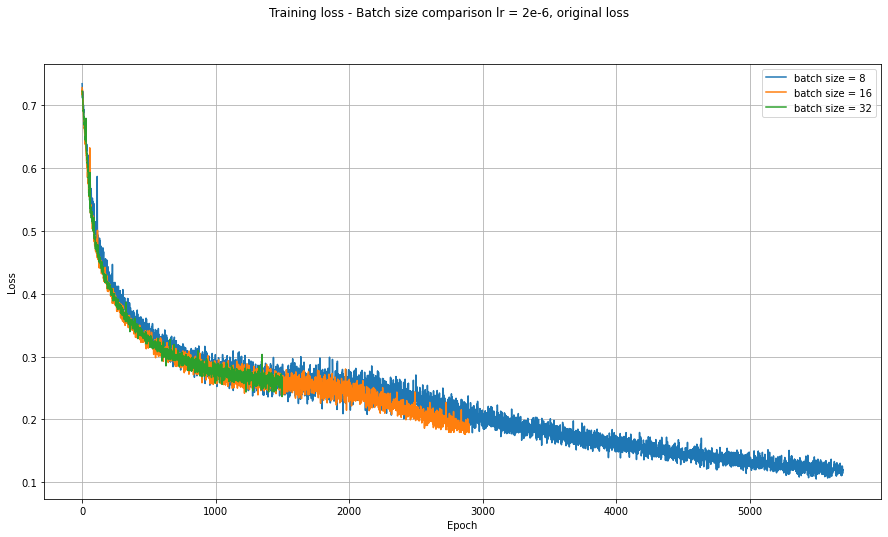

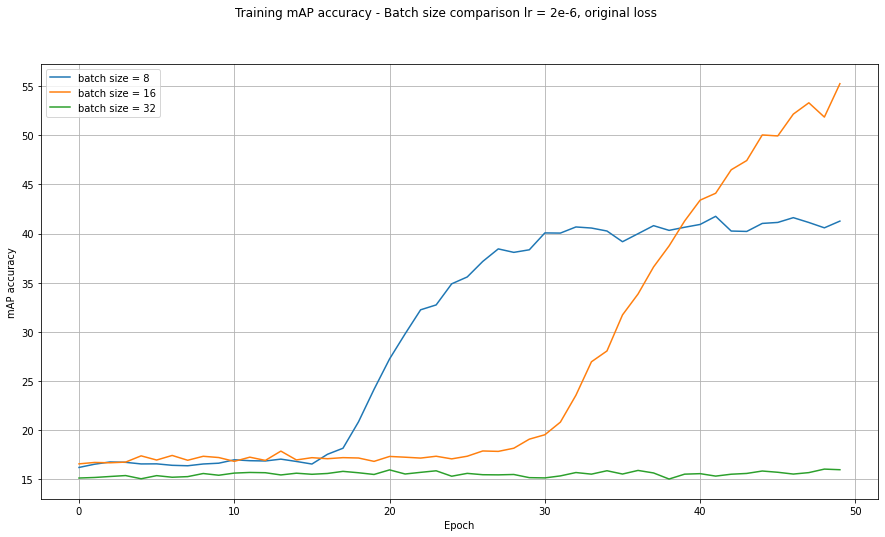

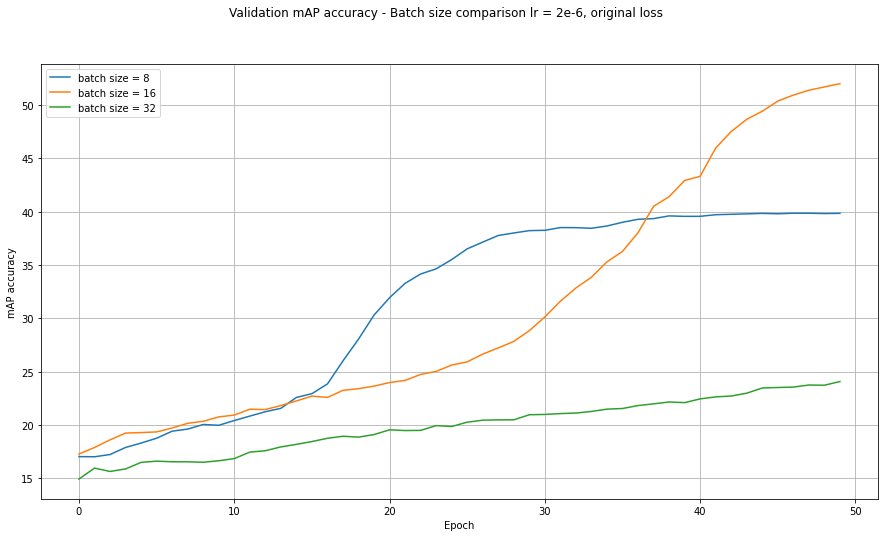

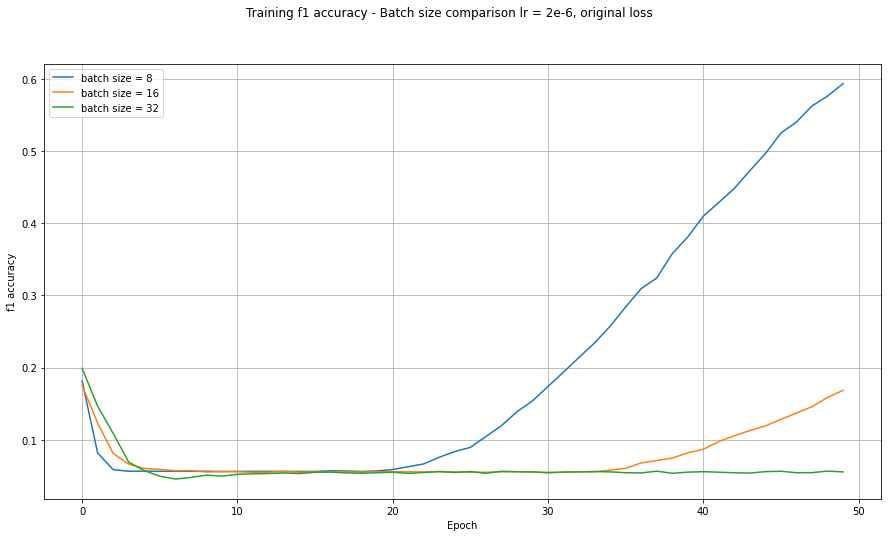

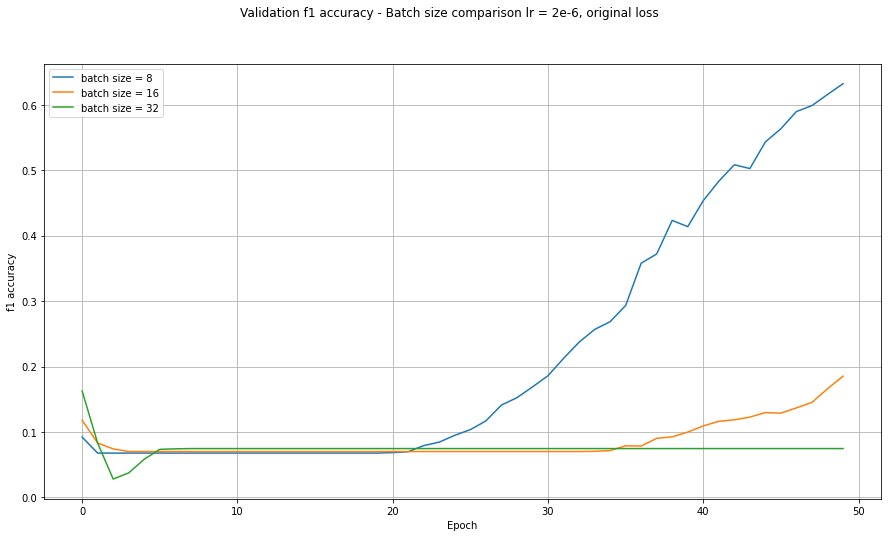

In [ ]:
## Add all combination of options as you'd like
combinations = [{'use_default_loss': 1, 'learning_rate': 2e-6, 'epochs': 50, 'batch_size': 8},
                {'use_default_loss': 1, 'learning_rate': 2e-6, 'epochs': 50, 'batch_size': 16},
                {'use_default_loss': 1, 'learning_rate': 2e-6, 'epochs': 50, 'batch_size': 32}]

labels = ['batch size = 8', 'batch size = 16', 'batch size = 32']
title = 'Batch size comparison lr = 2e-6, original loss'

combinations_results = []

for combination in combinations:

  use_default_loss = bool(combination['use_default_loss'])
  learning_rate = combination['learning_rate']
  epochs = combination['epochs']
  batch_size = combination['batch_size']

  results = train_and_plot_results(epochs, use_default_loss, learning_rate, batch_size, train_inputs, train_masks, train_labels,
                validation_inputs, validation_masks, validation_labels)
  combinations_results.append(results)

plot_results(combinations_results, labels, title)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a


Train loss: 91.09779521433649
Train Acc mAP: 16.57466256073939
Train Acc f1: 0.33244124271389863
Validation Acc mAP: 17.627822836891994
Validation Acc f1: 0.33286387800016226


Epoch:   2%|▏         | 1/50 [00:40<33:26, 40.96s/it]


Train loss: 89.96687692491723
Train Acc mAP: 16.094553238176342
Train Acc f1: 0.3495753818985978
Validation Acc mAP: 16.463717023242378
Validation Acc f1: 0.35041734291751037


Epoch:   4%|▍         | 2/50 [01:20<31:53, 39.87s/it]


Train loss: 89.81812339969291
Train Acc mAP: 16.15608267619003
Train Acc f1: 0.3466347418217586


Epoch:   6%|▌         | 3/50 [01:56<30:10, 38.52s/it]

Validation Acc mAP: 16.03945405331579
Validation Acc f1: 0.33486379962259627

Train loss: 89.8331462798404
Train Acc mAP: 16.00908353295755
Train Acc f1: 0.34819279314280643


Epoch:   8%|▊         | 4/50 [02:33<29:00, 37.84s/it]

Validation Acc mAP: 15.977241246064896
Validation Acc f1: 0.3498624009542098

Train loss: 89.81184087087776
Train Acc mAP: 15.885151203722707
Train Acc f1: 0.3551633407057834


Epoch:  10%|█         | 5/50 [03:10<28:03, 37.42s/it]

Validation Acc mAP: 16.135356241393104
Validation Acc f1: 0.3484761862023451

Train loss: 89.81437329206278
Train Acc mAP: 15.842074160335454
Train Acc f1: 0.3591074439709895
Validation Acc mAP: 16.49284395881972
Validation Acc f1: 0.35477837677290963


Epoch:  12%|█▏        | 6/50 [03:48<27:38, 37.70s/it]


Train loss: 89.50040269296218
Train Acc mAP: 16.181052067189512
Train Acc f1: 0.35002305063802786


Epoch:  14%|█▍        | 7/50 [04:25<26:51, 37.48s/it]

Validation Acc mAP: 15.892349039364197
Validation Acc f1: 0.34766144472703303

Train loss: 89.3194562346464
Train Acc mAP: 16.137682250659793
Train Acc f1: 0.3554692268218485


Epoch:  16%|█▌        | 8/50 [05:02<26:03, 37.22s/it]

Validation Acc mAP: 16.18058455136302
Validation Acc f1: 0.3532216389924501

Train loss: 89.58064569007536
Train Acc mAP: 16.193622219619268
Train Acc f1: 0.35541633828944336
Validation Acc mAP: 15.845154080227275
Validation Acc f1: 0.35602084335695583


Epoch:  18%|█▊        | 9/50 [05:40<25:41, 37.59s/it]


Train loss: 89.53727230897817
Train Acc mAP: 15.939592273367504
Train Acc f1: 0.352312954019204


Epoch:  20%|██        | 10/50 [06:17<24:54, 37.37s/it]

Validation Acc mAP: 16.299650809020072
Validation Acc f1: 0.34961115560513245

Train loss: 89.4451058793172
Train Acc mAP: 16.357413209401418
Train Acc f1: 0.34572847505296145


Epoch:  22%|██▏       | 11/50 [06:54<24:11, 37.21s/it]

Validation Acc mAP: 16.275678173831395
Validation Acc f1: 0.3545653385031911

Train loss: 89.34696299061169
Train Acc mAP: 16.302300967021992
Train Acc f1: 0.3529686565456562


Epoch:  24%|██▍       | 12/50 [07:31<23:29, 37.08s/it]

Validation Acc mAP: 15.66968875014109
Validation Acc f1: 0.35419569211160973

Train loss: 89.23428709203404
Train Acc mAP: 16.152940847759076
Train Acc f1: 0.3549950709680207


Epoch:  26%|██▌       | 13/50 [08:08<22:48, 36.99s/it]

Validation Acc mAP: 15.897004688163596
Validation Acc f1: 0.34940244597606146

Train loss: 89.37045343248609
Train Acc mAP: 16.49466897017939
Train Acc f1: 0.3435316950091118


Epoch:  28%|██▊       | 14/50 [08:45<22:10, 36.97s/it]

Validation Acc mAP: 16.315589069600936
Validation Acc f1: 0.3547531433382133

Train loss: 89.49298300403336
Train Acc mAP: 15.683613337329913
Train Acc f1: 0.3579955707243257


Epoch:  30%|███       | 15/50 [09:21<21:31, 36.89s/it]

Validation Acc mAP: 15.885619551545458
Validation Acc f1: 0.35208107912768755

Train loss: 89.24783855571555
Train Acc mAP: 16.15436112360351
Train Acc f1: 0.3494934385670343
Validation Acc mAP: 15.700306987326467
Validation Acc f1: 0.35669126159903325


Epoch:  32%|███▏      | 16/50 [10:00<21:09, 37.35s/it]


Train loss: 89.35834456584963
Train Acc mAP: 16.224196359423388
Train Acc f1: 0.3545799540410992
Validation Acc mAP: 15.83778080554127
Validation Acc f1: 0.3584650717232074


Epoch:  34%|███▍      | 17/50 [10:38<20:44, 37.70s/it]


Train loss: 89.23126926304847
Train Acc mAP: 16.084812841611708
Train Acc f1: 0.3502629623271271


Epoch:  36%|███▌      | 18/50 [11:15<19:59, 37.49s/it]

Validation Acc mAP: 16.287892181643567
Validation Acc f1: 0.35026378644299316

Train loss: 89.1656907760396
Train Acc mAP: 16.08881138866625
Train Acc f1: 0.35677364681875334


Epoch:  38%|███▊      | 19/50 [11:52<19:17, 37.34s/it]

Validation Acc mAP: 16.352922148455466
Validation Acc f1: 0.35378420189964965

Train loss: 90.11819784357392
Train Acc mAP: 16.440935916602886
Train Acc f1: 0.35049733176405284


Epoch:  40%|████      | 20/50 [12:29<18:34, 37.16s/it]

Validation Acc mAP: 16.76047091262504
Validation Acc f1: 0.3516472644293695

Train loss: 89.22655893791136
Train Acc mAP: 16.224193716074748
Train Acc f1: 0.35113876877512573


Epoch:  42%|████▏     | 21/50 [13:06<17:54, 37.07s/it]

Validation Acc mAP: 16.66542389067723
Validation Acc f1: 0.35528674075265687

Train loss: 89.21091522787115
Train Acc mAP: 16.025421882054523
Train Acc f1: 0.35760030356854616


Epoch:  44%|████▍     | 22/50 [13:42<17:14, 36.95s/it]

Validation Acc mAP: 16.384418850622964
Validation Acc f1: 0.35460330378874905

Train loss: 89.29588666812985
Train Acc mAP: 16.100484728453946
Train Acc f1: 0.3539704363910791


Epoch:  46%|████▌     | 23/50 [14:19<16:36, 36.91s/it]

Validation Acc mAP: 16.67022400992415
Validation Acc f1: 0.3531926142016627

Train loss: 89.45707041842957
Train Acc mAP: 16.391448221916317
Train Acc f1: 0.3486416536706342


Epoch:  48%|████▊     | 24/50 [14:56<15:58, 36.85s/it]

Validation Acc mAP: 16.347171323277298
Validation Acc f1: 0.35404571376856675

Train loss: 88.97226347690604
Train Acc mAP: 16.352981691643127
Train Acc f1: 0.3558631521934305


Epoch:  50%|█████     | 25/50 [15:33<15:19, 36.80s/it]

Validation Acc mAP: 16.464517928122817
Validation Acc f1: 0.35416499565813325

Train loss: 89.14260986257177
Train Acc mAP: 16.254921691098513
Train Acc f1: 0.35161790338764387


Epoch:  52%|█████▏    | 26/50 [16:09<14:43, 36.80s/it]

Validation Acc mAP: 16.249994540383923
Validation Acc f1: 0.3537271838989225

Train loss: 89.22186811104054
Train Acc mAP: 16.19104119343763
Train Acc f1: 0.352598630152526


Epoch:  54%|█████▍    | 27/50 [16:46<14:05, 36.76s/it]

Validation Acc mAP: 16.527571922293586
Validation Acc f1: 0.3522942931293744

Train loss: 89.09390431700407
Train Acc mAP: 16.541438309294907
Train Acc f1: 0.34852587214866193


Epoch:  56%|█████▌    | 28/50 [17:23<13:29, 36.77s/it]

Validation Acc mAP: 16.682352466464344
Validation Acc f1: 0.3551125852843239

Train loss: 89.13097485881812
Train Acc mAP: 16.2248336412765
Train Acc f1: 0.354248818336391


Epoch:  58%|█████▊    | 29/50 [18:00<12:51, 36.74s/it]

Validation Acc mAP: 16.419210394455803
Validation Acc f1: 0.35620868041616505

Train loss: 89.25192022091404
Train Acc mAP: 16.057103306563103
Train Acc f1: 0.3494238817363153


Epoch:  60%|██████    | 30/50 [18:36<12:14, 36.73s/it]

Validation Acc mAP: 16.76012604916334
Validation Acc f1: 0.35539101208980495

Train loss: 89.22747635818759
Train Acc mAP: 15.852528390005414
Train Acc f1: 0.3601130023974846


Epoch:  62%|██████▏   | 31/50 [19:13<11:38, 36.76s/it]

Validation Acc mAP: 16.650708961667632
Validation Acc f1: 0.3568692135842142

Train loss: 88.92090628265152
Train Acc mAP: 15.740558954946055
Train Acc f1: 0.3575702129774137


Epoch:  64%|██████▍   | 32/50 [19:50<11:01, 36.73s/it]

Validation Acc mAP: 16.61134099334914
Validation Acc f1: 0.3555022564949306

Train loss: 89.2651772686714
Train Acc mAP: 16.52777894720146
Train Acc f1: 0.35078651928842947


Epoch:  66%|██████▌   | 33/50 [20:27<10:24, 36.74s/it]

Validation Acc mAP: 16.667299665679046
Validation Acc f1: 0.35598357520596485

Train loss: 89.1068767517388
Train Acc mAP: 16.16326563744195
Train Acc f1: 0.35424337241682635


Epoch:  68%|██████▊   | 34/50 [21:03<09:47, 36.71s/it]

Validation Acc mAP: 16.276987055903025
Validation Acc f1: 0.35216183828075853

Train loss: 89.15158936200349
Train Acc mAP: 16.31193478550633
Train Acc f1: 0.3510028814707375


Epoch:  70%|███████   | 35/50 [21:40<09:10, 36.71s/it]

Validation Acc mAP: 16.359409297556194
Validation Acc f1: 0.3540307032161485

Train loss: 89.12186074442465
Train Acc mAP: 16.526895233635205
Train Acc f1: 0.35250186841407954


Epoch:  72%|███████▏  | 36/50 [22:17<08:34, 36.73s/it]

Validation Acc mAP: 16.544922255884945
Validation Acc f1: 0.3546183143411673

Train loss: 89.4162487530028
Train Acc mAP: 16.395021301280934
Train Acc f1: 0.35101362230587824


Epoch:  74%|███████▍  | 37/50 [22:53<07:57, 36.70s/it]

Validation Acc mAP: 16.546492780065083
Validation Acc f1: 0.3548117674118468

Train loss: 89.0916288111491
Train Acc mAP: 16.58075696345497
Train Acc f1: 0.3533526640609363


Epoch:  76%|███████▌  | 38/50 [23:30<07:20, 36.73s/it]

Validation Acc mAP: 16.348266496563433
Validation Acc f1: 0.3539926655227474

Train loss: 89.14183139338931
Train Acc mAP: 16.00758382901731
Train Acc f1: 0.35105385950928547


Epoch:  78%|███████▊  | 39/50 [24:07<06:43, 36.71s/it]

Validation Acc mAP: 16.36690773616851
Validation Acc f1: 0.3542457488220792

Train loss: 89.19889128228027
Train Acc mAP: 16.675591304400086
Train Acc f1: 0.35553354269515686


Epoch:  80%|████████  | 40/50 [24:43<06:06, 36.69s/it]

Validation Acc mAP: 16.36464748617203
Validation Acc f1: 0.35460330378874905

Train loss: 89.12893735353757
Train Acc mAP: 16.331190588947564
Train Acc f1: 0.354140045386311


Epoch:  82%|████████▏ | 41/50 [25:20<05:30, 36.70s/it]

Validation Acc mAP: 16.661649039870294
Validation Acc f1: 0.35398689831050256

Train loss: 88.87685146825845
Train Acc mAP: 16.71326327263599
Train Acc f1: 0.34995268670688645


Epoch:  84%|████████▍ | 42/50 [25:57<04:53, 36.69s/it]

Validation Acc mAP: 16.738455608099972
Validation Acc f1: 0.35486481565766614

Train loss: 89.23085263654846
Train Acc mAP: 16.27480665882796
Train Acc f1: 0.3554782490435108


Epoch:  86%|████████▌ | 43/50 [26:34<04:16, 36.71s/it]

Validation Acc mAP: 16.40568617542687
Validation Acc f1: 0.35396039283060454

Train loss: 89.35121588684974
Train Acc mAP: 16.085193618237852
Train Acc f1: 0.35759617920655984


Epoch:  88%|████████▊ | 44/50 [27:10<03:40, 36.76s/it]

Validation Acc mAP: 16.43505078828594
Validation Acc f1: 0.3559936128713658

Train loss: 89.0183147399959
Train Acc mAP: 16.418918638161045
Train Acc f1: 0.355125089095503


Epoch:  90%|█████████ | 45/50 [27:47<03:03, 36.72s/it]

Validation Acc mAP: 16.452482678069295
Validation Acc f1: 0.35388896823330906

Train loss: 89.26740622803422
Train Acc mAP: 16.21027271697713
Train Acc f1: 0.356176521872563


Epoch:  92%|█████████▏| 46/50 [28:24<02:27, 36.76s/it]

Validation Acc mAP: 16.613344926426585
Validation Acc f1: 0.3509153665279382

Train loss: 89.08222371185342
Train Acc mAP: 16.31647682805949
Train Acc f1: 0.35686264055814965


Epoch:  94%|█████████▍| 47/50 [29:01<01:50, 36.74s/it]

Validation Acc mAP: 16.373816645359224
Validation Acc f1: 0.35531245834405745

Train loss: 89.26939223323134
Train Acc mAP: 16.010049239544017
Train Acc f1: 0.35483216185394617


Epoch:  96%|█████████▌| 48/50 [29:37<01:13, 36.74s/it]

Validation Acc mAP: 16.401044506407622
Validation Acc f1: 0.35385618394788276

Train loss: 89.12647897090582
Train Acc mAP: 16.510634048492122
Train Acc f1: 0.3461961060956995


Epoch:  98%|█████████▊| 49/50 [30:14<00:36, 36.70s/it]

Validation Acc mAP: 16.316599689947132
Validation Acc f1: 0.357224602190055

Train loss: 89.1995450545803
Train Acc mAP: 16.474127232944625
Train Acc f1: 0.35479412253902326


Epoch: 100%|██████████| 50/50 [30:51<00:00, 37.02s/it]

Validation Acc mAP: 16.47416476939511
Validation Acc f1: 0.3513480227955587



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions 


Train loss: 179.82241398829507
Train Acc mAP: 16.38453057339956
Train Acc f1: 0.2764117706825251
Validation Acc mAP: 20.350855554424367
Validation Acc f1: 0.30026727821983407


Epoch:   2%|▏         | 1/50 [00:38<31:06, 38.10s/it]


Train loss: 172.4079658909878
Train Acc mAP: 24.556743701909713
Train Acc f1: 0.351795240238328
Validation Acc mAP: 25.880854948598802
Validation Acc f1: 0.36948438422913243


Epoch:   4%|▍         | 2/50 [01:17<30:53, 38.62s/it]


Train loss: 177.05163724673565
Train Acc mAP: 16.486354968229115
Train Acc f1: 0.288390835711385


Epoch:   6%|▌         | 3/50 [01:52<28:59, 37.01s/it]

Validation Acc mAP: 21.015976834141302
Validation Acc f1: 0.29393517655524354

Train loss: 177.85072568620714
Train Acc mAP: 16.955510203251837
Train Acc f1: 0.28706953993540046


Epoch:   8%|▊         | 4/50 [02:26<27:40, 36.10s/it]

Validation Acc mAP: 18.03331526573097
Validation Acc f1: 0.29157971047288306

Train loss: 177.47504969069183
Train Acc mAP: 16.337067039069755
Train Acc f1: 0.28983682635593305


Epoch:  10%|█         | 5/50 [03:01<26:42, 35.61s/it]

Validation Acc mAP: 18.057186212683728
Validation Acc f1: 0.2982988330124078

Train loss: 177.46820864246823
Train Acc mAP: 16.84293342922593
Train Acc f1: 0.28571167506063333


Epoch:  12%|█▏        | 6/50 [03:36<25:54, 35.32s/it]

Validation Acc mAP: 19.248950839407634
Validation Acc f1: 0.29841392663165317

Train loss: 177.44426971416323
Train Acc mAP: 16.206361600229013
Train Acc f1: 0.28767350825748467


Epoch:  14%|█▍        | 7/50 [04:11<25:10, 35.14s/it]

Validation Acc mAP: 19.326697903224936
Validation Acc f1: 0.2979309163613154

Train loss: 177.74547420215586
Train Acc mAP: 16.450417635419257
Train Acc f1: 0.29019078564872475


Epoch:  16%|█▌        | 8/50 [04:45<24:29, 34.99s/it]

Validation Acc mAP: 19.11668637178033
Validation Acc f1: 0.2996754832449519

Train loss: 177.04277902683376
Train Acc mAP: 16.75939717895618
Train Acc f1: 0.28434954825938197


Epoch:  18%|█▊        | 9/50 [05:20<23:51, 34.92s/it]

Validation Acc mAP: 18.372865432316928
Validation Acc f1: 0.2990978492427918

Train loss: 177.091027750318
Train Acc mAP: 16.76964646292488
Train Acc f1: 0.28620141235295304


Epoch:  20%|██        | 10/50 [05:55<23:13, 34.85s/it]

Validation Acc mAP: 18.28428921623608
Validation Acc f1: 0.3006395096561644

Train loss: 177.16871468980887
Train Acc mAP: 16.916011254138212
Train Acc f1: 0.2847965147191942


Epoch:  22%|██▏       | 11/50 [06:30<22:38, 34.82s/it]

Validation Acc mAP: 17.6978850806382
Validation Acc f1: 0.29923499218850325

Train loss: 177.35510367411288
Train Acc mAP: 17.00582023999303
Train Acc f1: 0.2832707231461328


Epoch:  24%|██▍       | 12/50 [07:04<22:01, 34.78s/it]

Validation Acc mAP: 18.260313580330987
Validation Acc f1: 0.2996020433424515

Train loss: 176.99084565881085
Train Acc mAP: 16.97139334634675
Train Acc f1: 0.28328236474254687


Epoch:  26%|██▌       | 13/50 [07:39<21:25, 34.75s/it]

Validation Acc mAP: 18.951537202840992
Validation Acc f1: 0.2978210529339708

Train loss: 177.37521680158713
Train Acc mAP: 16.453585481269943
Train Acc f1: 0.28936591339935147


Epoch:  28%|██▊       | 14/50 [08:14<20:50, 34.75s/it]

Validation Acc mAP: 17.84225926170374
Validation Acc f1: 0.2970486615771484

Train loss: 176.82107390667719
Train Acc mAP: 16.588898546835505
Train Acc f1: 0.29077706514072066


Epoch:  30%|███       | 15/50 [08:48<20:15, 34.73s/it]

Validation Acc mAP: 17.414258204563797
Validation Acc f1: 0.2970486615771484

Train loss: 176.60264740007182
Train Acc mAP: 16.859071924719768
Train Acc f1: 0.28190350274890386


Epoch:  32%|███▏      | 16/50 [09:23<19:40, 34.73s/it]

Validation Acc mAP: 16.358037842950075
Validation Acc f1: 0.2941542448381904

Train loss: 177.56509057502407
Train Acc mAP: 16.515634430858313
Train Acc f1: 0.27873545063040545


Epoch:  34%|███▍      | 17/50 [09:58<19:06, 34.74s/it]

Validation Acc mAP: 16.088778266420405
Validation Acc f1: 0.29948708524430007

Train loss: 176.8178683883824
Train Acc mAP: 16.376914534035215
Train Acc f1: 0.28544666150418957


Epoch:  36%|███▌      | 18/50 [10:32<18:31, 34.72s/it]

Validation Acc mAP: 16.23656746618322
Validation Acc f1: 0.3017704763806569

Train loss: 177.30775327269373
Train Acc mAP: 16.704443134681938
Train Acc f1: 0.2872036458156499


Epoch:  38%|███▊      | 19/50 [11:07<17:56, 34.73s/it]

Validation Acc mAP: 16.216863523209092
Validation Acc f1: 0.29774728702167585

Train loss: 176.91181253218798
Train Acc mAP: 16.501761975697207
Train Acc f1: 0.28982050065255277


Epoch:  40%|████      | 20/50 [11:42<17:21, 34.72s/it]

Validation Acc mAP: 16.2832556230931
Validation Acc f1: 0.2978736622190362

Train loss: 177.14490747349666
Train Acc mAP: 16.721796595842097
Train Acc f1: 0.2830652715667672


Epoch:  42%|████▏     | 21/50 [12:17<16:46, 34.71s/it]

Validation Acc mAP: 15.64266136115465
Validation Acc f1: 0.2993709758305519

Train loss: 176.7233510087631
Train Acc mAP: 16.142029029174875
Train Acc f1: 0.29310395649082116


Epoch:  44%|████▍     | 22/50 [12:51<16:12, 34.72s/it]

Validation Acc mAP: 16.976792957293377
Validation Acc f1: 0.29836692524040964

Train loss: 177.20063898942442
Train Acc mAP: 16.676858727771826
Train Acc f1: 0.2854616028307719


Epoch:  46%|████▌     | 23/50 [13:26<15:37, 34.71s/it]

Validation Acc mAP: 16.21880810838983
Validation Acc f1: 0.29998445053529704

Train loss: 176.9220229034583
Train Acc mAP: 16.209756642599267
Train Acc f1: 0.28715607952357625


Epoch:  48%|████▊     | 24/50 [14:01<15:02, 34.70s/it]

Validation Acc mAP: 16.355373793112687
Validation Acc f1: 0.29597369884903885

Train loss: 176.77649778906817
Train Acc mAP: 16.808102035792015
Train Acc f1: 0.28080496021058704


Epoch:  50%|█████     | 25/50 [14:35<14:28, 34.72s/it]

Validation Acc mAP: 15.866852117382786
Validation Acc f1: 0.300087729136088

Train loss: 176.62550864466624
Train Acc mAP: 16.681528092316636
Train Acc f1: 0.27973214311804906


Epoch:  52%|█████▏    | 26/50 [15:10<13:53, 34.72s/it]

Validation Acc mAP: 16.369406993866008
Validation Acc f1: 0.30031626437088516

Train loss: 177.68061257812508
Train Acc mAP: 16.57576432017207
Train Acc f1: 0.28258701843290285


Epoch:  54%|█████▍    | 27/50 [15:45<13:18, 34.72s/it]

Validation Acc mAP: 16.05155669780879
Validation Acc f1: 0.29842671873209853

Train loss: 176.73247785391635
Train Acc mAP: 15.924347542838877
Train Acc f1: 0.2848199981348284


Epoch:  56%|█████▌    | 28/50 [16:20<12:44, 34.73s/it]

Validation Acc mAP: 16.109974005897904
Validation Acc f1: 0.29958035001233446

Train loss: 176.70090075124529
Train Acc mAP: 16.091033970678772
Train Acc f1: 0.2908861126311644


Epoch:  58%|█████▊    | 29/50 [16:54<12:09, 34.72s/it]

Validation Acc mAP: 16.23432170743027
Validation Acc f1: 0.2990678441448717

Train loss: 176.62212252040882
Train Acc mAP: 16.82392782621403
Train Acc f1: 0.28394109792609246


Epoch:  60%|██████    | 30/50 [17:29<11:34, 34.73s/it]

Validation Acc mAP: 16.308106899067663
Validation Acc f1: 0.3000081810963654

Train loss: 177.03939090166108
Train Acc mAP: 16.126449484018814
Train Acc f1: 0.2856159015131327


Epoch:  62%|██████▏   | 31/50 [18:04<10:59, 34.72s/it]

Validation Acc mAP: 16.277909664535557
Validation Acc f1: 0.2985720417740886

Train loss: 176.73666114045773
Train Acc mAP: 16.969807076181905
Train Acc f1: 0.2900737944235096


Epoch:  64%|██████▍   | 32/50 [18:39<10:24, 34.71s/it]

Validation Acc mAP: 16.63867073403517
Validation Acc f1: 0.2988053237731395

Train loss: 177.04051149439908
Train Acc mAP: 16.38756251771543
Train Acc f1: 0.28992451734942276


Epoch:  66%|██████▌   | 33/50 [19:13<09:50, 34.73s/it]

Validation Acc mAP: 16.218145725771983
Validation Acc f1: 0.30156008936432854

Train loss: 176.82927736875635
Train Acc mAP: 16.553410294299145
Train Acc f1: 0.27651741275472447


Epoch:  68%|██████▊   | 34/50 [19:48<09:15, 34.72s/it]

Validation Acc mAP: 16.390397009036782
Validation Acc f1: 0.30092478748679063

Train loss: 176.52829980817705
Train Acc mAP: 16.526185398096384
Train Acc f1: 0.28145539872476394


Epoch:  70%|███████   | 35/50 [20:23<08:40, 34.71s/it]

Validation Acc mAP: 16.04839302964142
Validation Acc f1: 0.297849444575857

Train loss: 177.01587734338958
Train Acc mAP: 16.093796420651806
Train Acc f1: 0.2924671801364656


Epoch:  72%|███████▏  | 36/50 [20:58<08:07, 34.79s/it]

Validation Acc mAP: 15.780589130168826
Validation Acc f1: 0.30117155225675596

Train loss: 176.60069278202866
Train Acc mAP: 16.5991748114311
Train Acc f1: 0.28320844035542486


Epoch:  74%|███████▍  | 37/50 [21:32<07:31, 34.76s/it]

Validation Acc mAP: 16.018201388871542
Validation Acc f1: 0.29835068504261947

Train loss: 176.65249650141942
Train Acc mAP: 16.75818087623039
Train Acc f1: 0.2859939124050489


Epoch:  76%|███████▌  | 38/50 [22:07<06:57, 34.78s/it]

Validation Acc mAP: 16.720270154243135
Validation Acc f1: 0.29999058045002397

Train loss: 177.10576350002592
Train Acc mAP: 16.447073832162868
Train Acc f1: 0.28712125430964497


Epoch:  78%|███████▊  | 39/50 [22:42<06:22, 34.76s/it]

Validation Acc mAP: 16.068701309886045
Validation Acc f1: 0.30123882981763966

Train loss: 176.36070681419503
Train Acc mAP: 16.370760371288764
Train Acc f1: 0.2838501265818991


Epoch:  80%|████████  | 40/50 [23:17<05:47, 34.73s/it]

Validation Acc mAP: 16.276345872558714
Validation Acc f1: 0.2997279638845907

Train loss: 177.25807394622674
Train Acc mAP: 16.66121196973161
Train Acc f1: 0.2818391518434063


Epoch:  82%|████████▏ | 41/50 [23:51<05:12, 34.75s/it]

Validation Acc mAP: 16.232344971999286
Validation Acc f1: 0.3003183200597674

Train loss: 176.56179252599492
Train Acc mAP: 16.70087000435136
Train Acc f1: 0.28310226588609205


Epoch:  84%|████████▍ | 42/50 [24:26<04:38, 34.75s/it]

Validation Acc mAP: 16.430226317151515
Validation Acc f1: 0.2972398895431968

Train loss: 176.3726658599158
Train Acc mAP: 16.72577637923519
Train Acc f1: 0.2821303640273326


Epoch:  86%|████████▌ | 43/50 [25:01<04:03, 34.74s/it]

Validation Acc mAP: 16.49760308698393
Validation Acc f1: 0.29999058045002397

Train loss: 176.77440210792474
Train Acc mAP: 16.46271988268312
Train Acc f1: 0.28520302610754894


Epoch:  88%|████████▊ | 44/50 [25:36<03:28, 34.76s/it]

Validation Acc mAP: 15.995552564376947
Validation Acc f1: 0.2981148152704459

Train loss: 176.88252941457617
Train Acc mAP: 16.491906275857904
Train Acc f1: 0.2851838097343767


Epoch:  90%|█████████ | 45/50 [26:10<02:53, 34.74s/it]

Validation Acc mAP: 16.079736549279215
Validation Acc f1: 0.29948708524430007

Train loss: 176.90126480512748
Train Acc mAP: 16.62157475982419
Train Acc f1: 0.29396570058502053


Epoch:  92%|█████████▏| 46/50 [26:45<02:18, 34.72s/it]

Validation Acc mAP: 16.17630074942258
Validation Acc f1: 0.29999058045002397

Train loss: 176.48363637718626
Train Acc mAP: 16.60747751256911
Train Acc f1: 0.28619042394466015


Epoch:  94%|█████████▍| 47/50 [27:20<01:44, 34.74s/it]

Validation Acc mAP: 16.808173159916137
Validation Acc f1: 0.29999058045002397

Train loss: 176.99568538960625
Train Acc mAP: 16.822137134939023
Train Acc f1: 0.28383270348659145


Epoch:  96%|█████████▌| 48/50 [27:54<01:09, 34.73s/it]

Validation Acc mAP: 16.93188404204283
Validation Acc f1: 0.29835068504261947

Train loss: 176.5275226418791
Train Acc mAP: 16.967071223345833
Train Acc f1: 0.27977834422812076


Epoch:  98%|█████████▊| 49/50 [28:29<00:34, 34.77s/it]

Validation Acc mAP: 16.17165426510463
Validation Acc f1: 0.29982511257065475

Train loss: 176.60282706290442
Train Acc mAP: 17.02433158499364
Train Acc f1: 0.2781971385432548


Epoch: 100%|██████████| 50/50 [29:04<00:00, 34.89s/it]

Validation Acc mAP: 16.44509692361097
Validation Acc f1: 0.2989050784318835



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions 


Train loss: 355.0940433704452
Train Acc mAP: 15.122605742970254
Train Acc f1: 0.24349356504761832
Validation Acc mAP: 17.27278610344779
Validation Acc f1: 0.29130054512855197


Epoch:   2%|▏         | 1/50 [00:37<30:30, 37.37s/it]


Train loss: 348.25736720389136
Train Acc mAP: 14.958800301592905
Train Acc f1: 0.25376446597440794
Validation Acc mAP: 18.79035156245961
Validation Acc f1: 0.28849311479893514


Epoch:   4%|▍         | 2/50 [01:13<29:07, 36.41s/it]


Train loss: 348.92838813029874
Train Acc mAP: 14.999811089085428
Train Acc f1: 0.252209379014665


Epoch:   6%|▌         | 3/50 [01:46<27:36, 35.24s/it]

Validation Acc mAP: 17.4794534754431
Validation Acc f1: 0.27824958306091657

Train loss: 348.1380140455469
Train Acc mAP: 15.322365976809925
Train Acc f1: 0.2508702263676761


Epoch:   8%|▊         | 4/50 [02:20<26:34, 34.66s/it]

Validation Acc mAP: 17.270627524661354
Validation Acc f1: 0.2877776930386107

Train loss: 349.31488313517644
Train Acc mAP: 15.676593858972726
Train Acc f1: 0.2549216686517723
Validation Acc mAP: 22.627104850983706
Validation Acc f1: 0.28849917535876834


Epoch:  10%|█         | 5/50 [02:56<26:10, 34.90s/it]


Train loss: 349.2198837511069
Train Acc mAP: 15.475117225152406
Train Acc f1: 0.2489704684825123


Epoch:  12%|█▏        | 6/50 [03:29<25:19, 34.53s/it]

Validation Acc mAP: 21.35576941884244
Validation Acc f1: 0.28413653101763486

Train loss: 347.7468757536252
Train Acc mAP: 17.01194886550243
Train Acc f1: 0.25501783850771387
Validation Acc mAP: 22.95737572327473
Validation Acc f1: 0.2916644822174233


Epoch:  14%|█▍        | 7/50 [04:06<25:19, 35.34s/it]


Train loss: 344.58144418409046
Train Acc mAP: 20.738404025979147
Train Acc f1: 0.2885868905863832


Epoch:  16%|█▌        | 8/50 [04:40<24:24, 34.87s/it]

Validation Acc mAP: 13.334250747843225
Validation Acc f1: 0.2491095388138432

Train loss: 347.93682432342246
Train Acc mAP: 15.11089149703825
Train Acc f1: 0.2513719247082482


Epoch:  18%|█▊        | 9/50 [05:14<23:34, 34.50s/it]

Validation Acc mAP: 14.78084945039725
Validation Acc f1: 0.28890528507942664

Train loss: 348.2965639912975
Train Acc mAP: 14.90811679975182
Train Acc f1: 0.25129464365091253


Epoch:  20%|██        | 10/50 [05:48<22:50, 34.27s/it]

Validation Acc mAP: 16.84875636158837
Validation Acc f1: 0.28684819097854397

Train loss: 348.38381989486044
Train Acc mAP: 14.85210935039027
Train Acc f1: 0.24973460930566066


Epoch:  22%|██▏       | 11/50 [06:21<22:09, 34.09s/it]

Validation Acc mAP: 15.931689429278943
Validation Acc f1: 0.28922927030144585

Train loss: 348.82608695979815
Train Acc mAP: 14.943027449798075
Train Acc f1: 0.25689707639013576


Epoch:  24%|██▍       | 12/50 [06:55<21:31, 33.98s/it]

Validation Acc mAP: 15.90429470238775
Validation Acc f1: 0.2886699271456996

Train loss: 348.2127194293055
Train Acc mAP: 15.746011571983061
Train Acc f1: 0.25136687622819864


Epoch:  26%|██▌       | 13/50 [07:29<20:54, 33.91s/it]

Validation Acc mAP: 16.290934169571916
Validation Acc f1: 0.2881252668531801

Train loss: 348.9570833682345
Train Acc mAP: 14.457806199472701
Train Acc f1: 0.25610868493855


Epoch:  28%|██▊       | 14/50 [08:03<20:18, 33.85s/it]

Validation Acc mAP: 18.944010532954607
Validation Acc f1: 0.2895280420509122

Train loss: 347.3998414170558
Train Acc mAP: 14.773787837856728
Train Acc f1: 0.2571936032863514


Epoch:  30%|███       | 15/50 [08:36<19:43, 33.80s/it]

Validation Acc mAP: 18.610813732872145
Validation Acc f1: 0.28912977285614866

Train loss: 348.73621914479236
Train Acc mAP: 14.694355332295162
Train Acc f1: 0.2512662748800048


Epoch:  32%|███▏      | 16/50 [09:10<19:08, 33.78s/it]

Validation Acc mAP: 17.823287094397806
Validation Acc f1: 0.2883107864798955

Train loss: 346.22111860927737
Train Acc mAP: 15.183692504394383
Train Acc f1: 0.25296341233087083


Epoch:  34%|███▍      | 17/50 [09:44<18:33, 33.75s/it]

Validation Acc mAP: 17.924352389869433
Validation Acc f1: 0.2892563404486052

Train loss: 348.7132741385727
Train Acc mAP: 14.970590723769977
Train Acc f1: 0.2506413443646235


Epoch:  36%|███▌      | 18/50 [10:17<17:59, 33.75s/it]

Validation Acc mAP: 19.572960127280755
Validation Acc f1: 0.28950720143495445

Train loss: 347.6814281386245
Train Acc mAP: 14.906667891690407
Train Acc f1: 0.2535734452403426


Epoch:  38%|███▊      | 19/50 [10:51<17:26, 33.75s/it]

Validation Acc mAP: 18.48038640598181
Validation Acc f1: 0.2879259206339496

Train loss: 348.287467302766
Train Acc mAP: 15.107099871887662
Train Acc f1: 0.2566298152158694


Epoch:  40%|████      | 20/50 [11:25<16:52, 33.73s/it]

Validation Acc mAP: 18.47864957869025
Validation Acc f1: 0.2887362998683891

Train loss: 346.9976986661528
Train Acc mAP: 14.728594483957606
Train Acc f1: 0.25360404851993307


Epoch:  42%|████▏     | 21/50 [11:59<16:18, 33.73s/it]

Validation Acc mAP: 19.89515943896827
Validation Acc f1: 0.2893477256248604

Train loss: 347.24146723260503
Train Acc mAP: 14.650346847089464
Train Acc f1: 0.24950566771140303


Epoch:  44%|████▍     | 22/50 [12:32<15:44, 33.72s/it]

Validation Acc mAP: 18.190460323296065
Validation Acc f1: 0.2882661769245658

Train loss: 349.20251535379475
Train Acc mAP: 15.064584438082926
Train Acc f1: 0.25167916006950725


Epoch:  46%|████▌     | 23/50 [13:06<15:10, 33.72s/it]

Validation Acc mAP: 17.272034673339547
Validation Acc f1: 0.2878589127255793

Train loss: 346.7581761863548
Train Acc mAP: 14.40527612473942
Train Acc f1: 0.2540346890265488


Epoch:  48%|████▊     | 24/50 [13:40<14:36, 33.73s/it]

Validation Acc mAP: 16.895554276911028
Validation Acc f1: 0.2889561531104042

Train loss: 347.46621204854887
Train Acc mAP: 15.374273178345359
Train Acc f1: 0.2525494797618956


Epoch:  50%|█████     | 25/50 [14:13<14:03, 33.72s/it]

Validation Acc mAP: 16.660798456722432
Validation Acc f1: 0.28915645397133993

Train loss: 348.03800199474716
Train Acc mAP: 14.868282584221896
Train Acc f1: 0.25282899150855453


Epoch:  52%|█████▏    | 26/50 [14:47<13:29, 33.71s/it]

Validation Acc mAP: 18.114503560612942
Validation Acc f1: 0.2885608797490624

Train loss: 348.0738984250689
Train Acc mAP: 14.787270564911239
Train Acc f1: 0.24971987143745056


Epoch:  54%|█████▍    | 27/50 [15:21<12:55, 33.71s/it]

Validation Acc mAP: 17.196939431073698
Validation Acc f1: 0.28943916595819186

Train loss: 347.47791885238377
Train Acc mAP: 15.17340533686672
Train Acc f1: 0.2497016625172446


Epoch:  56%|█████▌    | 28/50 [15:55<12:21, 33.71s/it]

Validation Acc mAP: 17.800106076280116
Validation Acc f1: 0.28903100269288573

Train loss: 347.44562935699537
Train Acc mAP: 15.004007762167097
Train Acc f1: 0.2494030672312531


Epoch:  58%|█████▊    | 29/50 [16:28<11:47, 33.71s/it]

Validation Acc mAP: 17.02710624185602
Validation Acc f1: 0.28943916595819186

Train loss: 347.32186866791443
Train Acc mAP: 15.007107630533266
Train Acc f1: 0.2509913362896779


Epoch:  60%|██████    | 30/50 [17:02<11:14, 33.72s/it]

Validation Acc mAP: 16.418761526937445
Validation Acc f1: 0.29047933253483316

Train loss: 347.85951075058904
Train Acc mAP: 15.101304640082429
Train Acc f1: 0.25291909353217573


Epoch:  62%|██████▏   | 31/50 [17:36<10:40, 33.72s/it]

Validation Acc mAP: 16.544304816892332
Validation Acc f1: 0.28938552719544675

Train loss: 348.14094637732825
Train Acc mAP: 15.290278696418879
Train Acc f1: 0.2436711533889132


Epoch:  64%|██████▍   | 32/50 [18:09<10:06, 33.71s/it]

Validation Acc mAP: 16.053961648721298
Validation Acc f1: 0.28933832621366634

Train loss: 347.40546135258955
Train Acc mAP: 15.025212644200883
Train Acc f1: 0.24987110760908388


Epoch:  66%|██████▌   | 33/50 [18:43<09:33, 33.72s/it]

Validation Acc mAP: 16.48969494319053
Validation Acc f1: 0.28903100269288573

Train loss: 347.2844241009213
Train Acc mAP: 15.160266658385142
Train Acc f1: 0.25257986809889


Epoch:  68%|██████▊   | 34/50 [19:17<08:59, 33.71s/it]

Validation Acc mAP: 16.700497018990024
Validation Acc f1: 0.28843106685287573

Train loss: 347.91376445516454
Train Acc mAP: 15.301207363110331
Train Acc f1: 0.2564431271082369


Epoch:  70%|███████   | 35/50 [19:51<08:25, 33.71s/it]

Validation Acc mAP: 17.23994295658699
Validation Acc f1: 0.2892482645084501

Train loss: 348.57406902567294
Train Acc mAP: 14.65189379944543
Train Acc f1: 0.2573618336010315


Epoch:  72%|███████▏  | 36/50 [20:24<07:52, 33.73s/it]

Validation Acc mAP: 17.20932686892563
Validation Acc f1: 0.2892010635266697

Train loss: 346.343712120793
Train Acc mAP: 15.331764045277792
Train Acc f1: 0.25034060635191485


Epoch:  74%|███████▍  | 37/50 [20:58<07:18, 33.72s/it]

Validation Acc mAP: 16.82765560246494
Validation Acc f1: 0.2896072833181782

Train loss: 348.0936937895544
Train Acc mAP: 15.07077968119219
Train Acc f1: 0.2546893759796604


Epoch:  76%|███████▌  | 38/50 [21:32<06:44, 33.72s/it]

Validation Acc mAP: 16.022248935946273
Validation Acc f1: 0.28943916595819186

Train loss: 347.72283340893154
Train Acc mAP: 15.24316980304667
Train Acc f1: 0.2513887844003515


Epoch:  78%|███████▊  | 39/50 [22:05<06:10, 33.73s/it]

Validation Acc mAP: 16.378388790234762
Validation Acc f1: 0.2906153824234944

Train loss: 347.4264196512853
Train Acc mAP: 14.972053300999557
Train Acc f1: 0.25941296204177217


Epoch:  80%|████████  | 40/50 [22:39<05:37, 33.71s/it]

Validation Acc mAP: 16.696421980818226
Validation Acc f1: 0.28933832621366634

Train loss: 346.0749372168144
Train Acc mAP: 15.53031509709056
Train Acc f1: 0.25501516051028444


Epoch:  82%|████████▏ | 41/50 [23:13<05:03, 33.72s/it]

Validation Acc mAP: 16.635413584680222
Validation Acc f1: 0.28873976900177156

Train loss: 347.6020779693646
Train Acc mAP: 15.132122759641357
Train Acc f1: 0.25124230481837634


Epoch:  84%|████████▍ | 42/50 [23:47<04:29, 33.72s/it]

Validation Acc mAP: 16.88578575719422
Validation Acc f1: 0.28943916595819186

Train loss: 348.1914370250715
Train Acc mAP: 14.516053467460253
Train Acc f1: 0.24971431968384697


Epoch:  86%|████████▌ | 43/50 [24:20<03:56, 33.72s/it]

Validation Acc mAP: 16.09000208325069
Validation Acc f1: 0.28958582805638255

Train loss: 348.2551687219592
Train Acc mAP: 14.664170412579022
Train Acc f1: 0.2616193441223314


Epoch:  88%|████████▊ | 44/50 [24:54<03:22, 33.73s/it]

Validation Acc mAP: 16.98316584683522
Validation Acc f1: 0.28943916595819186

Train loss: 346.87377706392374
Train Acc mAP: 15.478141918027264
Train Acc f1: 0.25736989199993304


Epoch:  90%|█████████ | 45/50 [25:28<02:48, 33.73s/it]

Validation Acc mAP: 16.436432130328242
Validation Acc f1: 0.28953356792175267

Train loss: 346.8447482913776
Train Acc mAP: 15.423247072049708
Train Acc f1: 0.2526787209002926


Epoch:  92%|█████████▏| 46/50 [26:01<02:14, 33.72s/it]

Validation Acc mAP: 16.75251447131901
Validation Acc f1: 0.2889430528523246

Train loss: 348.33896640579286
Train Acc mAP: 15.39747035237325
Train Acc f1: 0.2524163440808957


Epoch:  94%|█████████▍| 47/50 [26:35<01:41, 33.72s/it]

Validation Acc mAP: 17.24586146040447
Validation Acc f1: 0.28958582805638255

Train loss: 346.747066849326
Train Acc mAP: 15.730141482868703
Train Acc f1: 0.24843249903224168


Epoch:  96%|█████████▌| 48/50 [27:09<01:07, 33.72s/it]

Validation Acc mAP: 18.255087280285792
Validation Acc f1: 0.28888643109996226

Train loss: 347.7966467060705
Train Acc mAP: 14.953491549727273
Train Acc f1: 0.2564109623873939


Epoch:  98%|█████████▊| 49/50 [27:43<00:33, 33.72s/it]

Validation Acc mAP: 17.869832962121983
Validation Acc f1: 0.28913393294267853

Train loss: 347.9619930818281
Train Acc mAP: 14.802291180650919
Train Acc f1: 0.25620570247590563


Epoch: 100%|██████████| 50/50 [28:16<00:00, 33.94s/it]

Validation Acc mAP: 17.92436225946637
Validation Acc f1: 0.2891916641154757


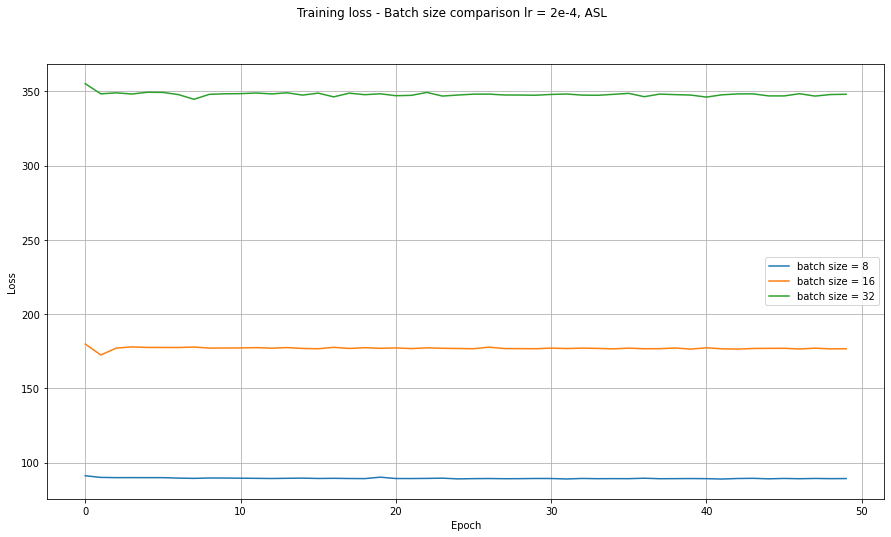

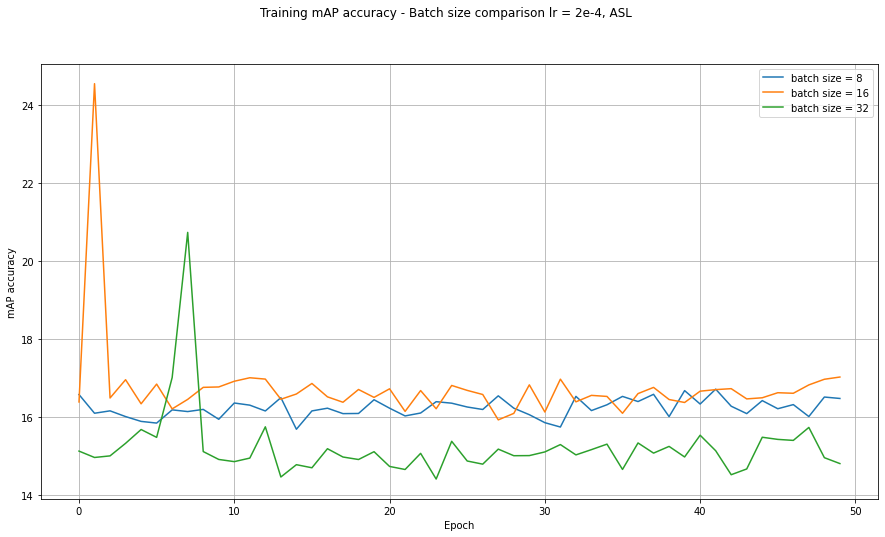

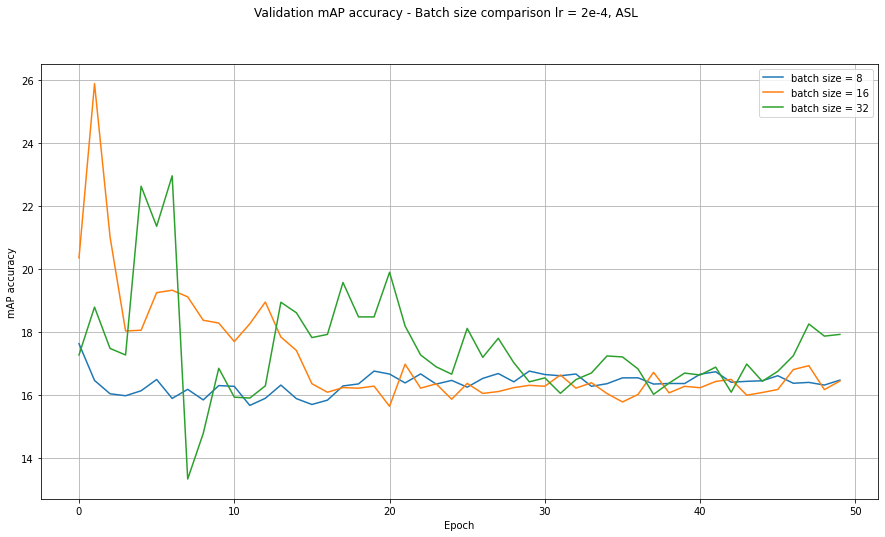

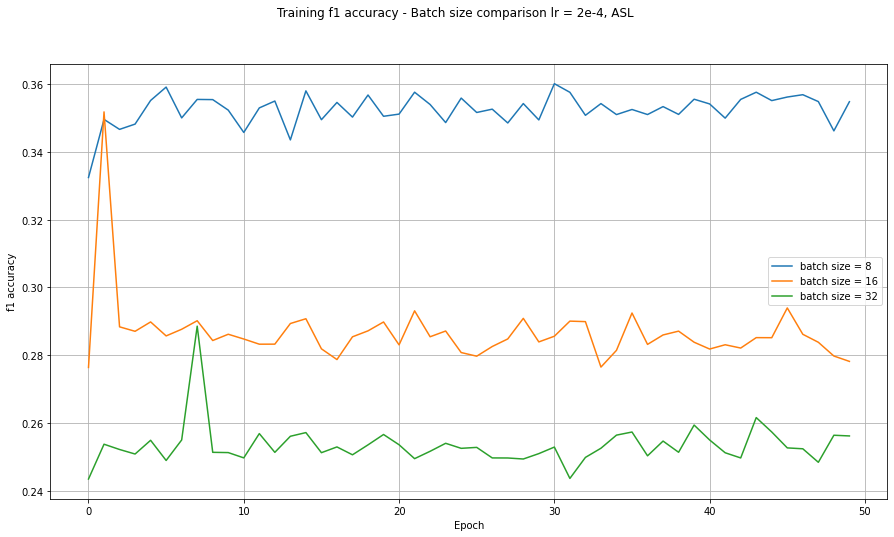

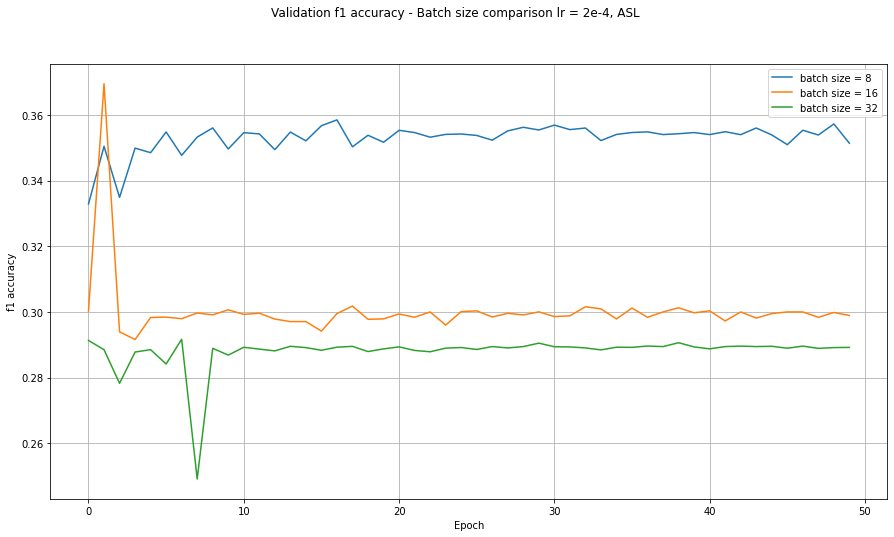

In [ ]:
## Add all combination of options as you'd like
combinations = [{'use_default_loss': 0, 'learning_rate': 2e-4, 'epochs': 50, 'batch_size': 8},
                {'use_default_loss': 0, 'learning_rate': 2e-4, 'epochs': 50, 'batch_size': 16},
                {'use_default_loss': 0, 'learning_rate': 2e-4, 'epochs': 50, 'batch_size': 32}]

labels = ['batch size = 8',
          'batch size = 16',
          'batch size = 32']
          
title = 'Batch size comparison lr = 2e-4, ASL'

combinations_results = []

for combination in combinations:

  use_default_loss = bool(combination['use_default_loss'])
  learning_rate = combination['learning_rate']
  epochs = combination['epochs']
  batch_size = combination['batch_size']

  results = train_and_plot_results(epochs, use_default_loss, learning_rate, batch_size, train_inputs, train_masks, train_labels,
                validation_inputs, validation_masks, validation_labels)
  combinations_results.append(results)

plot_results(combinations_results, labels, title)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a


Train loss: 83.37856175673905
Train Acc mAP: 22.235594341157753
Train Acc f1: 0.3850929521096748
Validation Acc mAP: 37.743081449926144
Validation Acc f1: 0.5555743642290702


Epoch:   2%|▏         | 1/50 [00:40<32:50, 40.21s/it]


Train loss: 49.416478714054165
Train Acc mAP: 40.16059854262319
Train Acc f1: 0.6497759917433327
Validation Acc mAP: 39.991424689395934
Validation Acc f1: 0.8051564899443976


Epoch:   4%|▍         | 2/50 [01:20<32:22, 40.47s/it]


Train loss: 36.707243795266635
Train Acc mAP: 40.829820994639995
Train Acc f1: 0.7972466071480242
Validation Acc mAP: 40.079504547538434
Validation Acc f1: 0.9186615720716009


Epoch:   6%|▌         | 3/50 [02:01<31:40, 40.43s/it]


Train loss: 32.491716169973465
Train Acc mAP: 41.78987278602328
Train Acc f1: 0.8725248149571252
Validation Acc mAP: 40.010997991053145
Validation Acc f1: 0.9530085556827641


Epoch:   8%|▊         | 4/50 [02:39<30:25, 39.68s/it]


Train loss: 30.12764540810652
Train Acc mAP: 40.491712251480365
Train Acc f1: 0.9154651854105961
Validation Acc mAP: 40.072164559196786
Validation Acc f1: 0.9602662561331166


Epoch:  10%|█         | 5/50 [03:18<29:30, 39.34s/it]


Train loss: 29.370162377183448
Train Acc mAP: 41.00682018633364
Train Acc f1: 0.9272103843744304


Epoch:  12%|█▏        | 6/50 [03:55<28:12, 38.47s/it]

Validation Acc mAP: 40.05993124565287
Validation Acc f1: 0.958578969135233

Train loss: 28.0752045052216
Train Acc mAP: 40.77276765322465
Train Acc f1: 0.9358448391909893


Epoch:  14%|█▍        | 7/50 [04:31<27:09, 37.89s/it]

Validation Acc mAP: 40.02078464201224
Validation Acc f1: 0.9598567165205647

Train loss: 27.024160907640027
Train Acc mAP: 41.74619652627788
Train Acc f1: 0.944960066134236
Validation Acc mAP: 40.28502421634185
Validation Acc f1: 0.9646091125397629


Epoch:  16%|█▌        | 8/50 [05:11<26:57, 38.50s/it]


Train loss: 26.85226960872509
Train Acc mAP: 40.896497474613014
Train Acc f1: 0.941179821306021
Validation Acc mAP: 40.40931468308191
Validation Acc f1: 0.958897396294432


Epoch:  18%|█▊        | 9/50 [05:50<26:20, 38.55s/it]


Train loss: 26.029160364267554
Train Acc mAP: 42.01259683467868
Train Acc f1: 0.9476777270553213
Validation Acc mAP: 40.41420800856799
Validation Acc f1: 0.9612182799140487


Epoch:  20%|██        | 10/50 [06:29<25:43, 38.58s/it]


Train loss: 24.70888993084302
Train Acc mAP: 41.67003570108363
Train Acc f1: 0.9479391416994017
Validation Acc mAP: 40.44161063119798
Validation Acc f1: 0.9612304705209603


Epoch:  22%|██▏       | 11/50 [07:07<25:02, 38.53s/it]


Train loss: 24.010673227373694
Train Acc mAP: 41.20263795969212
Train Acc f1: 0.9451898282547508


Epoch:  24%|██▍       | 12/50 [07:44<24:06, 38.05s/it]

Validation Acc mAP: 40.389741381121326
Validation Acc f1: 0.9595184543725602

Train loss: 23.106234633549086
Train Acc mAP: 42.153488212100775
Train Acc f1: 0.9462920388359997
Validation Acc mAP: 40.45335461225755
Validation Acc f1: 0.9575061764358244


Epoch:  26%|██▌       | 13/50 [08:22<23:28, 38.08s/it]


Train loss: 22.471204593504602
Train Acc mAP: 41.6650985617629
Train Acc f1: 0.9464661131189513
Validation Acc mAP: 40.463630595554186
Validation Acc f1: 0.9618041905901389


Epoch:  28%|██▊       | 14/50 [09:00<22:53, 38.15s/it]


Train loss: 21.286132240330844
Train Acc mAP: 42.18484500692133
Train Acc f1: 0.9470946215671721


Epoch:  30%|███       | 15/50 [09:37<22:02, 37.78s/it]

Validation Acc mAP: 40.2674082449156
Validation Acc f1: 0.9626400232643948

Train loss: 20.25933051178973
Train Acc mAP: 42.092770417263495
Train Acc f1: 0.9470920512301196


Epoch:  32%|███▏      | 16/50 [10:14<21:12, 37.43s/it]

Validation Acc mAP: 40.445199069797084
Validation Acc f1: 0.9581104101738848

Train loss: 19.808959431671337
Train Acc mAP: 42.38301804669275
Train Acc f1: 0.9495280911747358


Epoch:  34%|███▍      | 17/50 [10:51<20:27, 37.19s/it]

Validation Acc mAP: 40.36690586256475
Validation Acc f1: 0.9579953578004117

Train loss: 18.427043198825455
Train Acc mAP: 42.377379174317184
Train Acc f1: 0.9488970047044766


Epoch:  36%|███▌      | 18/50 [11:27<19:46, 37.06s/it]

Validation Acc mAP: 40.37506140487842
Validation Acc f1: 0.9605683185750128

Train loss: 17.42738912509795
Train Acc mAP: 42.40557487550687
Train Acc f1: 0.9504724664770121


Epoch:  38%|███▊      | 19/50 [12:04<19:04, 36.93s/it]

Validation Acc mAP: 40.382890725753356
Validation Acc f1: 0.9616734762012258

Train loss: 16.356151313312942
Train Acc mAP: 42.915410928661544
Train Acc f1: 0.9512790666987525


Epoch:  40%|████      | 20/50 [12:41<18:26, 36.88s/it]

Validation Acc mAP: 40.42702386097558
Validation Acc f1: 0.9600687566845493

Train loss: 15.559217033427654
Train Acc mAP: 42.723179409803016
Train Acc f1: 0.9500429916853461
Validation Acc mAP: 40.4827145649391
Validation Acc f1: 0.9606534029721596


Epoch:  42%|████▏     | 21/50 [13:19<18:00, 37.25s/it]


Train loss: 14.73532375100708
Train Acc mAP: 42.302126496293575
Train Acc f1: 0.949072456692757


Epoch:  44%|████▍     | 22/50 [13:56<17:19, 37.14s/it]

Validation Acc mAP: 40.46477237151954
Validation Acc f1: 0.9593013407778892

Train loss: 13.827462161807826
Train Acc mAP: 42.72696993258754
Train Acc f1: 0.9498298694663647


Epoch:  46%|████▌     | 23/50 [14:33<16:39, 37.02s/it]

Validation Acc mAP: 40.3554881030581
Validation Acc f1: 0.9602764662089549

Train loss: 12.940260824605538
Train Acc mAP: 41.82326282420185
Train Acc f1: 0.9505108696616421


Epoch:  48%|████▊     | 24/50 [15:09<15:59, 36.90s/it]

Validation Acc mAP: 40.40745055910634
Validation Acc f1: 0.9605376260695097

Train loss: 12.346208481904569
Train Acc mAP: 42.403378837541034
Train Acc f1: 0.9510113291392922


Epoch:  50%|█████     | 25/50 [15:46<15:20, 36.83s/it]

Validation Acc mAP: 40.47455902247862
Validation Acc f1: 0.9625050334302707

Train loss: 11.515826660039302
Train Acc mAP: 42.36752703407353
Train Acc f1: 0.9541096028959569


Epoch:  52%|█████▏    | 26/50 [16:23<14:44, 36.86s/it]

Validation Acc mAP: 40.45638381370606
Validation Acc f1: 0.9614610575670418

Train loss: 10.719087687121203
Train Acc mAP: 42.32982017693414
Train Acc f1: 0.9557797944919413
Validation Acc mAP: 40.494132324396816
Validation Acc f1: 0.9619284299007891


Epoch:  54%|█████▍    | 27/50 [17:01<14:16, 37.25s/it]


Train loss: 10.074929169532712
Train Acc mAP: 43.08888364290011
Train Acc f1: 0.95589547279061


Epoch:  56%|█████▌    | 28/50 [17:38<13:37, 37.16s/it]

Validation Acc mAP: 40.48923899884387
Validation Acc f1: 0.9609785322367638

Train loss: 9.562520109185428
Train Acc mAP: 42.430588038919154
Train Acc f1: 0.9549512028829829


Epoch:  58%|█████▊    | 29/50 [18:14<12:57, 37.00s/it]

Validation Acc mAP: 40.45638381372237
Validation Acc f1: 0.9599085782468092

Train loss: 8.959831578888563
Train Acc mAP: 43.002544165322504
Train Acc f1: 0.9573203228010768
Validation Acc mAP: 40.59339692644828
Validation Acc f1: 0.956171853964942


Epoch:  60%|██████    | 30/50 [18:53<12:26, 37.32s/it]


Train loss: 8.516761109763202
Train Acc mAP: 42.80269729061357
Train Acc f1: 0.9584996878237225


Epoch:  62%|██████▏   | 31/50 [19:30<11:47, 37.22s/it]

Validation Acc mAP: 40.42399465947814
Validation Acc f1: 0.9603184563995331

Train loss: 8.039949091797935
Train Acc mAP: 41.80503917018769
Train Acc f1: 0.9579688739701565


Epoch:  64%|██████▍   | 32/50 [20:06<11:06, 37.02s/it]

Validation Acc mAP: 40.463141263167714
Validation Acc f1: 0.9588489929807484

Train loss: 7.609698758721665
Train Acc mAP: 42.260577458748614
Train Acc f1: 0.9613305422669377


Epoch:  66%|██████▌   | 33/50 [20:43<10:27, 36.93s/it]

Validation Acc mAP: 40.41420800856799
Validation Acc f1: 0.95620483344981

Train loss: 7.146435076744857
Train Acc mAP: 42.41707726436726
Train Acc f1: 0.963514030354187


Epoch:  68%|██████▊   | 34/50 [21:19<09:49, 36.83s/it]

Validation Acc mAP: 40.502287866710475
Validation Acc f1: 0.9573515235034594

Train loss: 6.848854180547382
Train Acc mAP: 42.12528206072579
Train Acc f1: 0.9608999487061776


Epoch:  70%|███████   | 35/50 [21:56<09:11, 36.74s/it]

Validation Acc mAP: 40.57242553162915
Validation Acc f1: 0.9579285541102208

Train loss: 6.489081065713789
Train Acc mAP: 42.52854115444866
Train Acc f1: 0.9659042449809361


Epoch:  72%|███████▏  | 36/50 [22:33<08:34, 36.73s/it]

Validation Acc mAP: 40.48131647194494
Validation Acc f1: 0.9580025596624243

Train loss: 6.1801448556877165
Train Acc mAP: 42.686166858867246
Train Acc f1: 0.9655539565698364


Epoch:  74%|███████▍  | 37/50 [23:09<07:56, 36.67s/it]

Validation Acc mAP: 40.4729279141268
Validation Acc f1: 0.9618077875583867

Train loss: 5.78034389039762
Train Acc mAP: 42.748091242161834
Train Acc f1: 0.9674177451456343


Epoch:  76%|███████▌  | 38/50 [23:46<07:19, 36.63s/it]

Validation Acc mAP: 40.44659716289377
Validation Acc f1: 0.956959260148241

Train loss: 5.564341650271893
Train Acc mAP: 42.69010750036804
Train Acc f1: 0.9678509484056549


Epoch:  78%|███████▊  | 39/50 [24:22<06:43, 36.65s/it]

Validation Acc mAP: 40.48630300362954
Validation Acc f1: 0.9609225295603163

Train loss: 5.324124198500195
Train Acc mAP: 41.923933988899456
Train Acc f1: 0.969253591679897


Epoch:  80%|████████  | 40/50 [24:59<06:06, 36.62s/it]

Validation Acc mAP: 40.42748989189014
Validation Acc f1: 0.9591383858118788

Train loss: 4.9888818269026665
Train Acc mAP: 42.77792753789966
Train Acc f1: 0.9697045679927276


Epoch:  82%|████████▏ | 41/50 [25:36<05:29, 36.65s/it]

Validation Acc mAP: 40.54143447040005
Validation Acc f1: 0.9584316705289796

Train loss: 4.836436019775212
Train Acc mAP: 41.97459939398947
Train Acc f1: 0.9700249135431477


Epoch:  84%|████████▍ | 42/50 [26:12<04:53, 36.63s/it]

Validation Acc mAP: 40.57102743863499
Validation Acc f1: 0.9613786953756557

Train loss: 4.593265684012349
Train Acc mAP: 42.766190051449136
Train Acc f1: 0.9711700790070614


Epoch:  86%|████████▌ | 43/50 [26:49<04:16, 36.62s/it]

Validation Acc mAP: 40.49902564980296
Validation Acc f1: 0.9611391354840564

Train loss: 4.369216601503347
Train Acc mAP: 41.70776159491111
Train Acc f1: 0.9711635887585987
Validation Acc mAP: 40.61352946551054
Validation Acc f1: 0.9585517449941664


Epoch:  88%|████████▊ | 44/50 [27:27<03:42, 37.10s/it]


Train loss: 4.137171634579901
Train Acc mAP: 42.56569578549699
Train Acc f1: 0.9730031421636465


Epoch:  90%|█████████ | 45/50 [28:04<03:04, 37.00s/it]

Validation Acc mAP: 40.40018047553206
Validation Acc f1: 0.9575475327171964

Train loss: 3.9730972854103044
Train Acc mAP: 42.16712793314226
Train Acc f1: 0.9736998010986493


Epoch:  92%|█████████▏| 46/50 [28:40<02:27, 36.87s/it]

Validation Acc mAP: 40.51125896342842
Validation Acc f1: 0.9619719520703401

Train loss: 3.8393206595148133
Train Acc mAP: 42.3427680025702
Train Acc f1: 0.9747290159018488


Epoch:  94%|█████████▍| 47/50 [29:17<01:50, 36.83s/it]

Validation Acc mAP: 40.558561109431665
Validation Acc f1: 0.9600035586562945

Train loss: 3.6236827705900856
Train Acc mAP: 43.10274907793369
Train Acc f1: 0.9750668082839903
Validation Acc mAP: 40.65910729682642
Validation Acc f1: 0.9607782887919956


Epoch:  96%|█████████▌| 48/50 [29:55<01:14, 37.21s/it]


Train loss: 3.438189948440967
Train Acc mAP: 42.55556270346109
Train Acc f1: 0.9765897363286036


Epoch:  98%|█████████▊| 49/50 [30:32<00:37, 37.16s/it]

Validation Acc mAP: 40.511258963444725
Validation Acc f1: 0.9606918229021544

Train loss: 3.3133961208904075
Train Acc mAP: 42.48800883096456
Train Acc f1: 0.9773614948903327


Epoch: 100%|██████████| 50/50 [31:09<00:00, 37.39s/it]

Validation Acc mAP: 40.51990383844663
Validation Acc f1: 0.961297539336688



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions 


Train loss: 170.69014608356102
Train Acc mAP: 22.74804476348466
Train Acc f1: 0.30072288211097287
Validation Acc mAP: 44.8121976401195
Validation Acc f1: 0.42200320460698865


Epoch:   2%|▏         | 1/50 [00:38<31:10, 38.18s/it]


Train loss: 119.16783833241585
Train Acc mAP: 50.86731920601406
Train Acc f1: 0.4903190483962894
Validation Acc mAP: 54.72848247476186
Validation Acc f1: 0.6095947163717366


Epoch:   4%|▍         | 2/50 [01:17<30:52, 38.60s/it]


Train loss: 83.4892087813174
Train Acc mAP: 59.000352406555315
Train Acc f1: 0.6030960460097758
Validation Acc mAP: 55.129631364225155
Validation Acc f1: 0.7619290145028658


Epoch:   6%|▌         | 3/50 [01:55<30:12, 38.57s/it]


Train loss: 71.85097990772229
Train Acc mAP: 58.072232615089696
Train Acc f1: 0.703677277175178
Validation Acc mAP: 54.79906286837024
Validation Acc f1: 0.8612398326782478


Epoch:   8%|▊         | 4/50 [02:32<28:58, 37.80s/it]


Train loss: 65.1952317599576
Train Acc mAP: 60.06273100279063
Train Acc f1: 0.7796145996916883
Validation Acc mAP: 55.2747301142648
Validation Acc f1: 0.9054779812936956


Epoch:  10%|█         | 5/50 [03:10<28:26, 37.93s/it]


Train loss: 61.40602911298714
Train Acc mAP: 58.926094598107674
Train Acc f1: 0.8319648200042621
Validation Acc mAP: 55.24677884650042
Validation Acc f1: 0.9267073569175784


Epoch:  12%|█▏        | 6/50 [03:46<27:27, 37.44s/it]


Train loss: 58.70752814642808
Train Acc mAP: 60.475883323129764
Train Acc f1: 0.8584581086502288
Validation Acc mAP: 55.52009543396672
Validation Acc f1: 0.9303004272393337


Epoch:  14%|█▍        | 7/50 [04:25<27:01, 37.70s/it]


Train loss: 56.83873189646123
Train Acc mAP: 59.584791755645
Train Acc f1: 0.8760558283632839
Validation Acc mAP: 55.67885312959407
Validation Acc f1: 0.9322584416271182


Epoch:  16%|█▌        | 8/50 [05:03<26:31, 37.88s/it]


Train loss: 54.4736665523202
Train Acc mAP: 61.07441462627756
Train Acc f1: 0.8856035887248143
Validation Acc mAP: 55.85625418333101
Validation Acc f1: 0.9365322315515244


Epoch:  18%|█▊        | 9/50 [05:41<25:57, 37.99s/it]


Train loss: 52.58481082951294
Train Acc mAP: 60.21578481860115
Train Acc f1: 0.8944443581585009
Validation Acc mAP: 56.10616330477548
Validation Acc f1: 0.9297593352795628


Epoch:  20%|██        | 10/50 [06:18<25:02, 37.55s/it]


Train loss: 50.91641493326466
Train Acc mAP: 61.32018851177537
Train Acc f1: 0.8959673829520666
Validation Acc mAP: 56.14113681269168
Validation Acc f1: 0.9335414815313005


Epoch:  22%|██▏       | 11/50 [06:54<24:13, 37.26s/it]


Train loss: 49.149009999901516
Train Acc mAP: 62.290840741077524
Train Acc f1: 0.8990337854557942
Validation Acc mAP: 56.392230076950334
Validation Acc f1: 0.9345077943123731


Epoch:  24%|██▍       | 12/50 [07:31<23:28, 37.05s/it]


Train loss: 47.210297787348594
Train Acc mAP: 60.615215566111154
Train Acc f1: 0.9020756200989258
Validation Acc mAP: 56.633382052550154
Validation Acc f1: 0.9336241452714383


Epoch:  26%|██▌       | 13/50 [08:07<22:43, 36.86s/it]


Train loss: 45.29586743058589
Train Acc mAP: 61.9387802310385
Train Acc f1: 0.902484838505871


Epoch:  28%|██▊       | 14/50 [08:42<21:45, 36.27s/it]

Validation Acc mAP: 56.61786231307915
Validation Acc f1: 0.9331659582650873

Train loss: 43.555821333108156
Train Acc mAP: 63.011163588689136
Train Acc f1: 0.902018716012902


Epoch:  30%|███       | 15/50 [09:17<20:53, 35.82s/it]

Validation Acc mAP: 56.47507677010352
Validation Acc f1: 0.9347651603404303

Train loss: 41.57895821121456
Train Acc mAP: 62.5751535402056
Train Acc f1: 0.9041394157644973
Validation Acc mAP: 56.66206111632123
Validation Acc f1: 0.9336557905490191


Epoch:  32%|███▏      | 16/50 [09:53<20:22, 35.96s/it]


Train loss: 39.67057393499807
Train Acc mAP: 63.65493294045498
Train Acc f1: 0.9023959050547206


Epoch:  34%|███▍      | 17/50 [10:28<19:36, 35.64s/it]

Validation Acc mAP: 56.615411413138304
Validation Acc f1: 0.9337196481922917

Train loss: 37.863999444655526
Train Acc mAP: 63.79491295957741
Train Acc f1: 0.9034833752247657
Validation Acc mAP: 56.714383687169025
Validation Acc f1: 0.9341959346254635


Epoch:  36%|███▌      | 18/50 [11:05<19:13, 36.05s/it]


Train loss: 36.067718957925486
Train Acc mAP: 63.42695317158594
Train Acc f1: 0.9055520056230092
Validation Acc mAP: 56.81737653727406
Validation Acc f1: 0.936290734558131


Epoch:  38%|███▊      | 19/50 [11:42<18:41, 36.18s/it]


Train loss: 34.390463293300705
Train Acc mAP: 63.338188748063324
Train Acc f1: 0.9054135454901314
Validation Acc mAP: 56.93317464834873
Validation Acc f1: 0.9340009712594209


Epoch:  40%|████      | 20/50 [12:18<18:09, 36.33s/it]


Train loss: 32.59479382295794
Train Acc mAP: 64.1196110486267
Train Acc f1: 0.911722014221815


Epoch:  42%|████▏     | 21/50 [12:53<17:20, 35.89s/it]

Validation Acc mAP: 56.7655696819043
Validation Acc f1: 0.9347667109940943

Train loss: 31.019316365421393
Train Acc mAP: 62.8648939520132
Train Acc f1: 0.9035490367489526


Epoch:  44%|████▍     | 22/50 [13:28<16:35, 35.54s/it]

Validation Acc mAP: 56.92005895657716
Validation Acc f1: 0.9332166262790427

Train loss: 29.523490413148284
Train Acc mAP: 63.363538416964836
Train Acc f1: 0.9075637177291348


Epoch:  46%|████▌     | 23/50 [14:03<15:53, 35.31s/it]

Validation Acc mAP: 56.876859038531244
Validation Acc f1: 0.9351283948548529

Train loss: 28.088750370911143
Train Acc mAP: 63.36647563529052
Train Acc f1: 0.912740658848989
Validation Acc mAP: 57.10159824989085
Validation Acc f1: 0.9341692123729636


Epoch:  48%|████▊     | 24/50 [14:39<15:26, 35.62s/it]


Train loss: 26.61466885731783
Train Acc mAP: 64.06018392843221
Train Acc f1: 0.9107534217255031
Validation Acc mAP: 57.11947053880902
Validation Acc f1: 0.9380789446813059


Epoch:  50%|█████     | 25/50 [15:17<15:10, 36.41s/it]


Train loss: 24.97751073467161
Train Acc mAP: 64.95376353340234
Train Acc f1: 0.9138528570995803
Validation Acc mAP: 57.240328167255655
Validation Acc f1: 0.9356634998831839


Epoch:  52%|█████▏    | 26/50 [15:54<14:36, 36.53s/it]


Train loss: 23.889502419968096
Train Acc mAP: 63.00529310428146
Train Acc f1: 0.9158680235055393


Epoch:  54%|█████▍    | 27/50 [16:29<13:48, 36.03s/it]

Validation Acc mAP: 57.04555802234608
Validation Acc f1: 0.9353911113521319

Train loss: 22.937004384840762
Train Acc mAP: 63.18340703039725
Train Acc f1: 0.9153909789687965
Validation Acc mAP: 57.25897116757162
Validation Acc f1: 0.9376575584243136


Epoch:  56%|█████▌    | 28/50 [17:06<13:17, 36.25s/it]


Train loss: 21.57738897973403
Train Acc mAP: 63.37475322742912
Train Acc f1: 0.9169305762362417


Epoch:  58%|█████▊    | 29/50 [17:41<12:32, 35.82s/it]

Validation Acc mAP: 57.20177469354022
Validation Acc f1: 0.9357081741573045

Train loss: 20.977636816852865
Train Acc mAP: 62.112926072818404
Train Acc f1: 0.9181258324542763


Epoch:  60%|██████    | 30/50 [18:15<11:49, 35.49s/it]

Validation Acc mAP: 57.06174297098135
Validation Acc f1: 0.9347216086811988

Train loss: 19.62840448183254
Train Acc mAP: 62.00906166099638
Train Acc f1: 0.9206971905506202


Epoch:  62%|██████▏   | 31/50 [18:50<11:10, 35.27s/it]

Validation Acc mAP: 57.20852155194026
Validation Acc f1: 0.9366462757270785

Train loss: 18.78657109433694
Train Acc mAP: 63.00542448319607
Train Acc f1: 0.9235658868553175
Validation Acc mAP: 57.08284473906944
Validation Acc f1: 0.9403638467438796


Epoch:  64%|██████▍   | 32/50 [19:26<10:41, 35.62s/it]


Train loss: 17.965102856987038
Train Acc mAP: 63.477558076640385
Train Acc f1: 0.9244626778362867


Epoch:  66%|██████▌   | 33/50 [20:01<10:01, 35.40s/it]

Validation Acc mAP: 57.12734646274652
Validation Acc f1: 0.9394691139933011

Train loss: 16.98826541086942
Train Acc mAP: 63.67070355415269
Train Acc f1: 0.9280244507766617


Epoch:  68%|██████▊   | 34/50 [20:36<09:23, 35.23s/it]

Validation Acc mAP: 57.10090979470164
Validation Acc f1: 0.9373758867432318

Train loss: 16.172863225055192
Train Acc mAP: 62.53790709434634
Train Acc f1: 0.927838390329209


Epoch:  70%|███████   | 35/50 [21:11<08:45, 35.07s/it]

Validation Acc mAP: 57.08972928776798
Validation Acc f1: 0.9375770122379851

Train loss: 15.58215302296805
Train Acc mAP: 64.46140750900292
Train Acc f1: 0.9288224615079232
Validation Acc mAP: 56.980170545193964
Validation Acc f1: 0.940649322036525


Epoch:  72%|███████▏  | 36/50 [21:47<08:16, 35.49s/it]


Train loss: 14.877667771075886
Train Acc mAP: 62.896075625108736
Train Acc f1: 0.9324013655443485
Validation Acc mAP: 57.27860196668745
Validation Acc f1: 0.9410611267249571


Epoch:  74%|███████▍  | 37/50 [22:26<07:54, 36.54s/it]


Train loss: 14.269077784579325
Train Acc mAP: 64.52390472177868
Train Acc f1: 0.9341656819141206


Epoch:  76%|███████▌  | 38/50 [23:01<07:13, 36.08s/it]

Validation Acc mAP: 57.05160891523946
Validation Acc f1: 0.9373953907786399

Train loss: 13.766644164131062
Train Acc mAP: 65.13927902366419
Train Acc f1: 0.9371030303155865
Validation Acc mAP: 57.240032757590825
Validation Acc f1: 0.942607961660047


Epoch:  78%|███████▊  | 39/50 [23:38<06:39, 36.35s/it]


Train loss: 13.510243743219538
Train Acc mAP: 62.58202714917
Train Acc f1: 0.9341883442593574
Validation Acc mAP: 57.29849634601246
Validation Acc f1: 0.9423954158343102


Epoch:  80%|████████  | 40/50 [24:15<06:04, 36.41s/it]


Train loss: 12.741088527390094
Train Acc mAP: 63.37217043378853
Train Acc f1: 0.9376294592965007


Epoch:  82%|████████▏ | 41/50 [24:50<05:23, 35.96s/it]

Validation Acc mAP: 57.054736109893256
Validation Acc f1: 0.9412444760328833

Train loss: 12.277936872090901
Train Acc mAP: 62.32534217707383
Train Acc f1: 0.939090112771646


Epoch:  84%|████████▍ | 42/50 [25:24<04:44, 35.58s/it]

Validation Acc mAP: 57.03646290830765
Validation Acc f1: 0.9385379917979338

Train loss: 11.839185346818521
Train Acc mAP: 63.52729743798536
Train Acc f1: 0.9408078837011208


Epoch:  86%|████████▌ | 43/50 [25:59<04:07, 35.31s/it]

Validation Acc mAP: 57.175471425802186
Validation Acc f1: 0.9384024238796028

Train loss: 11.543561707701379
Train Acc mAP: 63.80072272385666
Train Acc f1: 0.9410458108860711


Epoch:  88%|████████▊ | 44/50 [26:34<03:30, 35.12s/it]

Validation Acc mAP: 57.106444972896625
Validation Acc f1: 0.9381759638947749

Train loss: 11.016506215848342
Train Acc mAP: 63.00388331180615
Train Acc f1: 0.9409744701143893


Epoch:  90%|█████████ | 45/50 [27:08<02:54, 34.99s/it]

Validation Acc mAP: 56.982146995496045
Validation Acc f1: 0.9401860585129425

Train loss: 10.681059151136878
Train Acc mAP: 64.5463925569412
Train Acc f1: 0.9455377815194889


Epoch:  92%|█████████▏| 46/50 [27:43<02:19, 34.97s/it]

Validation Acc mAP: 57.11091402816526
Validation Acc f1: 0.9390197590991739

Train loss: 10.151930711442459
Train Acc mAP: 64.6913079619282
Train Acc f1: 0.9473138621580494
Validation Acc mAP: 57.24266891402823
Validation Acc f1: 0.9430976573850763


Epoch:  94%|█████████▍| 47/50 [28:20<01:46, 35.39s/it]


Train loss: 9.849757124673713
Train Acc mAP: 63.192490957310795
Train Acc f1: 0.9479882161102027


Epoch:  96%|█████████▌| 48/50 [28:55<01:10, 35.25s/it]

Validation Acc mAP: 57.135167310305235
Validation Acc f1: 0.9423013800169743

Train loss: 9.473593169518628
Train Acc mAP: 64.49712020188409
Train Acc f1: 0.948738166183789
Validation Acc mAP: 57.19602672118696
Validation Acc f1: 0.9444788079196059


Epoch:  98%|█████████▊| 49/50 [29:32<00:35, 35.71s/it]


Train loss: 9.026890768186274
Train Acc mAP: 63.433551622153416
Train Acc f1: 0.9515522489531444


Epoch: 100%|██████████| 50/50 [30:06<00:00, 36.14s/it]

Validation Acc mAP: 56.99103239639187
Validation Acc f1: 0.9417130361083118



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions 


Train loss: 339.6093914382805
Train Acc mAP: 16.219384634163095
Train Acc f1: 0.24663527528252904
Validation Acc mAP: 24.948408720683318
Validation Acc f1: 0.2945229148354776


Epoch:   2%|▏         | 1/50 [00:37<30:14, 37.03s/it]


Train loss: 325.4670486594948
Train Acc mAP: 29.720721290149967
Train Acc f1: 0.2894014569166383
Validation Acc mAP: 49.21026324069385
Validation Acc f1: 0.4096579960483138


Epoch:   4%|▍         | 2/50 [01:14<29:47, 37.24s/it]


Train loss: 242.90257539181562
Train Acc mAP: 58.65904703487557
Train Acc f1: 0.4125021284151405
Validation Acc mAP: 59.70342794321414
Validation Acc f1: 0.5730874856913442


Epoch:   6%|▌         | 3/50 [01:52<29:19, 37.44s/it]


Train loss: 186.40526895688964
Train Acc mAP: 67.76104792190017
Train Acc f1: 0.5085813606899784
Validation Acc mAP: 62.0169282259059
Validation Acc f1: 0.6621979586207122


Epoch:   8%|▊         | 4/50 [02:29<28:38, 37.36s/it]


Train loss: 159.82990322242242
Train Acc mAP: 69.82516439802095
Train Acc f1: 0.5755255654270421
Validation Acc mAP: 62.69763313884005
Validation Acc f1: 0.7207163637961587


Epoch:  10%|█         | 5/50 [03:06<27:59, 37.32s/it]


Train loss: 143.46698435348605
Train Acc mAP: 72.83576048051515
Train Acc f1: 0.6289538167203116
Validation Acc mAP: 62.63362431666951
Validation Acc f1: 0.7716650576799193


Epoch:  12%|█▏        | 6/50 [03:42<26:54, 36.69s/it]


Train loss: 132.02095089537934
Train Acc mAP: 70.74675231536042
Train Acc f1: 0.7033448279549069
Validation Acc mAP: 63.32369534676876
Validation Acc f1: 0.8737310407989194


Epoch:  14%|█▍        | 7/50 [04:19<26:24, 36.85s/it]


Train loss: 125.56196511852245
Train Acc mAP: 72.61862202536865
Train Acc f1: 0.7479382361912997
Validation Acc mAP: 63.084911071727035
Validation Acc f1: 0.8904996923440585


Epoch:  16%|█▌        | 8/50 [04:54<25:27, 36.38s/it]


Train loss: 120.358264724307
Train Acc mAP: 72.28185029831452
Train Acc f1: 0.7849332434762568
Validation Acc mAP: 63.448403784649784
Validation Acc f1: 0.9093105147305381


Epoch:  18%|█▊        | 9/50 [05:31<25:01, 36.61s/it]


Train loss: 115.92353139743896
Train Acc mAP: 73.55160567815304
Train Acc f1: 0.8175563509527977
Validation Acc mAP: 63.618779155729015
Validation Acc f1: 0.9164473741756446


Epoch:  20%|██        | 10/50 [06:09<24:40, 37.01s/it]


Train loss: 113.22440984354101
Train Acc mAP: 73.4978387753567
Train Acc f1: 0.8291082144504823
Validation Acc mAP: 63.77317204840355
Validation Acc f1: 0.9225306593578115


Epoch:  22%|██▏       | 11/50 [06:47<24:14, 37.29s/it]


Train loss: 110.74934878154885
Train Acc mAP: 74.12954966524767
Train Acc f1: 0.8412749329912202


Epoch:  24%|██▍       | 12/50 [07:21<22:57, 36.26s/it]

Validation Acc mAP: 63.31631339009567
Validation Acc f1: 0.9214745982697602

Train loss: 107.66671704197498
Train Acc mAP: 75.45141687355004
Train Acc f1: 0.850897580040685


Epoch:  26%|██▌       | 13/50 [07:55<21:53, 35.49s/it]

Validation Acc mAP: 63.766149808785286
Validation Acc f1: 0.9216775713435101

Train loss: 105.56811979562396
Train Acc mAP: 74.99272078289354
Train Acc f1: 0.8577538686658854
Validation Acc mAP: 63.86319991590433
Validation Acc f1: 0.9278703915339015


Epoch:  28%|██▊       | 14/50 [08:32<21:34, 35.97s/it]


Train loss: 103.80809742135351
Train Acc mAP: 75.13104293715344
Train Acc f1: 0.8623479218410167


Epoch:  30%|███       | 15/50 [09:06<20:36, 35.34s/it]

Validation Acc mAP: 63.808747954116626
Validation Acc f1: 0.9252169368402123

Train loss: 101.17931150298308
Train Acc mAP: 75.36344771711586
Train Acc f1: 0.8631297301092504
Validation Acc mAP: 63.92624804665424
Validation Acc f1: 0.9233402850900003


Epoch:  32%|███▏      | 16/50 [09:41<20:00, 35.32s/it]


Train loss: 98.77109754538535
Train Acc mAP: 75.4073943313999
Train Acc f1: 0.8642909909354693


Epoch:  34%|███▍      | 17/50 [10:15<19:10, 34.87s/it]

Validation Acc mAP: 63.924392659220544
Validation Acc f1: 0.9273995534816176

Train loss: 96.26943463407764
Train Acc mAP: 75.69059038924708
Train Acc f1: 0.8643525982525461
Validation Acc mAP: 64.37368852273013
Validation Acc f1: 0.9236046236313259


Epoch:  36%|███▌      | 18/50 [10:50<18:40, 35.00s/it]


Train loss: 94.54184460329701
Train Acc mAP: 75.61614585830587
Train Acc f1: 0.8695061064443135


Epoch:  38%|███▊      | 19/50 [11:24<17:53, 34.64s/it]

Validation Acc mAP: 64.26562274087347
Validation Acc f1: 0.9233128385808607

Train loss: 91.94071937211275
Train Acc mAP: 77.31725906263232
Train Acc f1: 0.8688205627273052
Validation Acc mAP: 64.43315272851005
Validation Acc f1: 0.9256659620215548


Epoch:  40%|████      | 20/50 [11:59<17:25, 34.87s/it]


Train loss: 89.64930086471452
Train Acc mAP: 77.19571664055778
Train Acc f1: 0.8713033987138975
Validation Acc mAP: 64.48464060026961
Validation Acc f1: 0.9225934571743296


Epoch:  42%|████▏     | 21/50 [12:35<16:59, 35.16s/it]


Train loss: 88.63540835983079
Train Acc mAP: 78.54013125325898
Train Acc f1: 0.8719329686143775
Validation Acc mAP: 64.64693294295631
Validation Acc f1: 0.923457610924761


Epoch:  44%|████▍     | 22/50 [13:11<16:27, 35.28s/it]


Train loss: 84.53191494011489
Train Acc mAP: 78.16664985705407
Train Acc f1: 0.871828556810826
Validation Acc mAP: 64.9679809694025
Validation Acc f1: 0.9208285038967569


Epoch:  46%|████▌     | 23/50 [13:46<15:53, 35.33s/it]


Train loss: 81.931361786902
Train Acc mAP: 80.3219642835432
Train Acc f1: 0.8717026055965407
Validation Acc mAP: 64.98671847287247
Validation Acc f1: 0.9239643854984648


Epoch:  48%|████▊     | 24/50 [14:21<15:19, 35.35s/it]


Train loss: 80.54604864791185
Train Acc mAP: 79.20083427537334
Train Acc f1: 0.8708380384237792
Validation Acc mAP: 64.92052095529093
Validation Acc f1: 0.9282362970892687


Epoch:  50%|█████     | 25/50 [14:57<14:44, 35.40s/it]


Train loss: 78.26577228176869
Train Acc mAP: 78.80369643164248
Train Acc f1: 0.8734812977895694
Validation Acc mAP: 65.38944134272225
Validation Acc f1: 0.923836452534302


Epoch:  52%|█████▏    | 26/50 [15:33<14:15, 35.63s/it]


Train loss: 75.67521241676803
Train Acc mAP: 79.9617518696092
Train Acc f1: 0.8711619445022806


Epoch:  54%|█████▍    | 27/50 [16:07<13:26, 35.08s/it]

Validation Acc mAP: 65.24650089825077
Validation Acc f1: 0.921450921916835

Train loss: 72.96478717931737
Train Acc mAP: 80.12463764999171
Train Acc f1: 0.8684622368715494


Epoch:  56%|█████▌    | 28/50 [16:41<12:42, 34.67s/it]

Validation Acc mAP: 65.12945255338366
Validation Acc f1: 0.9190858223603013

Train loss: 71.17081835300775
Train Acc mAP: 79.30273801136445
Train Acc f1: 0.8729240814507103


Epoch:  58%|█████▊    | 29/50 [17:14<12:01, 34.38s/it]

Validation Acc mAP: 65.04642214111476
Validation Acc f1: 0.9219693282057038

Train loss: 69.15840286463634
Train Acc mAP: 80.30822436932509
Train Acc f1: 0.8735228919410652


Epoch:  60%|██████    | 30/50 [17:48<11:23, 34.17s/it]

Validation Acc mAP: 65.37987664027374
Validation Acc f1: 0.9209278684481026

Train loss: 66.44234512071658
Train Acc mAP: 79.82131413802084
Train Acc f1: 0.8752288875103221
Validation Acc mAP: 65.47529648709174
Validation Acc f1: 0.9131399746427882


Epoch:  62%|██████▏   | 31/50 [18:24<10:58, 34.68s/it]


Train loss: 64.0735447766738
Train Acc mAP: 80.45815771705747
Train Acc f1: 0.874035140276061
Validation Acc mAP: 65.48401490814373
Validation Acc f1: 0.9167576254643193


Epoch:  64%|██████▍   | 32/50 [18:59<10:28, 34.91s/it]


Train loss: 62.3210106570632
Train Acc mAP: 80.86732196302182
Train Acc f1: 0.8756130950741613
Validation Acc mAP: 65.64528770111548
Validation Acc f1: 0.9149027768682599


Epoch:  66%|██████▌   | 33/50 [19:35<09:55, 35.04s/it]


Train loss: 60.549080139621935
Train Acc mAP: 80.86903745502126
Train Acc f1: 0.8762236717678609


Epoch:  68%|██████▊   | 34/50 [20:09<09:14, 34.67s/it]

Validation Acc mAP: 65.6293162369427
Validation Acc f1: 0.9156823817454752

Train loss: 57.87985762801868
Train Acc mAP: 79.75986545396356
Train Acc f1: 0.8747972132112223


Epoch:  70%|███████   | 35/50 [20:42<08:35, 34.38s/it]

Validation Acc mAP: 65.55271530401198
Validation Acc f1: 0.9189616670655796

Train loss: 56.57300939781759
Train Acc mAP: 80.87992902428911
Train Acc f1: 0.8785229827205564
Validation Acc mAP: 65.85183075841891
Validation Acc f1: 0.918668615413918


Epoch:  72%|███████▏  | 36/50 [21:18<08:05, 34.66s/it]


Train loss: 54.872687963794775
Train Acc mAP: 82.6573706386988
Train Acc f1: 0.8803422752611997


Epoch:  74%|███████▍  | 37/50 [21:51<07:27, 34.40s/it]

Validation Acc mAP: 65.76514258430319
Validation Acc f1: 0.9216379937630682

Train loss: 52.83736110329762
Train Acc mAP: 82.69026387432532
Train Acc f1: 0.8764563368251965
Validation Acc mAP: 66.01760874856487
Validation Acc f1: 0.922343162221399


Epoch:  76%|███████▌  | 38/50 [22:27<06:55, 34.66s/it]


Train loss: 51.25437552831252
Train Acc mAP: 80.3378435128996
Train Acc f1: 0.8819633748149973


Epoch:  78%|███████▊  | 39/50 [23:00<06:18, 34.42s/it]

Validation Acc mAP: 65.78731083234207
Validation Acc f1: 0.920272689968763

Train loss: 49.01067758375574
Train Acc mAP: 81.0758449698384
Train Acc f1: 0.8826665527716446


Epoch:  80%|████████  | 40/50 [23:34<05:42, 34.20s/it]

Validation Acc mAP: 65.61989237453132
Validation Acc f1: 0.9170709982172536

Train loss: 47.406258525126205
Train Acc mAP: 80.61151097012007
Train Acc f1: 0.8820470374098913


Epoch:  82%|████████▏ | 41/50 [24:08<05:06, 34.05s/it]

Validation Acc mAP: 65.87645363838158
Validation Acc f1: 0.9223067088112196

Train loss: 46.527708189779496
Train Acc mAP: 82.16308836589005
Train Acc f1: 0.8824979887981151


Epoch:  84%|████████▍ | 42/50 [24:42<04:31, 33.94s/it]

Validation Acc mAP: 65.77346531659964
Validation Acc f1: 0.921900909513734

Train loss: 44.504969797989595
Train Acc mAP: 81.23476102025745
Train Acc f1: 0.8876355316643207


Epoch:  86%|████████▌ | 43/50 [25:16<03:58, 34.01s/it]

Validation Acc mAP: 65.66129398582649
Validation Acc f1: 0.922363319076941

Train loss: 43.536718129382365
Train Acc mAP: 80.84085981633295
Train Acc f1: 0.8859319648747278


Epoch:  88%|████████▊ | 44/50 [25:49<03:23, 33.92s/it]

Validation Acc mAP: 65.6772779623578
Validation Acc f1: 0.9255214909070144

Train loss: 42.03378352026296
Train Acc mAP: 81.9032480245353
Train Acc f1: 0.8873648753973423


Epoch:  90%|█████████ | 45/50 [26:23<02:49, 33.86s/it]

Validation Acc mAP: 65.83367374102137
Validation Acc f1: 0.9240010722533182

Train loss: 40.819603847559485
Train Acc mAP: 81.89798935647498
Train Acc f1: 0.8881687914879185


Epoch:  92%|█████████▏| 46/50 [26:57<02:15, 33.82s/it]

Validation Acc mAP: 65.96796277025861
Validation Acc f1: 0.9242559686113615

Train loss: 39.617568569627934
Train Acc mAP: 80.30103640812584
Train Acc f1: 0.8921107151292178
Validation Acc mAP: 66.14068233086243
Validation Acc f1: 0.9250708720924564


Epoch:  94%|█████████▍| 47/50 [27:33<01:43, 34.42s/it]


Train loss: 37.86808113165354
Train Acc mAP: 80.94944714730015
Train Acc f1: 0.8911683126015832


Epoch:  96%|█████████▌| 48/50 [28:06<01:08, 34.24s/it]

Validation Acc mAP: 65.85510229652718
Validation Acc f1: 0.9262392326846062

Train loss: 37.104543087855106
Train Acc mAP: 83.10461982292657
Train Acc f1: 0.8925644547602322
Validation Acc mAP: 66.31444283532176
Validation Acc f1: 0.9235313689457255


Epoch:  98%|█████████▊| 49/50 [28:42<00:34, 34.55s/it]


Train loss: 35.82253488513636
Train Acc mAP: 81.23414013654283
Train Acc f1: 0.8954615725180366
Validation Acc mAP: 66.39472918630752
Validation Acc f1: 0.9227812657571167


Epoch: 100%|██████████| 50/50 [29:17<00:00, 35.16s/it]


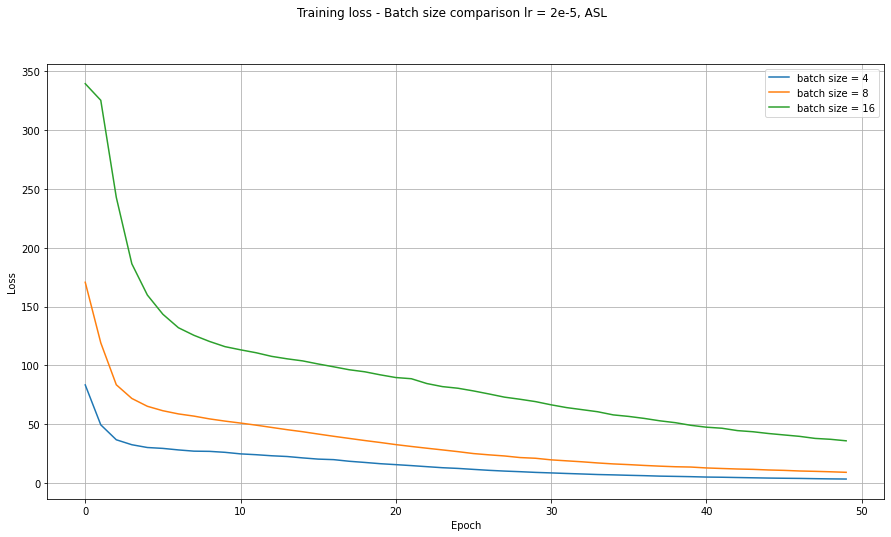

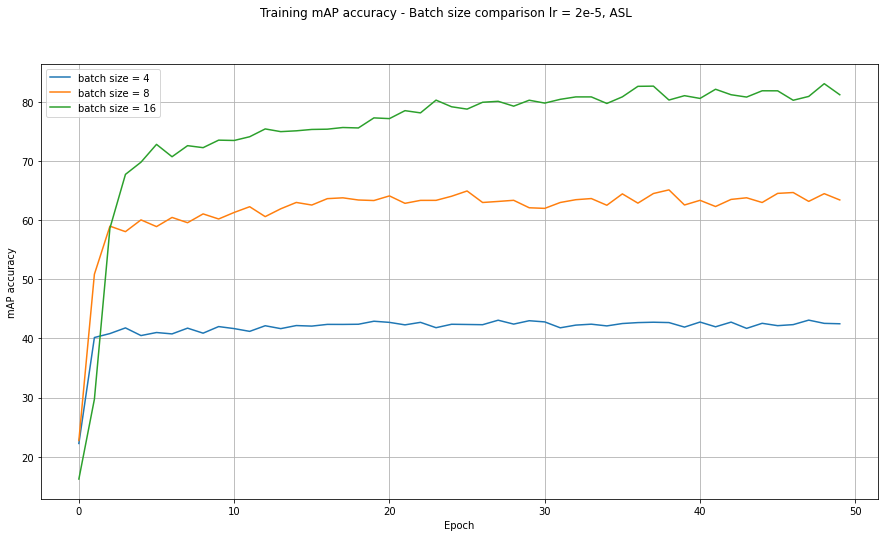

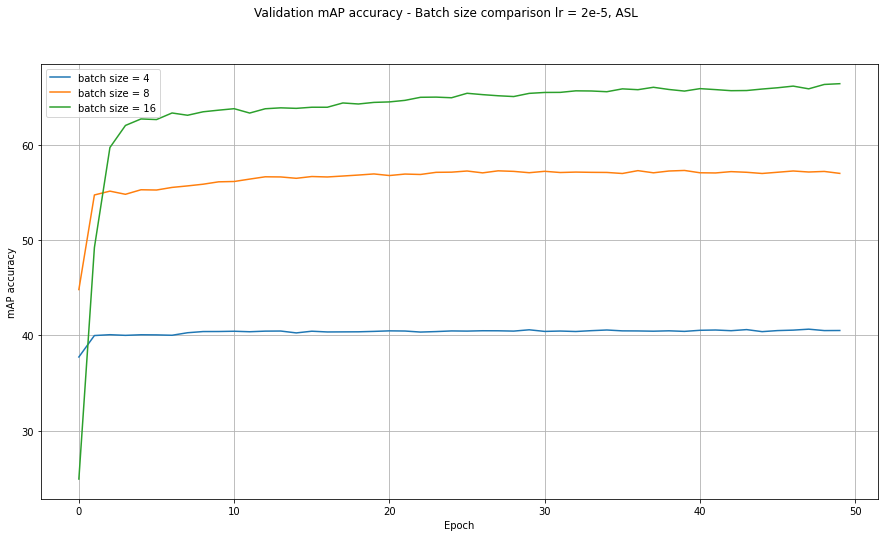

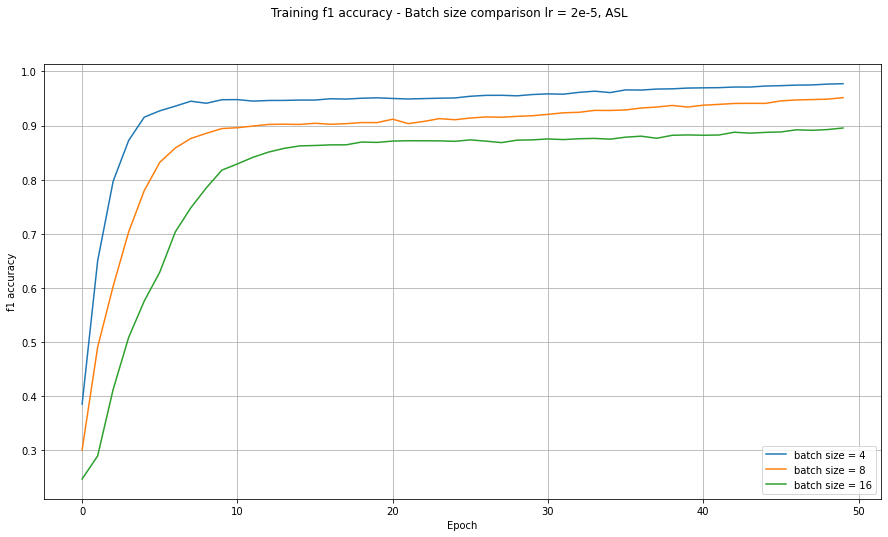

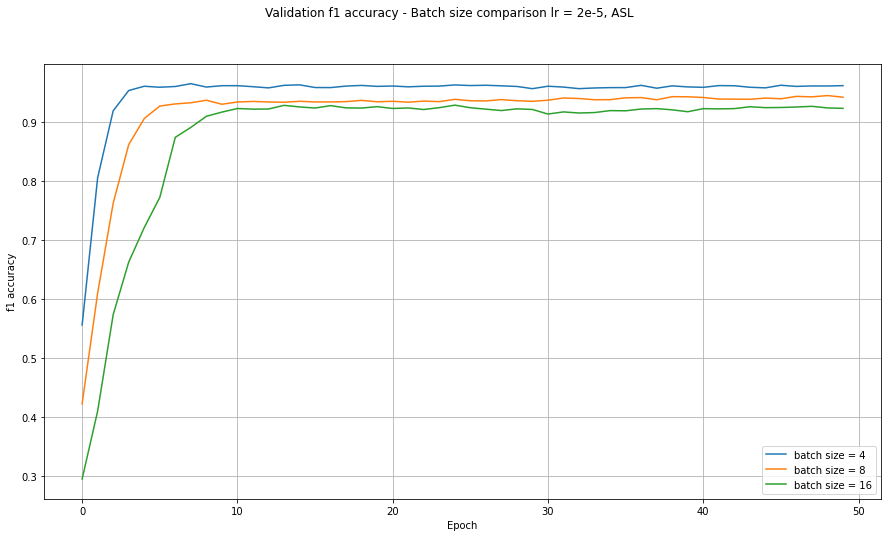

In [ ]:
## Add all combination of options as you'd like
combinations = [{'use_default_loss': 0, 'learning_rate': 2e-5, 'epochs': 50, 'batch_size': 8},
                {'use_default_loss': 0, 'learning_rate': 2e-5, 'epochs': 50, 'batch_size': 16},
                {'use_default_loss': 0, 'learning_rate': 2e-5, 'epochs': 50, 'batch_size': 32}]

labels = ['batch size = 4',
          'batch size = 8',
          'batch size = 16',
          'batch size = 32']
          
title = 'Batch size comparison lr = 2e-5, ASL'

combinations_results = []

for combination in combinations:

  use_default_loss = bool(combination['use_default_loss'])
  learning_rate = combination['learning_rate']
  epochs = combination['epochs']
  batch_size = combination['batch_size']

  results = train_and_plot_results(epochs, use_default_loss, learning_rate, batch_size, train_inputs, train_masks, train_labels,
                validation_inputs, validation_masks, validation_labels)
  combinations_results.append(results)

plot_results(combinations_results, labels, title)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a


Train loss: 85.29596739141469
Train Acc mAP: 16.659204396758525
Train Acc f1: 0.32288785866132846
Validation Acc mAP: 18.006388472492638
Validation Acc f1: 0.33772592281942465


Epoch:   2%|▏         | 1/50 [00:40<32:55, 40.31s/it]


Train loss: 85.47544249722246
Train Acc mAP: 17.554971672931536
Train Acc f1: 0.36104759315650214
Validation Acc mAP: 19.876407750739986
Validation Acc f1: 0.3721043550013796


Epoch:   4%|▍         | 2/50 [01:20<32:20, 40.43s/it]


Train loss: 85.75647395045576
Train Acc mAP: 19.728241483444435
Train Acc f1: 0.374450999864473
Validation Acc mAP: 24.01304800330409
Validation Acc f1: 0.38757302546077543


Epoch:   6%|▌         | 3/50 [02:01<31:41, 40.46s/it]


Train loss: 83.7810818287653
Train Acc mAP: 23.783728720240305
Train Acc f1: 0.4001083612109923
Validation Acc mAP: 30.388335721644808
Validation Acc f1: 0.43250424318627173


Epoch:   8%|▊         | 4/50 [02:42<31:11, 40.68s/it]


Train loss: 77.84827742562098
Train Acc mAP: 29.98781087369763
Train Acc f1: 0.44704390094274593
Validation Acc mAP: 34.49314206296204
Validation Acc f1: 0.49525626482961577


Epoch:  10%|█         | 5/50 [03:22<30:26, 40.59s/it]


Train loss: 69.98107680292453
Train Acc mAP: 34.804811522279536
Train Acc f1: 0.5048548106546012
Validation Acc mAP: 37.39892920980148
Validation Acc f1: 0.5522243207507421


Epoch:  12%|█▏        | 6/50 [04:03<29:53, 40.76s/it]


Train loss: 63.4805507467676
Train Acc mAP: 36.98065358747499
Train Acc f1: 0.5453239437597758
Validation Acc mAP: 38.534425383068246
Validation Acc f1: 0.5974898953627927


Epoch:  14%|█▍        | 7/50 [04:44<29:16, 40.85s/it]


Train loss: 58.7770880503058
Train Acc mAP: 38.85463495675872
Train Acc f1: 0.5743344298107064
Validation Acc mAP: 38.87192503048689
Validation Acc f1: 0.6321039685596467


Epoch:  16%|█▌        | 8/50 [05:25<28:30, 40.73s/it]


Train loss: 54.62131188800629
Train Acc mAP: 39.11357918418158
Train Acc f1: 0.6067466110890728
Validation Acc mAP: 39.17489178079401
Validation Acc f1: 0.641701823164152


Epoch:  18%|█▊        | 9/50 [06:05<27:47, 40.66s/it]


Train loss: 51.34262888640625
Train Acc mAP: 38.610445173431394
Train Acc f1: 0.624359200661356
Validation Acc mAP: 39.637800369089184
Validation Acc f1: 0.675925999069906


Epoch:  20%|██        | 10/50 [06:47<27:12, 40.81s/it]


Train loss: 48.87498842590238
Train Acc mAP: 39.68820931992205
Train Acc f1: 0.6454029706218509
Validation Acc mAP: 39.82374673635772
Validation Acc f1: 0.6919348486772259


Epoch:  22%|██▏       | 11/50 [07:27<26:27, 40.70s/it]


Train loss: 46.57707086867135
Train Acc mAP: 40.64657494612709
Train Acc f1: 0.6565561189448705
Validation Acc mAP: 39.93629322206922
Validation Acc f1: 0.7173566734042971


Epoch:  24%|██▍       | 12/50 [08:07<25:43, 40.62s/it]


Train loss: 44.82469531260667
Train Acc mAP: 40.68515000844147
Train Acc f1: 0.6744052155462165
Validation Acc mAP: 39.877573316534864
Validation Acc f1: 0.7398265083400184


Epoch:  26%|██▌       | 13/50 [08:46<24:41, 40.04s/it]


Train loss: 43.06063139050685
Train Acc mAP: 41.22982945904763
Train Acc f1: 0.6868276572629399
Validation Acc mAP: 39.97543982583219
Validation Acc f1: 0.752605643908592


Epoch:  28%|██▊       | 14/50 [09:27<24:09, 40.26s/it]


Train loss: 41.48069043809604
Train Acc mAP: 41.50706573097321
Train Acc f1: 0.7032400968616591
Validation Acc mAP: 40.00969310404764
Validation Acc f1: 0.7740603049014955


Epoch:  30%|███       | 15/50 [10:07<23:31, 40.32s/it]


Train loss: 40.32197754126851
Train Acc mAP: 40.67875422015599
Train Acc f1: 0.7211900647472564
Validation Acc mAP: 40.03415973129857
Validation Acc f1: 0.7874574823698541


Epoch:  32%|███▏      | 16/50 [10:48<22:59, 40.56s/it]


Train loss: 39.00048650271793
Train Acc mAP: 41.4956200224228
Train Acc f1: 0.7318632550989003
Validation Acc mAP: 40.00121133996356
Validation Acc f1: 0.813507621127587


Epoch:  34%|███▍      | 17/50 [11:27<22:00, 40.01s/it]


Train loss: 37.87491904041431
Train Acc mAP: 40.909141153034575
Train Acc f1: 0.7524222628729688
Validation Acc mAP: 40.07624233036721
Validation Acc f1: 0.8326985317593683


Epoch:  36%|███▌      | 18/50 [12:08<21:27, 40.23s/it]


Train loss: 36.88704721271711
Train Acc mAP: 40.69564625045707
Train Acc f1: 0.7615989750985097
Validation Acc mAP: 40.06971789628574
Validation Acc f1: 0.8484832034312361


Epoch:  38%|███▊      | 19/50 [12:47<20:33, 39.78s/it]


Train loss: 36.10051519382362
Train Acc mAP: 40.69031432006574
Train Acc f1: 0.7709284833865617
Validation Acc mAP: 40.12272892212114
Validation Acc f1: 0.868337629549882


Epoch:  40%|████      | 20/50 [13:27<19:58, 39.96s/it]


Train loss: 35.16410451095985
Train Acc mAP: 41.178653648682705
Train Acc f1: 0.7902150124453515
Validation Acc mAP: 40.17410883941986
Validation Acc f1: 0.8880948015672245


Epoch:  42%|████▏     | 21/50 [14:08<19:29, 40.33s/it]


Train loss: 34.59825198259549
Train Acc mAP: 41.06261673627218
Train Acc f1: 0.8024476810420681
Validation Acc mAP: 40.17410883956666
Validation Acc f1: 0.895731607384562


Epoch:  44%|████▍     | 22/50 [14:49<18:56, 40.58s/it]


Train loss: 33.96000034930118
Train Acc mAP: 41.610995222021586
Train Acc f1: 0.8119943075674678
Validation Acc mAP: 40.18389549052575
Validation Acc f1: 0.9063866319905005


Epoch:  46%|████▌     | 23/50 [15:30<18:14, 40.54s/it]


Train loss: 33.57297154079467
Train Acc mAP: 41.446691335014016
Train Acc f1: 0.8232025406674662
Validation Acc mAP: 40.1406711155842
Validation Acc f1: 0.9166159100218992


Epoch:  48%|████▊     | 24/50 [16:09<17:20, 40.00s/it]


Train loss: 32.94179892182115
Train Acc mAP: 41.822444206032976
Train Acc f1: 0.8372470895335772
Validation Acc mAP: 40.12354447651181
Validation Acc f1: 0.9217747879476997


Epoch:  50%|█████     | 25/50 [16:47<16:28, 39.56s/it]


Train loss: 32.599311112700775
Train Acc mAP: 42.73067995566751
Train Acc f1: 0.8416915995304449
Validation Acc mAP: 40.101524511992494
Validation Acc f1: 0.9313171071366992


Epoch:  52%|█████▏    | 26/50 [17:26<15:42, 39.27s/it]


Train loss: 32.180932880331
Train Acc mAP: 42.8462759660178
Train Acc f1: 0.8531508953990236
Validation Acc mAP: 40.22385764844288
Validation Acc f1: 0.9358647684696719


Epoch:  54%|█████▍    | 27/50 [18:06<15:12, 39.69s/it]


Train loss: 31.761141257555764
Train Acc mAP: 41.10124675227822
Train Acc f1: 0.8593163540151912
Validation Acc mAP: 40.17492439379422
Validation Acc f1: 0.9403837880492618


Epoch:  56%|█████▌    | 28/50 [18:45<14:27, 39.44s/it]


Train loss: 31.355010830318864
Train Acc mAP: 40.54169748440665
Train Acc f1: 0.8680553021963399
Validation Acc mAP: 40.14719554954605
Validation Acc f1: 0.9443200634731862


Epoch:  58%|█████▊    | 29/50 [19:24<13:42, 39.17s/it]


Train loss: 31.25093525196972
Train Acc mAP: 41.9080987661231
Train Acc f1: 0.8714593793694848
Validation Acc mAP: 40.18144882775607
Validation Acc f1: 0.9464780848682047


Epoch:  60%|██████    | 30/50 [20:02<12:59, 38.96s/it]


Train loss: 30.734900703789176
Train Acc mAP: 41.71336580393344
Train Acc f1: 0.8796195905244603
Validation Acc mAP: 40.24016873321703
Validation Acc f1: 0.9500017801305126


Epoch:  62%|██████▏   | 31/50 [20:43<12:29, 39.47s/it]


Train loss: 30.51902925868727
Train Acc mAP: 41.54459041649314
Train Acc f1: 0.8876532924624484
Validation Acc mAP: 40.220595431445645
Validation Acc f1: 0.9500863363973966


Epoch:  64%|██████▍   | 32/50 [21:22<11:47, 39.30s/it]


Train loss: 30.29730104158888
Train Acc mAP: 41.933894158397905
Train Acc f1: 0.8906834525283757
Validation Acc mAP: 40.240168733314896
Validation Acc f1: 0.9546203818873086


Epoch:  66%|██████▌   | 33/50 [22:03<11:16, 39.77s/it]


Train loss: 29.85779535422659
Train Acc mAP: 40.61882049437537
Train Acc f1: 0.8993533378406988


Epoch:  68%|██████▊   | 34/50 [22:40<10:23, 38.98s/it]

Validation Acc mAP: 40.23364429940197
Validation Acc f1: 0.9530202755980558

Train loss: 29.63731826044637
Train Acc mAP: 41.81737912202819
Train Acc f1: 0.8959199439755079
Validation Acc mAP: 40.351084110323875
Validation Acc f1: 0.9558662932093258


Epoch:  70%|███████   | 35/50 [23:20<09:49, 39.30s/it]


Train loss: 29.341113470465864
Train Acc mAP: 41.016529907697674
Train Acc f1: 0.9016480829503702
Validation Acc mAP: 40.27279090294474
Validation Acc f1: 0.9581093347106366


Epoch:  72%|███████▏  | 36/50 [23:59<09:07, 39.12s/it]


Train loss: 29.181914947355825
Train Acc mAP: 42.09461474302393
Train Acc f1: 0.9030677973286382
Validation Acc mAP: 40.29888863877584
Validation Acc f1: 0.9585376871360183


Epoch:  74%|███████▍  | 37/50 [24:37<08:26, 38.93s/it]


Train loss: 28.984057331806472
Train Acc mAP: 41.40464988588678
Train Acc f1: 0.9062395598218292


Epoch:  76%|███████▌  | 38/50 [25:14<07:39, 38.30s/it]

Validation Acc mAP: 40.27279090294474
Validation Acc f1: 0.9583967548071602

Train loss: 28.58864764088393
Train Acc mAP: 41.212717154633616
Train Acc f1: 0.9107985992961534
Validation Acc mAP: 40.29236420486292
Validation Acc f1: 0.9608091624844168


Epoch:  78%|███████▊  | 39/50 [25:52<07:01, 38.30s/it]


Train loss: 28.225626897322545
Train Acc mAP: 40.84045058294679
Train Acc f1: 0.9126206627335068
Validation Acc mAP: 40.29236420481399
Validation Acc f1: 0.9609824126576669


Epoch:  80%|████████  | 40/50 [26:31<06:23, 38.33s/it]


Train loss: 28.167441545904545
Train Acc mAP: 41.323893981840364
Train Acc f1: 0.9155456632625446


Epoch:  82%|████████▏ | 41/50 [27:07<05:40, 37.89s/it]

Validation Acc mAP: 40.28910198781675
Validation Acc f1: 0.9609002733172584

Train loss: 27.82469470980439
Train Acc mAP: 42.749528482956094
Train Acc f1: 0.9182278693429066


Epoch:  84%|████████▍ | 42/50 [27:44<05:00, 37.51s/it]

Validation Acc mAP: 40.26300425208352
Validation Acc f1: 0.9593966780474392

Train loss: 27.851486631699984
Train Acc mAP: 41.52148955792304
Train Acc f1: 0.917039743415381


Epoch:  86%|████████▌ | 43/50 [28:21<04:20, 37.23s/it]

Validation Acc mAP: 40.292364204813985
Validation Acc f1: 0.9596070606500704

Train loss: 27.302256050841965
Train Acc mAP: 42.21032292543823
Train Acc f1: 0.9224589084602332
Validation Acc mAP: 40.33151080850356
Validation Acc f1: 0.961020132850138


Epoch:  88%|████████▊ | 44/50 [28:59<03:45, 37.52s/it]


Train loss: 27.22434950296632
Train Acc mAP: 41.39729884758451
Train Acc f1: 0.9219150901871321


Epoch:  90%|█████████ | 45/50 [29:36<03:06, 37.32s/it]

Validation Acc mAP: 40.22385764844288
Validation Acc f1: 0.9609466393817693

Train loss: 26.94429697295054
Train Acc mAP: 41.46870264142688
Train Acc f1: 0.922323851215344
Validation Acc mAP: 40.331510808552494
Validation Acc f1: 0.9614512736575105


Epoch:  92%|█████████▏| 46/50 [30:14<02:30, 37.60s/it]


Train loss: 26.768406026040388
Train Acc mAP: 41.56723934697709
Train Acc f1: 0.9250046341049021


Epoch:  94%|█████████▍| 47/50 [30:51<01:52, 37.38s/it]

Validation Acc mAP: 40.29236420486292
Validation Acc f1: 0.960513349431915

Train loss: 26.500667202712723
Train Acc mAP: 41.77669997427858
Train Acc f1: 0.9244580346610904


Epoch:  96%|█████████▌| 48/50 [31:27<01:14, 37.15s/it]

Validation Acc mAP: 40.23364429935304
Validation Acc f1: 0.9614164357419767

Train loss: 26.375145694328296
Train Acc mAP: 41.27845350868674
Train Acc f1: 0.9222608417684809


Epoch:  98%|█████████▊| 49/50 [32:04<00:36, 36.99s/it]

Validation Acc mAP: 40.30215085577308
Validation Acc f1: 0.9600056058710573

Train loss: 26.204912956141115
Train Acc mAP: 41.21833718828625
Train Acc f1: 0.9261003842250897
Validation Acc mAP: 40.370657412193125
Validation Acc f1: 0.9622071144400803


Epoch: 100%|██████████| 50/50 [32:45<00:00, 39.31s/it]
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a 


Train loss: 167.61667581277788
Train Acc mAP: 16.85759728778283
Train Acc f1: 0.26212636946852225
Validation Acc mAP: 18.07746254076759
Validation Acc f1: 0.284988896464114


Epoch:   2%|▏         | 1/50 [00:39<32:03, 39.26s/it]


Train loss: 166.5839135452379
Train Acc mAP: 17.560751417016398
Train Acc f1: 0.2842004786349474
Validation Acc mAP: 20.12118538968096
Validation Acc f1: 0.30583871563131443


Epoch:   4%|▍         | 2/50 [01:18<31:21, 39.21s/it]


Train loss: 168.38952752928347
Train Acc mAP: 18.790375702883658
Train Acc f1: 0.2931945661068933
Validation Acc mAP: 23.325257553071623
Validation Acc f1: 0.30925361557917386


Epoch:   6%|▌         | 3/50 [01:57<30:33, 39.01s/it]


Train loss: 169.40979144699455
Train Acc mAP: 20.678509496195492
Train Acc f1: 0.3051962259326205
Validation Acc mAP: 27.959938146537173
Validation Acc f1: 0.31974837689624874


Epoch:   8%|▊         | 4/50 [02:35<29:42, 38.74s/it]


Train loss: 166.0479859325479
Train Acc mAP: 25.539366041217338
Train Acc f1: 0.30846566447746004
Validation Acc mAP: 32.87306386527893
Validation Acc f1: 0.34969636727081255


Epoch:  10%|█         | 5/50 [03:14<29:07, 38.82s/it]


Train loss: 158.85240951236648
Train Acc mAP: 31.390622669344793
Train Acc f1: 0.3457211664531503
Validation Acc mAP: 39.98805918646305
Validation Acc f1: 0.3965829368565664


Epoch:  12%|█▏        | 6/50 [03:53<28:30, 38.88s/it]


Train loss: 148.41561299996147
Train Acc mAP: 39.52342325002763
Train Acc f1: 0.3760403421365233
Validation Acc mAP: 45.458303997092116
Validation Acc f1: 0.44281166374824926


Epoch:  14%|█▍        | 7/50 [04:32<27:53, 38.91s/it]


Train loss: 137.41960306387628
Train Acc mAP: 44.126661248810976
Train Acc f1: 0.4096060407562694
Validation Acc mAP: 49.46442244723462
Validation Acc f1: 0.46938232886193276


Epoch:  16%|█▌        | 8/50 [05:10<27:08, 38.77s/it]


Train loss: 128.98577879409476
Train Acc mAP: 48.73612117480491
Train Acc f1: 0.4308057759037071
Validation Acc mAP: 51.34878523665674
Validation Acc f1: 0.49684804215641665


Epoch:  18%|█▊        | 9/50 [05:49<26:28, 38.76s/it]


Train loss: 121.54264271811968
Train Acc mAP: 52.42538857614433
Train Acc f1: 0.45332157411697066
Validation Acc mAP: 52.43740418905876
Validation Acc f1: 0.5277758864076827


Epoch:  20%|██        | 10/50 [06:28<25:49, 38.73s/it]


Train loss: 115.96430360213502
Train Acc mAP: 53.69939068299516
Train Acc f1: 0.4706633114288295
Validation Acc mAP: 52.66966405178757
Validation Acc f1: 0.5474149507868468


Epoch:  22%|██▏       | 11/50 [07:06<25:07, 38.65s/it]


Train loss: 110.75297910704398
Train Acc mAP: 54.40450035568881
Train Acc f1: 0.49074105002278423
Validation Acc mAP: 53.010925236318016
Validation Acc f1: 0.5660965356839737


Epoch:  24%|██▍       | 12/50 [07:46<24:35, 38.84s/it]


Train loss: 106.89283829660299
Train Acc mAP: 56.2745129464316
Train Acc f1: 0.4982190341035007
Validation Acc mAP: 53.29718477564235
Validation Acc f1: 0.5943517633732461


Epoch:  26%|██▌       | 13/50 [08:24<23:55, 38.79s/it]


Train loss: 102.5061127305997
Train Acc mAP: 54.60810824154798
Train Acc f1: 0.5254398021966555
Validation Acc mAP: 53.61748152513079
Validation Acc f1: 0.6069290777620251


Epoch:  28%|██▊       | 14/50 [09:03<23:11, 38.65s/it]


Train loss: 99.20719019995111
Train Acc mAP: 56.05026785743748
Train Acc f1: 0.5371527009931106
Validation Acc mAP: 53.974321458443946
Validation Acc f1: 0.6175730344743233


Epoch:  30%|███       | 15/50 [09:41<22:30, 38.59s/it]


Train loss: 96.2218589786567
Train Acc mAP: 58.05657737658923
Train Acc f1: 0.5337310980942869
Validation Acc mAP: 54.414354280179076
Validation Acc f1: 0.634527739249166


Epoch:  32%|███▏      | 16/50 [10:20<21:57, 38.76s/it]


Train loss: 93.61650214470218
Train Acc mAP: 57.39189329776031
Train Acc f1: 0.5575863604053903
Validation Acc mAP: 54.69524387216016
Validation Acc f1: 0.6468647602608802


Epoch:  34%|███▍      | 17/50 [10:59<21:15, 38.65s/it]


Train loss: 91.71806287724809
Train Acc mAP: 56.86502426585308
Train Acc f1: 0.5691101995651909
Validation Acc mAP: 54.954873977093975
Validation Acc f1: 0.663059425058646


Epoch:  36%|███▌      | 18/50 [11:37<20:36, 38.64s/it]


Train loss: 89.51071881768462
Train Acc mAP: 56.90739085197025
Train Acc f1: 0.5839376368649649
Validation Acc mAP: 55.07086485565606
Validation Acc f1: 0.6786500841546952


Epoch:  38%|███▊      | 19/50 [12:16<20:00, 38.73s/it]


Train loss: 87.65394878243278
Train Acc mAP: 58.48936130718773
Train Acc f1: 0.5873793421872568
Validation Acc mAP: 54.8627587144203
Validation Acc f1: 0.6883040521489109


Epoch:  40%|████      | 20/50 [12:53<19:05, 38.17s/it]


Train loss: 85.13642826539605
Train Acc mAP: 58.16383918590172
Train Acc f1: 0.5973953926974229
Validation Acc mAP: 55.31039207771937
Validation Acc f1: 0.6999108120991748


Epoch:  42%|████▏     | 21/50 [13:31<18:27, 38.20s/it]


Train loss: 83.71085396006072
Train Acc mAP: 59.09922843014524
Train Acc f1: 0.6105740401430814
Validation Acc mAP: 55.30281907405278
Validation Acc f1: 0.7144527874195604


Epoch:  44%|████▍     | 22/50 [14:08<17:40, 37.87s/it]


Train loss: 81.91480931734743
Train Acc mAP: 58.58886659304737
Train Acc f1: 0.6247647809480456
Validation Acc mAP: 55.28767306663628
Validation Acc f1: 0.7200509904721067


Epoch:  46%|████▌     | 23/50 [14:45<16:52, 37.48s/it]


Train loss: 80.06668239901302
Train Acc mAP: 59.54486843201188
Train Acc f1: 0.6261619345880256
Validation Acc mAP: 55.26798325750753
Validation Acc f1: 0.7294542751343134


Epoch:  48%|████▊     | 24/50 [15:22<16:07, 37.20s/it]


Train loss: 78.11291756002917
Train Acc mAP: 58.59906636243208
Train Acc f1: 0.63876851668911
Validation Acc mAP: 55.292216869174
Validation Acc f1: 0.7376774533543365


Epoch:  50%|█████     | 25/50 [15:58<15:25, 37.00s/it]


Train loss: 76.9454884422014
Train Acc mAP: 59.30522297752097
Train Acc f1: 0.642166396580267
Validation Acc mAP: 55.596651617542015
Validation Acc f1: 0.7506668088753475


Epoch:  52%|█████▏    | 26/50 [16:37<14:58, 37.45s/it]


Train loss: 75.18568318641528
Train Acc mAP: 58.45726896319158
Train Acc f1: 0.6622336067912885
Validation Acc mAP: 55.65875024737484
Validation Acc f1: 0.7616621199593924


Epoch:  54%|█████▍    | 27/50 [17:15<14:31, 37.89s/it]


Train loss: 74.2843535523772
Train Acc mAP: 58.936220258453886
Train Acc f1: 0.6680499897531476
Validation Acc mAP: 55.534552987232075
Validation Acc f1: 0.7743502643937086


Epoch:  56%|█████▌    | 28/50 [17:52<13:45, 37.54s/it]


Train loss: 73.08907294282068
Train Acc mAP: 60.11638136557932
Train Acc f1: 0.6712588371371557
Validation Acc mAP: 55.52243618089903
Validation Acc f1: 0.782433737039585


Epoch:  58%|█████▊    | 29/50 [18:29<13:06, 37.44s/it]


Train loss: 71.72858458095392
Train Acc mAP: 58.85559117738357
Train Acc f1: 0.6890098540356608
Validation Acc mAP: 55.4951733681794
Validation Acc f1: 0.7981402373842913


Epoch:  60%|██████    | 30/50 [19:06<12:26, 37.34s/it]


Train loss: 71.26109845893876
Train Acc mAP: 60.84652693623289
Train Acc f1: 0.6924054265153203
Validation Acc mAP: 55.58604941217855
Validation Acc f1: 0.8134009162665011


Epoch:  62%|██████▏   | 31/50 [19:44<11:47, 37.25s/it]


Train loss: 70.00931797137352
Train Acc mAP: 59.43387458170883
Train Acc f1: 0.7064552345599306
Validation Acc mAP: 55.54061139032286
Validation Acc f1: 0.8187488161368381


Epoch:  64%|██████▍   | 32/50 [20:20<11:06, 37.05s/it]


Train loss: 69.30997149171459
Train Acc mAP: 59.92521348163622
Train Acc f1: 0.7121663382739677
Validation Acc mAP: 55.549698994406235
Validation Acc f1: 0.8306930572735373


Epoch:  66%|██████▌   | 33/50 [20:57<10:27, 36.90s/it]


Train loss: 68.5979742419672
Train Acc mAP: 59.53215837223206
Train Acc f1: 0.7202457970744549
Validation Acc mAP: 55.67389625523058
Validation Acc f1: 0.843240801664691


Epoch:  68%|██████▊   | 34/50 [21:35<09:59, 37.46s/it]


Train loss: 67.3498723700452
Train Acc mAP: 59.41819815829177
Train Acc f1: 0.7285849969694739
Validation Acc mAP: 55.537582188679025
Validation Acc f1: 0.849896069341946


Epoch:  70%|███████   | 35/50 [22:13<09:20, 37.37s/it]


Train loss: 67.02220929215541
Train Acc mAP: 59.74714216984412
Train Acc f1: 0.7379661081300073
Validation Acc mAP: 55.51031937548988
Validation Acc f1: 0.8622124207946417


Epoch:  72%|███████▏  | 36/50 [22:49<08:39, 37.14s/it]


Train loss: 66.07615532480021
Train Acc mAP: 60.49428970612591
Train Acc f1: 0.7521217241124916
Validation Acc mAP: 55.561815800648404
Validation Acc f1: 0.8646285764656444


Epoch:  74%|███████▍  | 37/50 [23:26<08:00, 36.97s/it]


Train loss: 65.92485123579965
Train Acc mAP: 58.88670879667061
Train Acc f1: 0.7550090316941988
Validation Acc mAP: 55.723878079192325
Validation Acc f1: 0.8739753762527718


Epoch:  76%|███████▌  | 38/50 [24:04<07:28, 37.37s/it]


Train loss: 65.0245084872702
Train Acc mAP: 60.702512013581924
Train Acc f1: 0.76619167706921
Validation Acc mAP: 55.78294750806288
Validation Acc f1: 0.8793796009987025


Epoch:  78%|███████▊  | 39/50 [24:44<06:58, 38.02s/it]


Train loss: 64.24378520946594
Train Acc mAP: 58.60584940463161
Train Acc f1: 0.7749238591550944
Validation Acc mAP: 55.88745495881186
Validation Acc f1: 0.8878572302635416


Epoch:  80%|████████  | 40/50 [25:23<06:23, 38.36s/it]


Train loss: 64.05467752821019
Train Acc mAP: 59.90169005053415
Train Acc f1: 0.779472693362646
Validation Acc mAP: 55.8011227170172
Validation Acc f1: 0.8949169190020321


Epoch:  82%|████████▏ | 41/50 [26:00<05:41, 37.94s/it]


Train loss: 63.56532520075557
Train Acc mAP: 58.91161008380693
Train Acc f1: 0.7906268209078388
Validation Acc mAP: 55.89654256319814
Validation Acc f1: 0.896928931222907


Epoch:  84%|████████▍ | 42/50 [26:38<05:05, 38.17s/it]


Train loss: 62.95221608377403
Train Acc mAP: 58.86478447504444
Train Acc f1: 0.7909688381198572
Validation Acc mAP: 56.14190788256684
Validation Acc f1: 0.9012950129091567


Epoch:  86%|████████▌ | 43/50 [27:17<04:27, 38.24s/it]


Train loss: 62.87636837870262
Train Acc mAP: 59.84673954921562
Train Acc f1: 0.7980005185316857
Validation Acc mAP: 55.9010863657207
Validation Acc f1: 0.9105765817193132


Epoch:  88%|████████▊ | 44/50 [27:54<03:48, 38.00s/it]


Train loss: 61.96680289888184
Train Acc mAP: 60.74771802385873
Train Acc f1: 0.8087662744902681
Validation Acc mAP: 55.88896955975115
Validation Acc f1: 0.911033211879613


Epoch:  90%|█████████ | 45/50 [28:31<03:07, 37.55s/it]


Train loss: 61.67388103562116
Train Acc mAP: 59.9942128358884
Train Acc f1: 0.8105821125484853
Validation Acc mAP: 55.973787201144184
Validation Acc f1: 0.9121666450041285


Epoch:  92%|█████████▏| 46/50 [29:08<02:29, 37.31s/it]


Train loss: 61.361401535485285
Train Acc mAP: 60.03568875191808
Train Acc f1: 0.8215179244271468
Validation Acc mAP: 56.04042963343143
Validation Acc f1: 0.919029608148726


Epoch:  94%|█████████▍| 47/50 [29:44<01:51, 37.06s/it]


Train loss: 61.01671230182606
Train Acc mAP: 60.15766314807273
Train Acc f1: 0.8211949085305488


Epoch:  96%|█████████▌| 48/50 [30:19<01:12, 36.42s/it]

Validation Acc mAP: 56.091926058347624
Validation Acc f1: 0.9190125399416321

Train loss: 60.43916931045192
Train Acc mAP: 59.22559116562247
Train Acc f1: 0.8267604354021674
Validation Acc mAP: 56.055575640863076
Validation Acc f1: 0.9228847382982776


Epoch:  98%|█████████▊| 49/50 [30:55<00:36, 36.41s/it]


Train loss: 60.057111036749625
Train Acc mAP: 60.890410502587635
Train Acc f1: 0.829822639923041
Validation Acc mAP: 56.01468142073478
Validation Acc f1: 0.9240559871755973


Epoch: 100%|██████████| 50/50 [31:32<00:00, 37.85s/it]
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a 


Train loss: 339.703955021055
Train Acc mAP: 15.647813584504377
Train Acc f1: 0.22483541146614416
Validation Acc mAP: 15.448361797763368
Validation Acc f1: 0.2736772877926173


Epoch:   2%|▏         | 1/50 [00:37<30:30, 37.37s/it]


Train loss: 328.6889616342321
Train Acc mAP: 15.747729445198026
Train Acc f1: 0.2501124332312492
Validation Acc mAP: 16.327050975501717
Validation Acc f1: 0.28835644865958776


Epoch:   4%|▍         | 2/50 [01:15<30:10, 37.72s/it]


Train loss: 333.46680340730416
Train Acc mAP: 16.236007824588704
Train Acc f1: 0.25907426242615195
Validation Acc mAP: 17.604764745058965
Validation Acc f1: 0.2967073215945802


Epoch:   6%|▌         | 3/50 [01:52<29:24, 37.53s/it]


Train loss: 335.5036659105898
Train Acc mAP: 17.001967678838295
Train Acc f1: 0.25650373194677883
Validation Acc mAP: 19.79214010180713
Validation Acc f1: 0.3029241007379647


Epoch:   8%|▊         | 4/50 [02:29<28:39, 37.39s/it]


Train loss: 336.9459499477846
Train Acc mAP: 18.12312482522877
Train Acc f1: 0.25141290071583644
Validation Acc mAP: 21.550515301319972
Validation Acc f1: 0.30505694897108304


Epoch:  10%|█         | 5/50 [03:06<27:58, 37.31s/it]


Train loss: 336.6103489178294
Train Acc mAP: 19.18748393451551
Train Acc f1: 0.2624182323517587
Validation Acc mAP: 24.82410829913884
Validation Acc f1: 0.313662706974869


Epoch:  12%|█▏        | 6/50 [03:44<27:29, 37.49s/it]


Train loss: 336.09522059163095
Train Acc mAP: 21.93481648658107
Train Acc f1: 0.2672249726717287
Validation Acc mAP: 28.90597791957979
Validation Acc f1: 0.32227778982732436


Epoch:  14%|█▍        | 7/50 [04:22<26:53, 37.53s/it]


Train loss: 327.5218966990102
Train Acc mAP: 25.736197539825653
Train Acc f1: 0.2843681190786598
Validation Acc mAP: 33.26698621852578
Validation Acc f1: 0.36070163359673424


Epoch:  16%|█▌        | 8/50 [04:59<26:12, 37.45s/it]


Train loss: 318.4937417678458
Train Acc mAP: 31.758161971825725
Train Acc f1: 0.2976366106319812
Validation Acc mAP: 39.62040718540503
Validation Acc f1: 0.3865517412349353


Epoch:  18%|█▊        | 9/50 [05:37<25:33, 37.40s/it]


Train loss: 303.9415311777021
Train Acc mAP: 38.00079193786226
Train Acc f1: 0.31458065202158175
Validation Acc mAP: 45.407040453298116
Validation Acc f1: 0.41723503413795515


Epoch:  20%|██        | 10/50 [06:14<24:56, 37.40s/it]


Train loss: 288.0081718371354
Train Acc mAP: 44.6500427648615
Train Acc f1: 0.34070779187148753
Validation Acc mAP: 48.657248342540214
Validation Acc f1: 0.43357412189946226


Epoch:  22%|██▏       | 11/50 [06:52<24:21, 37.48s/it]


Train loss: 275.60818884906956
Train Acc mAP: 48.05417148099431
Train Acc f1: 0.35879292410881525
Validation Acc mAP: 51.79036626165558
Validation Acc f1: 0.45245752925487537


Epoch:  24%|██▍       | 12/50 [07:29<23:46, 37.54s/it]


Train loss: 262.38207662724443
Train Acc mAP: 52.54579215984248
Train Acc f1: 0.3777834893868872
Validation Acc mAP: 54.02097344901678
Validation Acc f1: 0.4760655563491505


Epoch:  26%|██▌       | 13/50 [08:07<23:06, 37.47s/it]


Train loss: 251.0507541484328
Train Acc mAP: 55.569407204126364
Train Acc f1: 0.3983989948978627
Validation Acc mAP: 55.75687092952602
Validation Acc f1: 0.493225509819361


Epoch:  28%|██▊       | 14/50 [08:44<22:33, 37.59s/it]


Train loss: 239.6415588148344
Train Acc mAP: 60.016766871596516
Train Acc f1: 0.4032831632470246
Validation Acc mAP: 57.32656134363675
Validation Acc f1: 0.5077766158623738


Epoch:  30%|███       | 15/50 [09:22<21:53, 37.53s/it]


Train loss: 231.5412671921816
Train Acc mAP: 61.14471188125868
Train Acc f1: 0.42449552693786957
Validation Acc mAP: 58.0753780971541
Validation Acc f1: 0.5208641676364426


Epoch:  32%|███▏      | 16/50 [09:59<21:12, 37.43s/it]


Train loss: 223.30141025246868
Train Acc mAP: 64.36550431479442
Train Acc f1: 0.4232863225598002
Validation Acc mAP: 59.0033690383317
Validation Acc f1: 0.5299862071034951


Epoch:  34%|███▍      | 17/50 [10:37<20:36, 37.48s/it]


Train loss: 216.01525849693436
Train Acc mAP: 64.47030487606533
Train Acc f1: 0.44131355246753695
Validation Acc mAP: 59.283510970052106
Validation Acc f1: 0.5422626235585127


Epoch:  36%|███▌      | 18/50 [11:14<20:02, 37.57s/it]


Train loss: 209.5572534354126
Train Acc mAP: 65.64879541139734
Train Acc f1: 0.4459498848111849
Validation Acc mAP: 59.525354472601606
Validation Acc f1: 0.5559206179052012


Epoch:  38%|███▊      | 19/50 [11:52<19:27, 37.67s/it]


Train loss: 202.74356616901744
Train Acc mAP: 66.7985561339968
Train Acc f1: 0.4591797066338068
Validation Acc mAP: 59.97372861423101
Validation Acc f1: 0.5596582696577436


Epoch:  40%|████      | 20/50 [12:30<18:52, 37.73s/it]


Train loss: 197.84803861544705
Train Acc mAP: 67.41235800433893
Train Acc f1: 0.4641219798376325
Validation Acc mAP: 59.769477820844415
Validation Acc f1: 0.5705053694581697


Epoch:  42%|████▏     | 21/50 [13:06<17:55, 37.10s/it]


Train loss: 193.10095329395597
Train Acc mAP: 68.01129894042391
Train Acc f1: 0.472586421564383
Validation Acc mAP: 60.254402491039265
Validation Acc f1: 0.5757534358384173


Epoch:  44%|████▍     | 22/50 [13:43<17:19, 37.12s/it]


Train loss: 187.4077989821606
Train Acc mAP: 68.61695117660635
Train Acc f1: 0.48081537334545377
Validation Acc mAP: 60.23273612775
Validation Acc f1: 0.5818721031534884


Epoch:  46%|████▌     | 23/50 [14:19<16:29, 36.65s/it]


Train loss: 182.7029060131395
Train Acc mAP: 69.86095382117718
Train Acc f1: 0.4931378834058055
Validation Acc mAP: 61.130614165199304
Validation Acc f1: 0.5932356071551432


Epoch:  48%|████▊     | 24/50 [14:56<16:01, 36.98s/it]


Train loss: 179.14460910050053
Train Acc mAP: 68.8865830686636
Train Acc f1: 0.499254009756867
Validation Acc mAP: 60.67131149211421
Validation Acc f1: 0.5967566415221901


Epoch:  50%|█████     | 25/50 [15:32<15:14, 36.58s/it]


Train loss: 174.78978249964356
Train Acc mAP: 70.66606974319214
Train Acc f1: 0.5057020736319935
Validation Acc mAP: 61.02762131529603
Validation Acc f1: 0.6032590871648478


Epoch:  52%|█████▏    | 26/50 [16:08<14:35, 36.50s/it]


Train loss: 172.60491076410452
Train Acc mAP: 71.34106783447427
Train Acc f1: 0.510755897777006
Validation Acc mAP: 61.239498812835706
Validation Acc f1: 0.6229864891720462


Epoch:  54%|█████▍    | 27/50 [16:46<14:09, 36.94s/it]


Train loss: 169.60755359356378
Train Acc mAP: 69.23312846993478
Train Acc f1: 0.5263661914622412
Validation Acc mAP: 61.22451941112182
Validation Acc f1: 0.6246682217496775


Epoch:  56%|█████▌    | 28/50 [17:22<13:23, 36.52s/it]


Train loss: 165.3984672948615
Train Acc mAP: 71.47558477279921
Train Acc f1: 0.5293046099424696
Validation Acc mAP: 61.67458302122094
Validation Acc f1: 0.6333438860893574


Epoch:  58%|█████▊    | 29/50 [17:59<12:50, 36.71s/it]


Train loss: 163.93792771328938
Train Acc mAP: 70.16694514012134
Train Acc f1: 0.5362070943548443
Validation Acc mAP: 61.36521067552121
Validation Acc f1: 0.640514895773492


Epoch:  60%|██████    | 30/50 [18:34<12:07, 36.35s/it]


Train loss: 160.33157437548113
Train Acc mAP: 71.02309799104135
Train Acc f1: 0.5453344891036731
Validation Acc mAP: 61.71697669659511
Validation Acc f1: 0.6583287616308914


Epoch:  62%|██████▏   | 31/50 [19:12<11:38, 36.74s/it]


Train loss: 158.10009534306482
Train Acc mAP: 72.03141300733833
Train Acc f1: 0.5508662845616777
Validation Acc mAP: 61.547568603732216
Validation Acc f1: 0.6661414151141681


Epoch:  64%|██████▍   | 32/50 [19:48<10:54, 36.38s/it]


Train loss: 154.92206636901412
Train Acc mAP: 71.43646788475841
Train Acc f1: 0.5623248758026529
Validation Acc mAP: 61.613618303114734
Validation Acc f1: 0.6756335102133721


Epoch:  66%|██████▌   | 33/50 [20:23<10:13, 36.10s/it]


Train loss: 153.70656883435987
Train Acc mAP: 70.6157138536742
Train Acc f1: 0.5686792822515511
Validation Acc mAP: 61.80135306541929
Validation Acc f1: 0.6910363139642112


Epoch:  68%|██████▊   | 34/50 [21:01<09:45, 36.57s/it]


Train loss: 150.9282551309094
Train Acc mAP: 70.83647112192111
Train Acc f1: 0.5752132763322757
Validation Acc mAP: 61.79694179111266
Validation Acc f1: 0.6981399238036896


Epoch:  70%|███████   | 35/50 [21:36<09:04, 36.28s/it]


Train loss: 149.8288696009274
Train Acc mAP: 71.76453262881205
Train Acc f1: 0.5764222957646731
Validation Acc mAP: 61.63864363916085
Validation Acc f1: 0.7075130120686678


Epoch:  72%|███████▏  | 36/50 [22:12<08:24, 36.03s/it]


Train loss: 146.88194634247182
Train Acc mAP: 70.69759629404331
Train Acc f1: 0.5857511931704733
Validation Acc mAP: 62.03298571769547
Validation Acc f1: 0.7206021418702012


Epoch:  74%|███████▍  | 37/50 [22:50<07:55, 36.56s/it]


Train loss: 145.8658592798203
Train Acc mAP: 73.05070566042474
Train Acc f1: 0.5908576691873881
Validation Acc mAP: 61.621642245022855
Validation Acc f1: 0.739123487341256


Epoch:  76%|███████▌  | 38/50 [23:25<07:15, 36.30s/it]


Train loss: 144.65183143961985
Train Acc mAP: 71.48461182674185
Train Acc f1: 0.6036721177097298
Validation Acc mAP: 62.1279354068092
Validation Acc f1: 0.7489671629461948


Epoch:  78%|███████▊  | 39/50 [24:03<06:42, 36.59s/it]


Train loss: 143.2069125263898
Train Acc mAP: 72.0151579629611
Train Acc f1: 0.60624039124291
Validation Acc mAP: 62.013851548179744
Validation Acc f1: 0.7558575713832805


Epoch:  80%|████████  | 40/50 [24:39<06:04, 36.48s/it]


Train loss: 141.9720894715885
Train Acc mAP: 71.99994056400921
Train Acc f1: 0.6108245216991206
Validation Acc mAP: 62.168353158882894
Validation Acc f1: 0.7690389895725479


Epoch:  82%|████████▏ | 41/50 [25:17<05:32, 36.96s/it]


Train loss: 140.27805501094804
Train Acc mAP: 72.85102339518512
Train Acc f1: 0.6200468666913298
Validation Acc mAP: 62.176607732589986
Validation Acc f1: 0.7739267435556838


Epoch:  84%|████████▍ | 42/50 [25:55<04:57, 37.21s/it]


Train loss: 139.52499663055832
Train Acc mAP: 72.79465503514908
Train Acc f1: 0.6216044719520175
Validation Acc mAP: 61.923934464145546
Validation Acc f1: 0.7844608536873587


Epoch:  86%|████████▌ | 43/50 [26:30<04:16, 36.71s/it]


Train loss: 138.1130248081792
Train Acc mAP: 73.0544722675948
Train Acc f1: 0.631995958585353
Validation Acc mAP: 62.193003285686004
Validation Acc f1: 0.7978952835838711


Epoch:  88%|████████▊ | 44/50 [27:07<03:41, 36.87s/it]


Train loss: 136.92935120087313
Train Acc mAP: 71.49846238174813
Train Acc f1: 0.6443200141826094
Validation Acc mAP: 62.09947669006152
Validation Acc f1: 0.8077834620231593


Epoch:  90%|█████████ | 45/50 [27:43<03:03, 36.64s/it]


Train loss: 135.37942640695326
Train Acc mAP: 74.20566214425614
Train Acc f1: 0.6448028367188029
Validation Acc mAP: 62.45116698150207
Validation Acc f1: 0.8188951673019225


Epoch:  92%|█████████▏| 46/50 [28:21<02:27, 36.95s/it]


Train loss: 134.44235710477986
Train Acc mAP: 72.52326409172943
Train Acc f1: 0.6524716217301084
Validation Acc mAP: 62.417883630423205
Validation Acc f1: 0.8259790181416791


Epoch:  94%|█████████▍| 47/50 [28:57<01:49, 36.56s/it]


Train loss: 133.99295404251728
Train Acc mAP: 72.43673434798974
Train Acc f1: 0.6600361158256496
Validation Acc mAP: 62.11882571438355
Validation Acc f1: 0.8321458879581513


Epoch:  96%|█████████▌| 48/50 [29:32<01:12, 36.22s/it]


Train loss: 133.3472642530641
Train Acc mAP: 73.09858744579638
Train Acc f1: 0.6681634415010834
Validation Acc mAP: 62.05229687677833
Validation Acc f1: 0.8373805563934148


Epoch:  98%|█████████▊| 49/50 [30:08<00:36, 36.00s/it]


Train loss: 132.20341259129606
Train Acc mAP: 72.11328383961686
Train Acc f1: 0.6738736481740972
Validation Acc mAP: 62.38467600853515
Validation Acc f1: 0.8474146558166711


Epoch: 100%|██████████| 50/50 [30:43<00:00, 36.87s/it]


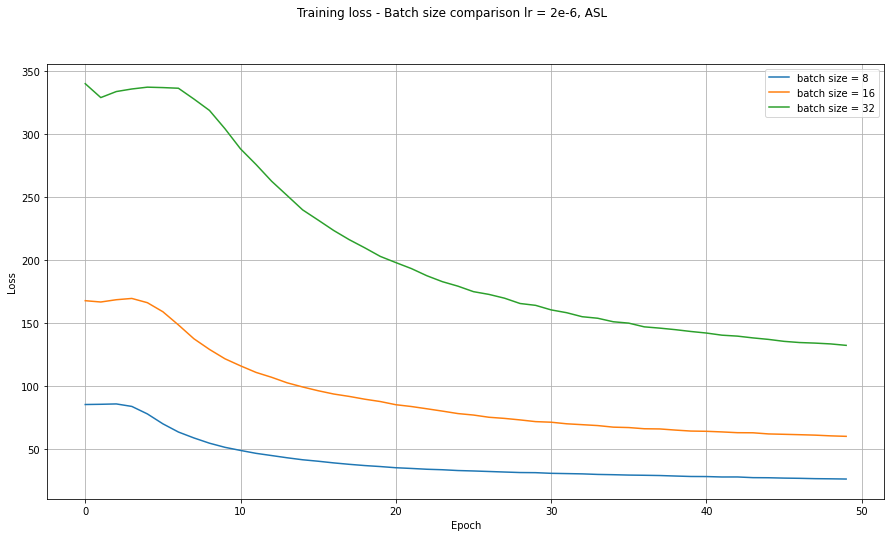

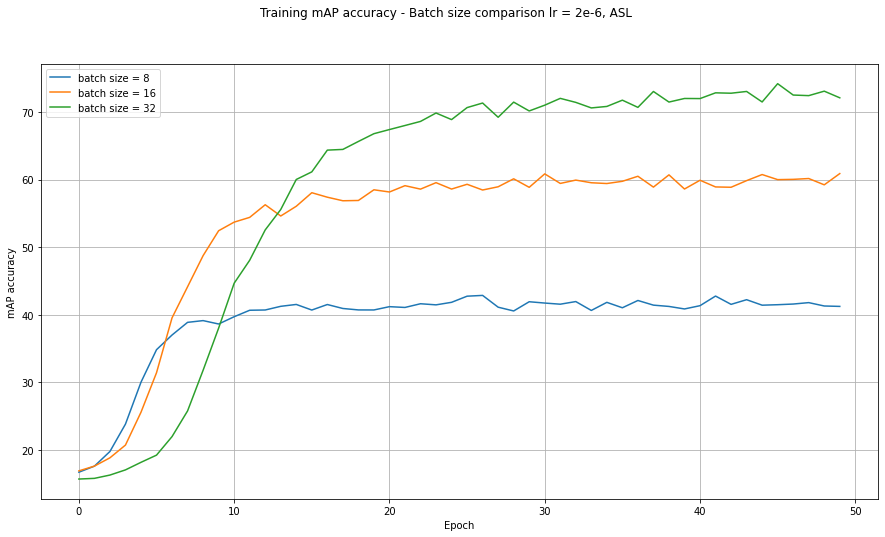

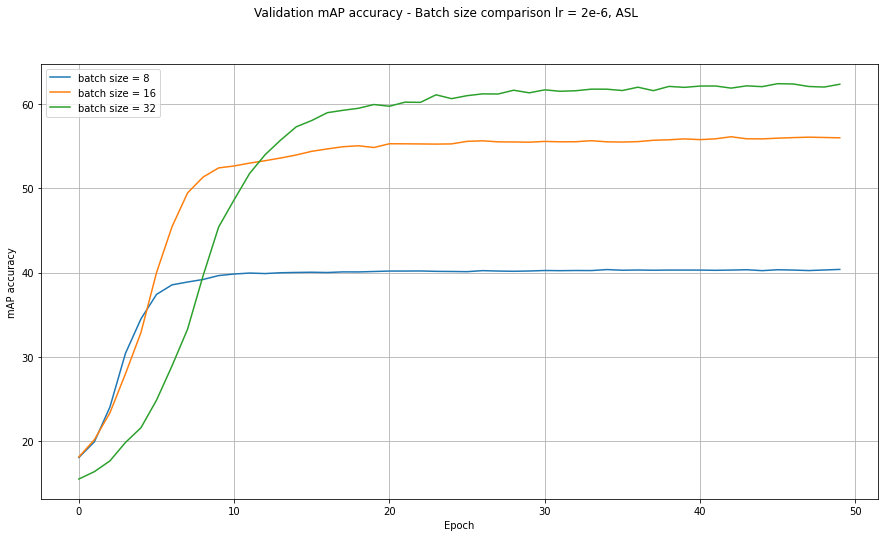

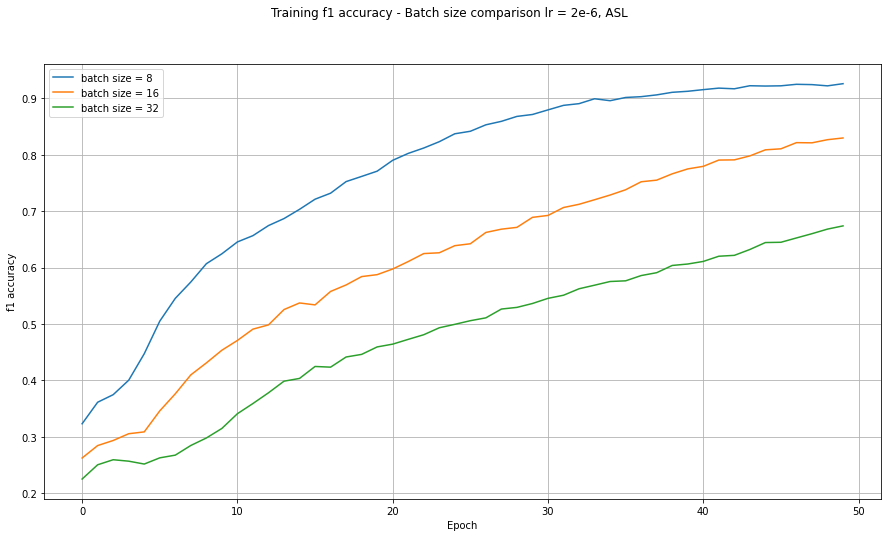

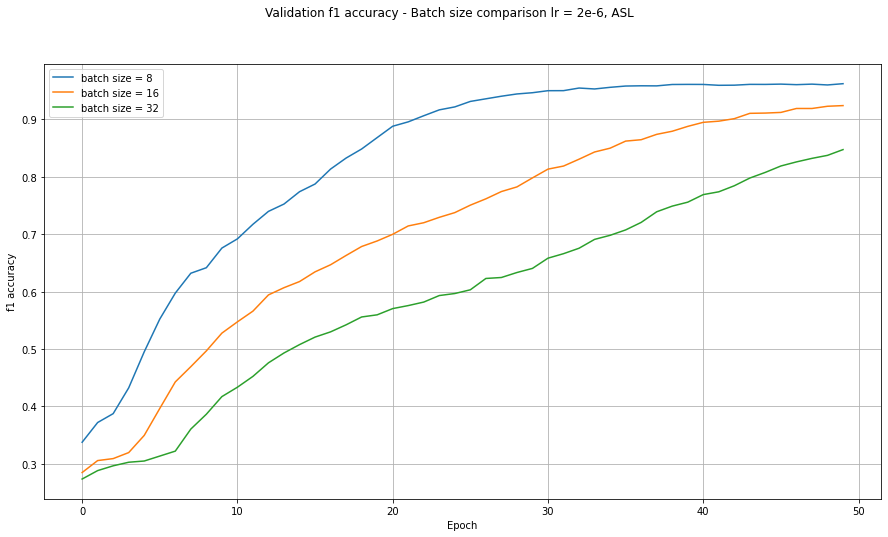

In [ ]:
## Add all combination of options as you'd like
combinations = [{'use_default_loss': 0, 'learning_rate': 2e-6, 'epochs': 50, 'batch_size': 8},
                {'use_default_loss': 0, 'learning_rate': 2e-6, 'epochs': 50, 'batch_size': 16},
                {'use_default_loss': 0, 'learning_rate': 2e-6, 'epochs': 50, 'batch_size': 32}]

labels = ['batch size = 8',
          'batch size = 16',
          'batch size = 32']
          
title = 'Batch size comparison lr = 2e-6, ASL'

combinations_results = []

for combination in combinations:

  use_default_loss = bool(combination['use_default_loss'])
  learning_rate = combination['learning_rate']
  epochs = combination['epochs']
  batch_size = combination['batch_size']

  results = train_and_plot_results(epochs, use_default_loss, learning_rate, batch_size, train_inputs, train_masks, train_labels,
                validation_inputs, validation_masks, validation_labels)
  combinations_results.append(results)

plot_results(combinations_results, labels, title)